In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib as mpl
import matplotlib
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi'] = 250
import pandas as pd
import itertools
import seaborn as sns
from Bio import SeqIO
import pickle
import copy
import random

In [2]:
bad_good_clone_dict = {'11C-R-385-GCCAAT': '11C-R-385',
'11C-R-474-ACTTGA': '11C-R-474',
'6A-R-385-ACAGTG': '6A-R-385',
'6A-R-474-CAGATC': '6A-R-474',
'Wirth-TCMDC125334-3D7-S2-F1-A10': 'TCMDC125334-3D7-T-F1-C1',
'Wirth-TCMDC125334-3D7-S2-F1-B6': 'TCMDC125334-3D7-T-F1-C2',
'Wirth-TCMDC125334-3D7-S2-F1-C7': 'TCMDC125334-3D7-T-F1-C3',
'Wirth-TCMDC125334-3D7-S2-F2-A3': 'TCMDC125334-3D7-T-F2-C1',
'Wirth-TCMDC125334-3D7-S2-F2-A6': 'TCMDC125334-3D7-T-F2-C2',
'Wirth-TCMDC125334-3D7-S2-F2-B9': 'TCMDC125334-3D7-T-F2-C3',
'Wirth-TCMDC125334-3D7-S2-F2-C10': 'TCMDC125334-3D7-T-F2-C4',
'Wirth-TCMDC125334-3D7-S2-F2-C8': 'TCMDC125334-3D7-T-F2-C5'}

def bam_name_to_clone_name(sample_bam_name):
    sample_name = sample_bam_name.split('_p')[0].split('_s')[0]
    if sample_name.startswith('p_fal_'):
        sample_name = sample_name.split('p_fal_')[1]
    
    if 'Actinomycin' in sample_name:
        sample_name = sample_name.replace('Actinomycin', 'Antimycin')
    
    if sample_name in bad_good_clone_dict:
        sample_name = bad_good_clone_dict[sample_name]

    if 'NCP26' in sample_name and 'clone' in sample_name:
        flask = sample_name.split('-F')[1][0]
        well = sample_name.split('-clone')[1]
        sample_name = 'Wirth-NCP26-Dd2-' + flask + well
    
    return sample_name

In [3]:
# Map interval to gene

from urllib.parse import unquote

f = open('/storage/NFS/GENOME_RESOURCES/pf/p_fal_ref/p_fal.genelist', 'r')

chromosomes = set()
chrom_interval_gene_dict = defaultdict(dict)
gene_to_desc_dict = {}
gene_chrom_dict = {}
all_genes = []

for line in f:
    chrom, start, end, gene_id, gene_name = line.split(' ')
    start = int(start); end = int(end)
    gene_id = unquote(gene_id.split('@')[1])
    all_genes.append(gene_id)
    gene_chrom_dict[gene_id] = chrom
    gene_name = unquote(gene_name.strip()).replace('+', ' ')
    chrom_interval_gene_dict[chrom][(start, end)] = (gene_id, gene_name)
    chromosomes.add(chrom)
    gene_to_desc_dict[gene_id] = gene_name

def interval_to_genes(chrom, mstart, mend, desc=False):
    genes = []
    idx = 1 if desc else 0
    for start, end in chrom_interval_gene_dict[chrom]:
        if (mstart <= end and end <= mend) or (mend >= start and start >= mstart):
            genes.append(chrom_interval_gene_dict[chrom][(start, end)][idx])
    return genes

def parse_delly_info(line):
    items = line.split(';')
    key_val_dict = {}
    key_val_dict['PRECISION'] = items[0]
    for item in items:
        if '=' in item:
            key, val = item.split('=')
            key_val_dict[key] = val
    return key_val_dict

def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))

# Load gene annotations

f = open('/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/gene_annotations_PlasmoDB.txt', 'r')
header = f.readline()

gene_mutagenesis_idx_dict = {}
gene_go_process_dict = {}

for line in f:
    items = line.strip().split('\t')
    gene_id, location, desc, gene_type, ortholog_count, paralog_count, mutagenesis_index, mutant_fitness, \
        go_processes, go_functions, GO_components, EC, nonsyn_SNPs, all_SNPs, interpro_id, interpro_desc = items
    if mutagenesis_index != 'N/A':
        gene_mutagenesis_idx_dict[gene_id] = float(mutagenesis_index) # 1 is dispensable, 0 is essential
    gene_go_process_dict[gene_id] = go_processes
    
# ============================
# Load genome information
# ============================

fasta_fpath = "/storage/NFS/GENOME_RESOURCES/pf/p_fal_ref/p_fal.fasta"

chromosome_sequence_dict = {}

for seq_record in SeqIO.parse(fasta_fpath, "fasta"):
    chrom = str(seq_record.id)
    sequence = str(seq_record.seq)
    chromosome_sequence_dict[chrom] = sequence

# ============================
# Load gene information
# ============================

gff_fpath = "/storage/NFS/GENOME_RESOURCES/pf/p_fal_ref/p_fal.gff"

for line in open(gff_fpath, 'r'):
    if line[0] != '#':
        break

nuclear_chromosomes = sorted(chromosomes)[2:]
chrom_gene_interval_dict = {chrom: {} for chrom in chromosomes} # gene_id -> (start, end, strand_direction)
chrom_gene_exon_interval_dict = {chrom: defaultdict(dict) for chrom in chromosomes} # chrom -> gene ID -> exon ID -> (start, end, strand_direction)
chrom_gene_CDS_interval_dict = {chrom: defaultdict(dict) for chrom in chromosomes} # chrom -> gene ID -> CDS ID -> (start, end, strand_direction)

gene_desc_dict = {}

features_types = set()
for line in open(gff_fpath, 'r'):
    if line.strip() == '##FASTA':
        break
    if line[0] == '#':
        continue
    chrom, source, feature_type, start_pos, end_pos, _, sdirection, _, info = line.strip().split('\t')
    start_pos = int(start_pos); end_pos = int(end_pos)
    features_types.add(feature_type)
    if feature_type == 'gene':
        gene_id = info.split(';')[0].split('ID=')[1]
        gene_desc = info.split(';')[2].split('description=')[1]
        chrom_gene_interval_dict[chrom][gene_id] = (start_pos, end_pos, sdirection)
        gene_desc_dict[gene_id] = unquote(gene_desc)
    elif feature_type == 'exon': # Exons
        exon_id = info.split(';')[0].split('ID=')[1]
        gene_id = exon_id.split('exon_')[1].split('-')[0]
        chrom_gene_exon_interval_dict[chrom][gene_id][exon_id] = (start_pos, end_pos, sdirection)
    elif feature_type == 'CDS': # Actually coding
        CDS_id = info.split(';')[0].split('ID=')[1]
        gene_id = info.split(';')[0].split('ID=')[1].split('cds_')[1].split('-')[0]
        chrom_gene_CDS_interval_dict[chrom][gene_id][CDS_id] = (start_pos, end_pos, sdirection)

# =========================================================
# Store meta-information
# =========================================================

# Note that 01 here means chromosome 1
vcf_file = open('/storage/NFS/ROTATION_PROJECT/daisy/PopGen/bangladesh/data/Bangladesh_Pfal_I-101.ann.txt', 'rt')

chrom_length_dict = {}

for line in vcf_file:
    if line[:8] == '##contig':
        chrom = line.split('ID=')[1].split(',')[0]
        length = int(line.split('length=')[1].split('>')[0])
        chrom_length_dict[chrom] = length
    if line[:2] != '##':
        break

chromosomes = list(chrom_length_dict.keys())
print(chromosomes)

chromosomes14 = sorted(chromosomes)[2:]

chrom_index_dict = {}
cum_index = 0
for chrom in chromosomes:
    chrom_index_dict[chrom] = cum_index
    cum_index += chrom_length_dict[chrom]

genome_len = cum_index

def chrom_pos_to_manhattan_x(chrom, pos):
    base_index = chrom_index_dict[chrom]
    final_index = base_index + (pos-1)
    return final_index

# ============================
# Load genome information
# ============================

fasta_fpath = "/storage/NFS/GENOME_RESOURCES/pf/p_fal_ref/p_fal.fasta"

chromosome_sequence_dict = {}

for seq_record in SeqIO.parse(fasta_fpath, "fasta"):
    chrom = str(seq_record.id)
    sequence = str(seq_record.seq)
    chromosome_sequence_dict[chrom] = sequence

def get_AT_content(chrom, intervals):
    AT_count = 0; total_len = 0
    for start, end in intervals:
        seq = chromosome_sequence_dict[chrom][start-1:end]
        AT_count += seq.count('A') + seq.count('T')
        total_len += len(seq)
    return (AT_count/float(total_len))

# show_pos: left, right or none
def get_sequence(chrom, pos, range_below=10, range_above=10, show_pos='none'):
    left_half = chromosome_sequence_dict[chrom][pos-1-range_below:pos-1]
    right_half = chromosome_sequence_dict[chrom][pos:pos+range_above]
    letter = chromosome_sequence_dict[chrom][pos-1]
    if show_pos == 'left':
        return left_half + '|' + letter + right_half
    elif show_pos == 'right':
        return left_half + letter +  '|' + right_half
    else:
        return left_half + letter + right_half

# Load core vs. non-core regions
genome_ref_dir = '/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/'
f = open("%s/3D7_chromosome_noncore_regions.txt" % genome_ref_dir, 'r')

chrom_noncore_regions_dict = defaultdict(list)
chrom_core_regions_dict = defaultdict(list)

for line in f:
    items = line.strip().split(' ')
    chrom, start, end = items
    if chrom not in ['M76611', 'PFC10_API_IRAB']:
        if start == 'start':
            start = 1
        elif end == 'end':
            end = chrom_length_dict[chrom]
        
        end = int(end); start = int(start)
        chrom_noncore_regions_dict[chrom].append((start, end))

# Custom redone
chrom_noncore_regions_dict = {'Pf3D7_01_v3': [(1, 92863), (575000, 640851)],
             'Pf3D7_02_v3': [(1, 112200), (860216, 947102)],
             'Pf3D7_03_v3': [(1, 69000), (1002000, 1067971)],
             'Pf3D7_04_v3': [(1, 100000), (545737, 615000), (934700, 987644), (1143742, 1200490)],
             'Pf3D7_05_v3': [(1, 43000), (1322150, 1343557)],
             'Pf3D7_06_v3': [(1, 72185), (722867, 742656), (1313458, 1418242)],
             'Pf3D7_07_v3': [(1, 77305), (511700, 603631), (1382160, 1445207)],
             'Pf3D7_08_v3': [(1, 72035), (430803, 466817), (1371597, 1472805)],
             'Pf3D7_09_v3': [(1, 79124), (1474181, 1541735)],
             'Pf3D7_10_v3': [(1, 69211), (1600156, 1687656)], # 1560946
             'Pf3D7_11_v3': [(1, 77654), (2004504, 2038340)],
             'Pf3D7_12_v3': [(1, 57055), (766404, 785080), (1688356, 1743658), (2167931, 2271494)],
             'Pf3D7_13_v3': [(1, 72312), (2811456, 2925236)],
             'Pf3D7_14_v3': [(1, 32983), (3259777, 3291936)]}

# Again
chrom_noncore_regions_dict = {'Pf3D7_01_v3': [(1, 95900), (547596, 640851)],
             'Pf3D7_02_v3': [(1, 112200), (860216, 947102)],
             'Pf3D7_03_v3': [(1, 69000), (125992, 130235), (1002000, 1067971)],
             'Pf3D7_04_v3': [(1, 100000), (155876, 171955), (545737, 615000), (934700, 987644), (1143742, 1200490)],
             'Pf3D7_05_v3': [(1, 43000), (1322150, 1343557)],
             'Pf3D7_06_v3': [(1, 72185), (722867, 742656), (1313458, 1418242)],
             'Pf3D7_07_v3': [(1, 77305), (605652, 610523), (511700, 603631), (1382160, 1445207)],
             'Pf3D7_08_v3': [(1, 72035), (430803, 466817), (1371597, 1472805)],
             'Pf3D7_09_v3': [(1, 79124), (1474181, 1541735)],
             'Pf3D7_10_v3': [(1, 69211), (1587151, 1687656)], # 1560946
             'Pf3D7_11_v3': [(1, 90875), (2004504, 2038340)],
             'Pf3D7_12_v3': [(1, 57055), (764447, 785080), (1688356, 1743658), (2167931, 2271494)],
             'Pf3D7_13_v3': [(1, 72312), (2811456, 2925236)],
             'Pf3D7_14_v3': [(1, 32983), (3259777, 3291936)]}

for chrom in chrom_noncore_regions_dict:
    intervals = sorted(chrom_noncore_regions_dict[chrom])
    prev_start, prev_end = intervals[0]
    for start, end in intervals[1:]:
        chrom_core_regions_dict[chrom].append((prev_end+1, start-1))
        prev_start, prev_end = start, end

def site_in_noncore_region(chrom, pos):
    
    if chrom not in chrom_noncore_regions_dict:
        return False
    
    for start, end in chrom_noncore_regions_dict[chrom]:
        if start == 'start':
            if pos <= end:
                return True
        elif end == 'end':
            if pos >= start:
                return True
        elif pos >= start and pos <= end:
            return True
    
    return False

genome_length = sum(chrom_length_dict.values())
print(genome_length)

['Pf3D7_01_v3', 'Pf3D7_02_v3', 'Pf3D7_03_v3', 'Pf3D7_04_v3', 'Pf3D7_05_v3', 'Pf3D7_06_v3', 'Pf3D7_07_v3', 'Pf3D7_08_v3', 'Pf3D7_09_v3', 'Pf3D7_10_v3', 'Pf3D7_11_v3', 'Pf3D7_12_v3', 'Pf3D7_13_v3', 'Pf3D7_14_v3', 'M76611', 'PFC10_API_IRAB']
23332831


In [4]:
print(chrom_interval_gene_dict[chrom][(10974, 12117)])
print(chrom_gene_interval_dict[chrom]['PF3D7_1400300'])
print(chrom_gene_exon_interval_dict[chrom]['PF3D7_1400300'])
print(chrom_gene_CDS_interval_dict[chrom]['PF3D7_1400300'])

('PF3D7_1400300', 'rifin (RIF)')
(10974, 12117, '-')
{'exon_PF3D7_1400300-1': (12049, 12117, '-'), 'exon_PF3D7_1400300-2': (10974, 11933, '-')}
{'cds_PF3D7_1400300-2': (10974, 11933, '-'), 'cds_PF3D7_1400300-1': (12049, 12117, '-')}


In [5]:
# Classifies each position as intergenic, intron, UTR, or CDS
def classify_position(chrom, pos):
    gene = False
    for gene_start, gene_end in chrom_interval_gene_dict[chrom]:
        if pos >= gene_start and pos <= gene_end:
            gene = chrom_interval_gene_dict[chrom][(gene_start, gene_end)][0]; break
    
    if gene is False:
        return "intergenic"
    
    transcribed = False
    for exon in chrom_gene_exon_interval_dict[chrom][gene]:
        exon_start, exon_end = chrom_gene_exon_interval_dict[chrom][gene][exon][:2]
        if pos >= exon_start and pos <= exon_end:
            transcribed = True
    
    if transcribed is False:
        return "intron"
    
    translated = False
    for CDS in chrom_gene_CDS_interval_dict[chrom][gene]:
        CDS_start, CDS_end = chrom_gene_CDS_interval_dict[chrom][gene][CDS][:2]
        if pos >= CDS_start and pos <= CDS_end:
            return "coding"
    
    return "UTR"

In [6]:
all_bam_names = []
clone_strain_dict = {}
clone_bam_name_dict = {}

for strain in ['Dd2', '3D7']:
    f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/bamnames_%s_all.txt' % strain, 'r')    
    for line in f:
        sample_bam_name = line.strip().split('.ready.bam')[0].split('.bam')[0]
        sample_name = bam_name_to_clone_name(sample_bam_name)
        clone_bam_name_dict[sample_name] = sample_bam_name
        clone_strain_dict[sample_name] = strain
        all_bam_names.append(sample_bam_name)

In [7]:
# Get CNVs from Madeline's analysis (P-value file)

clone_strain_dict = {}
clone_CNV_dict = {}
clone_compound_dict = {}
clone_stdev_dict = {}
clone_CNV_pval_dict = defaultdict(dict)
num_CNVs = 0

f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/CNVprobabilityvalues_final.tsv', 'r')
# header = f.readline()
for line in f:
    items = line.rstrip().split('\t')
    if items[0] == "":
        break
    
    clone, compound, pval, start, end, direction, chrom, stdev, _, strain, _ = items
    pval = float(pval); start = int(start); end = int(end)
    stdev = float(stdev)
    
    clone_strain_dict[clone] = strain
    clone_compound_dict[clone] = compound
    
    if clone not in clone_CNV_dict:
        clone_CNV_dict[clone] = defaultdict(dict)
    
    if direction == 'CNV (-)':
        simple_classification = 'deletion'
    elif direction == 'CNV (+)':
        simple_classification = 'amplification'
    else:
        simple_classification = 'test'
        print(direction)
    
    clone_CNV_dict[clone][chrom][(start, end)] = simple_classification
    clone_CNV_pval_dict[clone][(chrom, start, end)] = pval
    clone_stdev_dict[clone] = stdev
    num_CNVs += 1

# Update P-values and standard deviations
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/CNVprobabilityvaluesRevised6-15.tsv', 'r')
header = f.readline()
for line in f:
    items = line.strip().split('\t')
    if items[0] == "":
        continue
    clone, compound, pval, start, end, direction, chrom, stdev, _, _, strain, _ = items
    
    if start == '' and end == '':
        continue
    start = int(start); end = int(end)
    
    clone_strain_dict[clone] = strain
    clone_compound_dict[clone] = compound
    
    if direction == 'CNV (-)':
        simple_classification = 'deletion'
    elif direction == 'CNV (+)':
        simple_classification = 'amplification'
    else:
        simple_classification = 'test'
        print(direction)
    
    if pval != '':
        clone_CNV_pval_dict[clone][(chrom, start, end)] = float(pval)
    if stdev != '':
        clone_stdev_dict[clone] = float(stdev)

print("%i CNVs, %i clones" % (num_CNVs, len(clone_CNV_dict)))
f.close()

clone_strain_dict['SRR10405327-AN13762-W2-M1'] = 'Dd2' # Fix incorrect strain

1163 CNVs, 354 clones


## Compare to updated copy ratio table CNVs

In [8]:
f = open('clones.txt', 'r')
supp1_clones = set()
for line in f:
    supp1_clones.add(line.strip())
print(len(supp1_clones))

726


In [9]:
for clone in supp1_clones:
    if 'MMV010545' in clone:
        print(clone)

GSK-MMV010545-G1
GSK-MMV010545-A12
GSK-MMV010545-H4


In [10]:
# Get SNV/indel clones
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/SNP_INDEL_Masterfile_10-20-2022.tsv', 'r')
header = f.readline().strip().split('\t')

master_clone_set = set()
master_clone_compound_dict = {}
master_clone_strain_dict = {}
master_clone_records_dict = defaultdict(list)

for line in f:
    items = line.rstrip('\n').split('\t')
    clone_name, compound, perm, IP, fold_shift, strain = items[:6]
    # if perm != 'No':
    clone_name = clone_name.strip()
    master_clone_set.add(clone_name)
    master_clone_compound_dict[clone_name] = compound
    master_clone_strain_dict[clone_name] = strain
    master_clone_records_dict[clone_name].append(items)

print("%i clones" % len(master_clone_set))

727 clones


In [11]:
new_clone_CNV_dict = defaultdict(list)
new_clones_included = set()
new_clone_strain_dict = {}
num_CNVs = 0

f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/NewSummmaryTableall-b.tsv', 'r')
header = f.readline()
for line in f:
    bam_name, chrom, _, cr_avg, start, end, CNV_num, pval, IQR, parent_cr_avg, strain = line.strip('\n').split('\t')
    clone = bam_name_to_clone_name(bam_name)
    new_clone_strain_dict[clone] = strain
    new_clones_included.add(clone)
    if not chrom == 'None found':
        start = int(start); end = int(end)
        new_clone_CNV_dict[clone].append((chrom, start, end))
        num_CNVs += 1

In [12]:
print("%i CNVs, %i clones in new summary tables" % (num_CNVs, len(new_clones_included)))

num_clones_no_CNVs = 0; num_clones_have_CNV = 0
num_new_non_parent_clones_with_CNVs = 0

for clone in new_clones_included:
    if len(new_clone_CNV_dict[clone]) != 0:
        if clone not in clone_CNV_dict and 'parent' not in clone.lower():
            num_new_non_parent_clones_with_CNVs += 1
        num_clones_no_CNVs += 1
    else:
        num_clones_have_CNV += 1

print("%i have CNV(s), %i have no CNVs" % (num_clones_have_CNV, num_clones_no_CNVs))
print("%i non-parent clones with CNVs not in old table" % num_new_non_parent_clones_with_CNVs)

2307 CNVs, 1370 clones in new summary tables
747 have CNV(s), 623 have no CNVs
299 non-parent clones with CNVs not in old table


In [13]:
snv_clone_name_to_bam_clone_name_dict = {
    'Goldberg-834-Dd2-15-D9': 'Goldberg-834-3D7-15-D9',
    'Goldberg-834-Dd2-15-E5': 'Goldberg-834-3D7-15-E5',
    'Goldberg-834-Dd2-15-H12': 'Goldberg-834-3D7-15-H12',
    'Wirth-NCP26-Dd2-2A3': 'Wirth-NCP26-Dd2-2-A3',
    'SRR5509278-MMV019313-W2-Selection2': 'SRR5509278-MMV019313-W2-Selection1'
}

def snv_clone_name_to_bam_clone_name(snv_clone_name):
    if 'Evo' in snv_clone_name:
        return snv_clone_name + '_reordered'
    #elif 'urva' in snv_clone_name: # e.g. Purva-5203-3-B3 -> p_falurva-5203-3-B3
    #    return 'p_falurva' + snv_clone_name.split('Purva')[1]
    elif 'BMGF-Winzeler-882-' in snv_clone_name or 'BMGF-Fidock-852-' in snv_clone_name or 'BMGF-Wirth-596' in snv_clone_name \
        or 'BMGF-Fidock-7224' in snv_clone_name:
        return snv_clone_name + '-SOFTCLIP'
    elif 'BRD1095' in snv_clone_name or 'PBE' in snv_clone_name or 'DSM1' in snv_clone_name:
        return snv_clone_name + '-fixed'
    elif 'MIPS' in snv_clone_name:
        well = snv_clone_name.split('Dd2-')[1]
        wellp1, wellp2 = well[0], well[1:]
        return '2-%s-%s' % (wellp1, wellp2)
    elif snv_clone_name in snv_clone_name_to_bam_clone_name_dict:
        return snv_clone_name_to_bam_clone_name_dict[snv_clone_name]
    else:
        return snv_clone_name.strip()

# Old cross check stuff, skip

In [14]:
clones = []
for clone in new_clones_included: #all_bam_names: # new_clones_included:
    if 'MMV675939' in clone and clone not in master_clone_set:
        clones.append(clone)

for clone in sorted(clones):
    print(clone)

print("----")
clones = []
for clone in master_clone_set:
    if 'MMV675939' in clone and clone not in new_clones_included:
        clones.append(clone)

for clone in sorted(clones):
    print(clone)

# Print out name mapping

f = open('master_clone_name_map.txt', 'w')
f.write('\t'.join(['BAM_clone_name', 'CNV_clone_name', 'SNV_clone_name']) + '\n')

master_clone_set_renamed = set()
for snv_clone_name in master_clone_set:
    clone_name = snv_clone_name_to_bam_clone_name(snv_clone_name)
    master_clone_set_renamed.add(clone_name)

clone_to_bam_name_dict = {}
for bam_clone_name in all_bam_names:
    clone_name = bam_name_to_clone_name(bam_clone_name)
    if clone_name in master_clone_set_renamed:
        clone_to_bam_name_dict[clone_name] = bam_clone_name

for snv_clone_name in master_clone_set:
    clone_name = snv_clone_name_to_bam_clone_name(snv_clone_name)
    bam_clone_name = clone_to_bam_name_dict[clone_name]
    items = [bam_clone_name, clone_name, snv_clone_name]
    f.write('\t'.join(items) + '\n')

f.close()

# Fidock-GNF-5668-2B6, clador has bam but GATK CNV analysis did not successfully run
clones = []
for snv_clone_name in master_clone_set:
    bam_clone_name = snv_clone_name_to_bam_clone_name(snv_clone_name)
    if bam_clone_name not in new_clones_included:
        clones.append(bam_clone_name)

print(len(clones))
for clone in sorted(clones):
    print(clone)

# SRR3239499-GNF179-S1-3D7-3C

# Which samples are in SNV/indel but not old CNV table?

clones = set()

for snv_clone_name in master_clone_set:
    clone = snv_clone_name_to_bam_clone_name(snv_clone_name)
    if clone in new_clones_included:
        if len(new_clone_CNV_dict[clone]) != 0 and (clone not in clone_CNV_dict) and (snv_clone_name not in clone_CNV_dict):
            clones.add(snv_clone_name)
            #print(clone, new_clone_strain_dict[clone])
            #print(new_clone_CNV_dict[clone])
            # print('')

print(len(clones))
for clone in sorted(clones):
    pass # print(clone)

----
0
89


## Continue here

In [14]:
supp1_snv_clone_names = [line.strip() for line in open('clones.txt', 'r')]
supp1_bam_clone_names = [snv_clone_name_to_bam_clone_name(clone) for clone in supp1_snv_clone_names]

In [15]:
# ACTUAL FINAL CLONE SET

clone_compound_dict = {}
final_clones = []
clone_bam_name_dict = {}
final_compounds = set()

for snv_clone_name in master_clone_set:
    compound = master_clone_compound_dict[snv_clone_name]
    bam_clone_name = snv_clone_name_to_bam_clone_name(snv_clone_name)
    clone = bam_name_to_clone_name(bam_clone_name)
    if clone in new_clones_included:        
        clone_compound_dict[clone] = compound
        final_clones.append(clone)
        clone_bam_name_dict[clone] = bam_clone_name
        final_compounds.add(compound)

final_clones = sorted(set(final_clones))
print("%i clones, %i compounds" % (len(final_clones), len(final_compounds)))
# SRR5509278-MMV019313-W2-Selection2 was replaced with Selection1

726 clones, 117 compounds


In [16]:
num_CNVs = 0

for clone in final_clones:
    if len(new_clone_CNV_dict[clone]) > 0:
        num_CNVs += len(new_clone_CNV_dict[clone])
print(num_CNVs)

1168


In [17]:
num_CNVs = 0
clones_with_CNVs = set()
for clone in final_clones:
    if len(new_clone_CNV_dict[clone]) != 0:
        clones_with_CNVs.add(clone)
    for CNV in new_clone_CNV_dict[clone]:
        num_CNVs += 1

print("%i CNVs, %i clones (out of master clone set) in new summary tables" % (num_CNVs, len(clones_with_CNVs)))

1168 CNVs, 371 clones (out of master clone set) in new summary tables


In [18]:
original_row_duplicate_dict = {}
clone_duplicate_dict = {}

# Get technical duplicates
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/CNVSummaryTable.tsv', 'r')
for line in f:
    bam_name, chrom, start, end, CNV_num, duplicate = line.rstrip('\n').split('\t')
    start = start.strip('\x0b'); end = end.strip('\x0b')
    clone = bam_name_to_clone_name(bam_name)
    if clone == 'SRR5509278-MMV019313-W2-Selection1':
        print(bam_name)
    if 'n' in duplicate or duplicate == 'm':
        original_row_duplicate_dict[(clone, chrom, start, end)] = False
        if clone in clone_duplicate_dict and clone_duplicate_dict[clone] != False: # Confirm consistency
             pass # print(clone)
        clone_duplicate_dict[clone] = False
    elif 'y' in duplicate:
        original_row_duplicate_dict[(clone, chrom, start, end)] = True
        if clone in clone_duplicate_dict and clone_duplicate_dict[clone] != True: # Confirm consistency
             pass # print(clone)
        clone_duplicate_dict[clone] = True
    elif duplicate == '':
        pass
    else:
        print(duplicate)

p_fal_SRR5509278-MMV019313-W2-Selection1_s


In [19]:
# Use updated CNVs

clone_strain_dict = {}
clone_CNV_dict = {}
clone_IQR_dict = {}
clone_CNV_pval_dict = defaultdict(dict)
clone_CNV_num_dict = defaultdict(dict)
num_CNVs = 0
num_rows = 0

test_clones_included = set()
original_rows = []
original_row_data = {}

# for strain in ['3D7', 'Dd2']:
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/NewSummmaryTableall-b.tsv', 'r')
header = f.readline()
original_header_items = header.strip().split('\t')
for line in f:
    bam_name, chrom, CNV_size, cr_avg, start, end, CNV_num, pval, IQR, parent_cr_avg, strain = line.strip('\n').split('\t')
    clone = bam_name_to_clone_name(bam_name)
    test_clones_included.add(clone)
    original_rows.append((clone, chrom, start, end))
    original_row_data[(clone, chrom, start, end)] = (bam_name, chrom, CNV_size, cr_avg, start, end, CNV_num, pval, IQR, parent_cr_avg, strain)
    if 'urva' in clone:        
        clone = clone.replace('p_falurva', 'Purva')
        print(clone)
    
    clone_strain_dict[clone] = strain
    num_rows += 1
    
    if chrom == 'None found':
        continue
    
    start = int(start); end = int(end)
    cr_avg = float(cr_avg) if cr_avg != '' else ''
    
    if clone not in clone_CNV_dict:
        clone_CNV_dict[clone] = defaultdict(dict)
    
    simple_classification = 'sus'
    if cr_avg == '' or cr_avg > 0:
        simple_classification = 'amplification'
    elif cr_avg < 0:
        simple_classification = 'deletion'
    
    clone_CNV_dict[clone][chrom][(start, end)] = simple_classification
    if pval != '':
        clone_CNV_pval_dict[clone][(chrom, start, end)] = float(pval)
    if CNV_num != '':
        clone_CNV_num_dict[clone][(chrom, start, end)] = CNV_num
    if IQR != '':
        clone_IQR_dict[clone] = float(IQR)
    num_CNVs += 1

print("%i rows" % num_rows, "%i CNVs" % num_CNVs)

Purva-3D7-parent-6-16
Purva-5203-1-F2
Purva-5203-1-G5
Purva-5203-2-B3
Purva-5203-3-B3
Purva-5203-3-F2
3059 rows 2307 CNVs


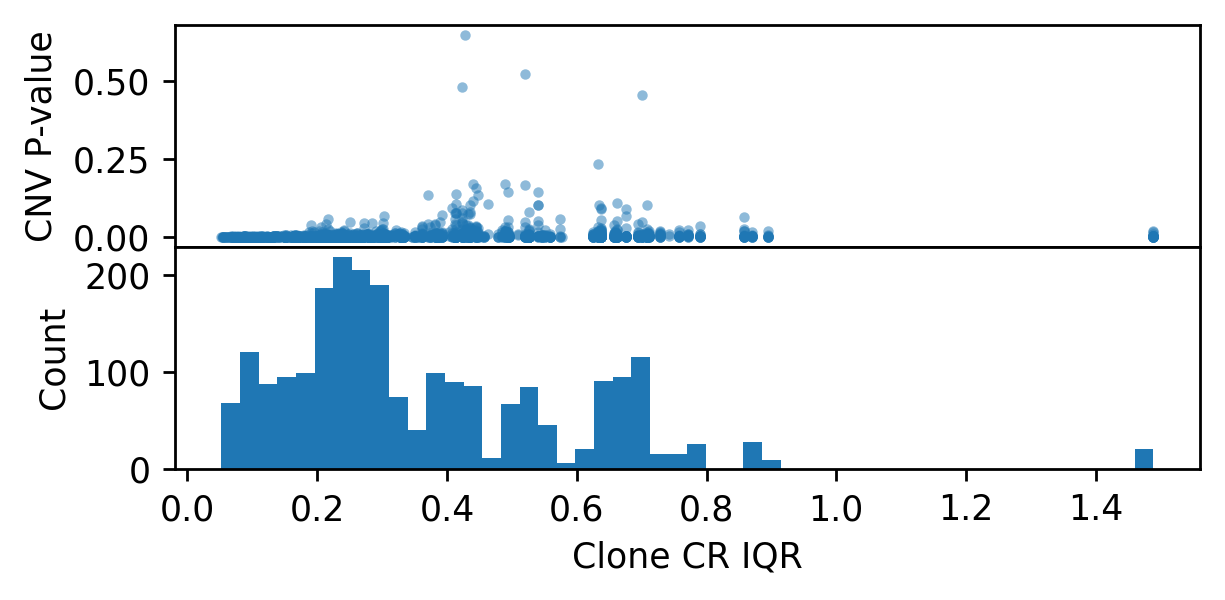

In [20]:
stdev_list = []; pval_list = []
for clone in clone_CNV_dict:
    if clone not in clone_IQR_dict:
        continue
    stdev = clone_IQR_dict[clone]
    for chrom in clone_CNV_dict[clone]:
        for start, end in clone_CNV_dict[clone][chrom]:
            CNV = (chrom, start, end)
            pval = clone_CNV_pval_dict[clone][CNV]
            stdev_list.append(stdev); pval_list.append(pval)

fig, ax = plt.subplots(2, 1, figsize=(5, 2.5), sharex=True)
ax[0].plot(stdev_list, pval_list, '.', alpha=0.5, markeredgewidth=0)
ax[0].set_ylabel("CNV P-value")
ax[1].hist(stdev_list, bins=50)
ax[1].set_xlabel("Clone CR IQR")
ax[1].set_ylabel("Count")
plt.tight_layout(); plt.subplots_adjust(hspace=0)

In [21]:
# Include manually verified combined CNVs from my heuristic algorithm output

# These happen to all be amplifications
verified_combined_CNVs = []
#('BMGF-Winzeler-5391-2E3', 'Pf3D7_01_v3', 238416, 570522),
#                         ('BMGF-Winzeler-5391-3E9', 'Pf3D7_01_v3', 264958, 570522), 
#                         ('BMGF-Fidock-852-R2-A1-SOFTCLIP', 'Pf3D7_12_v3', 745752, 827962)]
#                          ('BMGF-Winzeler-882-3D7-SOFTCLIP', 'Pf3D7_05_v3', 936981, 1054163)]

new_clone_CNV_dict = {}
new_clone_CNV_pval_dict = defaultdict(dict)

for clone, chrom, start, end in verified_combined_CNVs:
    new_chrom_interval_class_dict = defaultdict(dict)
    pval_list = []
    for other_chrom in clone_CNV_dict[clone]:
        for interval in clone_CNV_dict[clone][other_chrom]:
            part_start, part_end = interval
            if other_chrom == chrom and (part_start >= start and part_end <= end): # Part of combined CNV
                new_chrom_interval_class_dict[chrom][(start, end)] = 'amplification'
                pval_list.append(clone_CNV_pval_dict[clone][(chrom, part_start, part_end)])
            else: # Not part of a combined CNV
                new_chrom_interval_class_dict[other_chrom][(part_start, part_end)] = clone_CNV_dict[clone][other_chrom][interval]
                new_clone_CNV_pval_dict[clone][(other_chrom, part_start, part_end)] = clone_CNV_pval_dict[clone][(other_chrom, part_start, part_end)]
    
    new_clone_CNV_dict[clone] = new_chrom_interval_class_dict
    new_clone_CNV_pval_dict[clone][(chrom, start, end)] = np.mean(pval_list)

for clone in clone_CNV_dict:
    if clone in [tup[0] for tup in verified_combined_CNVs]:
        continue
    else:
        new_clone_CNV_dict[clone] = clone_CNV_dict[clone]
        new_clone_CNV_pval_dict[clone] = clone_CNV_pval_dict[clone]

clone_CNV_dict = new_clone_CNV_dict
clone_CNV_pval_dict = new_clone_CNV_pval_dict
        
num_CNVs = 0
for clone in clone_CNV_dict:
    for chrom in clone_CNV_dict[clone]:
        num_CNVs += len(clone_CNV_dict[clone][chrom])
print("%i CNVs, %i clones" % (num_CNVs, len(clone_CNV_dict)))

2307 CNVs, 623 clones


In [22]:
# Load heuristic validation data

clone_CNV_heuristic_validation_dict = {clone: defaultdict(dict) for clone in clone_CNV_dict}
clone_tandemdup_heuristic_validation_dict = {clone: defaultdict(dict) for clone in clone_CNV_dict}
# Actually, use old start, end for now
clone_tandemdup_revised_boundaries_dict = {clone: defaultdict(dict) for clone in clone_CNV_dict} # Uses revised start, end
# clone_CNV_pval_dict = {clone: defaultdict(dict) for clone in clone_CNV_dict}

for strain in ['3D7', 'Dd2']:
    f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/CNV_validation_results_%s_KWD.tsv' % strain)
    header = f.readline()
    num_CNVs = 0
    for line in f:
        items = line.strip().split('\t')
        compound, clone, chrom, start, end, pval, copyratio, classification, support, newstart, newend = items[:11]
        start = int(start); end = int(end)

        if '(' in support:
            support = int(support.split('(')[1].split(',')[0])
        elif support != 'None':
            support = int(support)

        clone_CNV_heuristic_validation_dict[clone][chrom][(start, end)] = (classification, support)
        # clone_CNV_pval_dict[clone][chrom][(start, end)] = float(pval) if pval != 'combined' else -1

        if classification == 'TANDEM DUPLICATION':
            newstart = int(newstart); newend = int(newend)
            clone_tandemdup_heuristic_validation_dict[clone][chrom][(start, end)] = support
            clone_tandemdup_revised_boundaries_dict[clone][chrom][(start, end)] = (newstart, newend)

for strain in ['3D7', 'Dd2']:
    f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/CNV_validation_results_070623_%s_KWD.tsv' % strain)
    header = f.readline()
    num_CNVs = 0
    for line in f:
        items = line.strip().split('\t')
        compound, clone, chrom, start, end, pval, copyratio, classification, support, newstart, newend = items[:11]
        start = int(start); end = int(end)

        if '(' in support:
            support = int(support.split('(')[1].split(',')[0])
        elif support != 'None':
            support = int(support)

        clone_CNV_heuristic_validation_dict[clone][chrom][(start, end)] = (classification, support)
        # clone_CNV_pval_dict[clone][chrom][(start, end)] = float(pval) if pval != 'combined' else -1

        if classification == 'TANDEM DUPLICATION':
            newstart = int(newstart); newend = int(newend)
            clone_tandemdup_heuristic_validation_dict[clone][chrom][(start, end)] = support
            clone_tandemdup_revised_boundaries_dict[clone][chrom][(start, end)] = (newstart, newend)

In [23]:
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/CNV_validation_results_clado_Dd2.tsv')
header = f.readline()
num_CNVs = 0
for line in f:
    items = line.strip().split('\t')
    compound, clone, chrom, start, end, pval, copyratio, classification, support, newstart, newend = items[:11]
    start = int(start); end = int(end)
    if '(' in support:
        support = int(support.split('(')[1].split(',')[0])
    elif support != 'None':
        support = int(support)    
    clone_CNV_heuristic_validation_dict[clone][chrom][(start, end)] = (classification, support)    
    if classification == 'TANDEM DUPLICATION':
        newstart = int(newstart); newend = int(newend)
        clone_tandemdup_heuristic_validation_dict[clone][chrom][(start, end)] = support
        clone_tandemdup_revised_boundaries_dict[clone][chrom][(start, end)] = (newstart, newend)

In [24]:
for clone in clone_tandemdup_heuristic_validation_dict:
    if 'clado' in clone:
        print(clone, clone_tandemdup_heuristic_validation_dict[clone])

cladorA defaultdict(<class 'dict'>, {'Pf3D7_13_v3': {(2000658, 2058294): 178}})
cladorB defaultdict(<class 'dict'>, {'Pf3D7_13_v3': {(2005108, 2055221): 335}})
cladorC defaultdict(<class 'dict'>, {'Pf3D7_13_v3': {(2000326, 2022966): 585}})


In [25]:
# Load DELLY data

DELLY_clone_CNV_dict = {}
DELLY_clone_CNV_quality_dict = {}

for strain in ['Dd2', '3D7']:
    f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/bamnames_%s_all.txt' % strain, 'r')
    sample_bam_names = []
    for line in f:
        sample_bam_names.append(line.strip().split('.ready.bam')[0].split('.bam')[0])
    
    if strain == 'Dd2':
        f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/bamnames_%s_fix_clado.txt' % strain, 'r')
        for line in f:
            sample_bam_names.append(line.strip().split('.ready.bam')[0].split('.bam')[0])
    
    f.close()
    
    for sample_bam_name in sample_bam_names:
        clone = bam_name_to_clone_name(sample_bam_name)
        
        if clone in clone_strain_dict and clone_strain_dict[clone] != strain: # Only use the designated strain
            continue

        try:
            f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/delly_output_%s/%s.vcf' % (strain, sample_bam_name), 'r')
        except:
            continue
        
        for line in f:
            if line[0] == '#':
                continue
            items = line.strip().split('\t')
            CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT, DATA = items
            POS = int(POS)    
            QUAL = int(QUAL)
            format_dict = parse_delly_info(INFO)
            END = int(format_dict['END'])
            LEN = END - POS
            GT, CN, CNL, GQ, FT, RDCN, RDSD = DATA.split(':') 
            CN = int(CN) # Integer copy number
            RDCN = float(RDCN) # Read depth based copy number estimate
            
            if CN == 0:
                cnv_type = 'deletion'
            elif CN == 1:
                cnv_type = 'balanced'
            elif CN > 1:
                cnv_type = 'amplification'
            
            if clone not in DELLY_clone_CNV_dict:
                DELLY_clone_CNV_dict[clone] = defaultdict(dict)
                DELLY_clone_CNV_quality_dict[clone] = defaultdict(dict)
            
            DELLY_clone_CNV_dict[clone][CHROM][(POS, END)] = cnv_type
            DELLY_clone_CNV_quality_dict[clone][CHROM][(POS, END)] = QUAL

In [26]:
# Filter CNVs for DELLY support

clone_CNV_validation_dict = {}

quality_threshold = 20
coverage_threshold = 0.5

threshold_prop_covered_values_dict = defaultdict(list)

for quality_threshold in [10, 20, 30, 40, 50, 100]:
    for clone in clone_CNV_dict:
        clone_CNV_validation_dict[clone] = defaultdict(dict)

        for chrom in clone_CNV_dict[clone]:
            for CNV in clone_CNV_dict[clone][chrom]:

                CNV_type = clone_CNV_dict[clone][chrom][CNV]
                start, end = CNV            
                size = end - start

                total_overlap_bp = 0            
                for match_CNV in DELLY_clone_CNV_dict[clone][chrom]:
                    quality = DELLY_clone_CNV_quality_dict[clone][chrom][match_CNV]
                    match_CNV_type = DELLY_clone_CNV_dict[clone][chrom][match_CNV]
                    if CNV_type == match_CNV_type and quality >= quality_threshold:
                        total_overlap_bp += getOverlap(CNV, match_CNV)

                prop_covered = (total_overlap_bp/float(size))
                clone_CNV_validation_dict[clone][chrom][CNV] = prop_covered
                threshold_prop_covered_values_dict[quality_threshold].append(prop_covered)

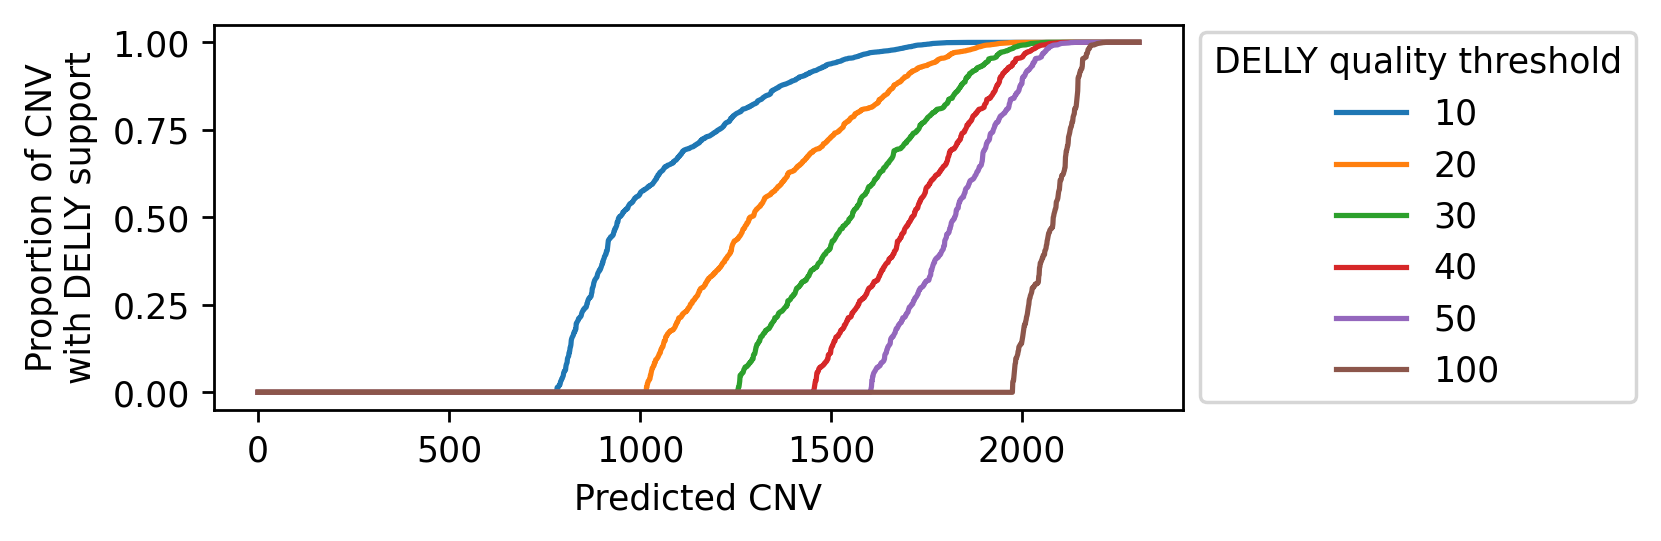

In [28]:
fig, ax = plt.subplots(figsize=(5, 2))
for threshold in threshold_prop_covered_values_dict:
    ax.plot(sorted(threshold_prop_covered_values_dict[threshold]), label=threshold)
ax.set_ylabel("Proportion of CNV\nwith DELLY support")
ax.set_xlabel("Predicted CNV")
ax.legend(title="DELLY quality threshold", loc='center left', bbox_to_anchor=(1, 0.5))

In [30]:
tandem_dup_support_thresholds = [2, 4, 6, 8, 10]
pval_thresholds = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1]
prop_passing_list_dict = defaultdict(list)

for tandem_dup_support_threshold in tandem_dup_support_thresholds:
    for pval_threshold in pval_thresholds:
        num_passing = 0
        total_num_CNVs = 0
        
        for clone in clone_CNV_dict:
            for chrom in clone_CNV_dict[clone]:
                for CNV in clone_CNV_dict[clone][chrom]:
                    classification, support = clone_CNV_heuristic_validation_dict[clone][chrom][CNV]
                    pval = clone_CNV_pval_dict[clone][chrom][CNV]
                    total_num_CNVs += 1
                    if ('TANDEM DUP' in classification and support >= tandem_dup_support_threshold) or pval < pval_threshold:
                            num_passing += 1

        prop_passing_list_dict[tandem_dup_support_threshold].append(num_passing/float(total_num_CNVs))

KeyError: 'Pf3D7_01_v3'

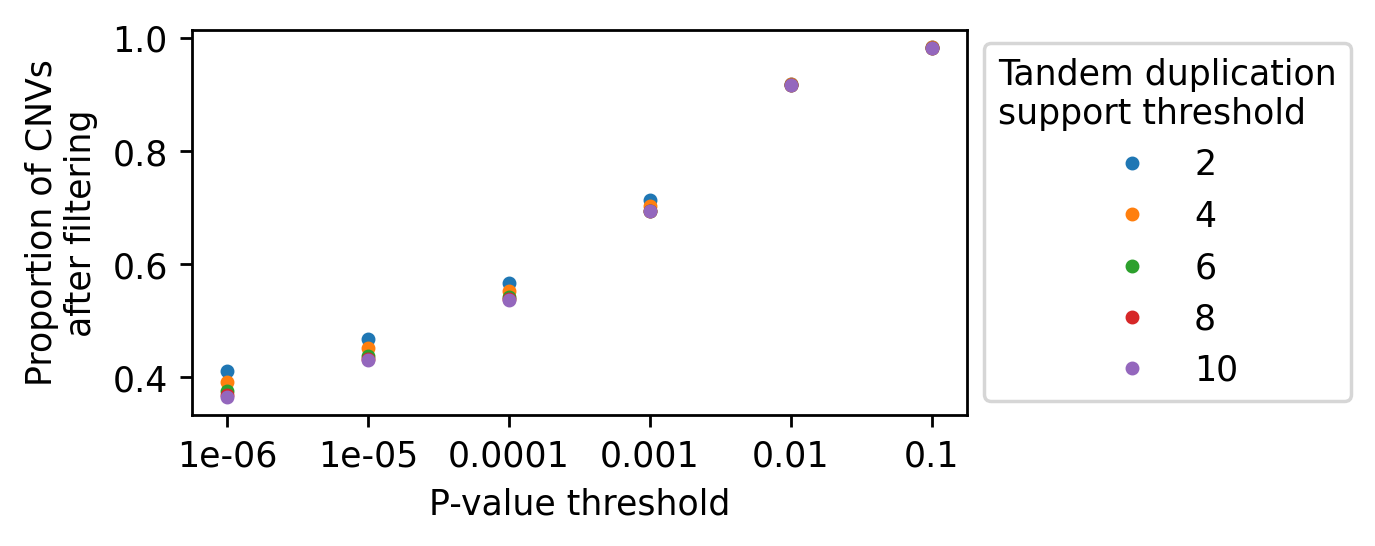

In [15]:
fig, ax = plt.subplots(figsize=(4, 2))
xs = np.arange(len(pval_thresholds))
for td_threshold in tandem_dup_support_thresholds:
    ax.plot(xs, prop_passing_list_dict[td_threshold], '.', label=str(td_threshold))
ax.set_xticks(xs)
ax.set_xticklabels([str(val) for val in pval_thresholds])
ax.set_ylabel("Proportion of CNVs\nafter filtering")
ax.set_xlabel("P-value threshold")
ax.legend(title="Tandem duplication\nsupport threshold", loc='center left', bbox_to_anchor=(1, 0.5))

## Function to get filtered CNVs

In [16]:
# Validate anything with enough coverage by high quality DELLY CNVs
quality_threshold = 30
coverage_threshold = 0.6

# Validate anything with low enough P-value
pval_threshold = 1e-6

# Validate tandem duplications
tandem_dup_support_threshold = 4

# Keep criteria order: DELLY, tandem duplication, P-value

def filter_CNVs(quality_threshold, coverage_threshold, pval_threshold, tandem_dup_support_threshold, 
                keep_criteria=[1, 1, 1], keep_method='or'):
    
    clone_CNV_full_validation_dict = defaultdict(dict)
    for clone in clone_CNV_dict:
        for chrom in clone_CNV_dict[clone]:
            clone_CNV_full_validation_dict[clone][chrom] = defaultdict(bool)

    for clone in clone_CNV_dict:    
        for chrom in clone_CNV_dict[clone]:
            for CNV in clone_CNV_dict[clone][chrom]:
                
                validation_status = [False, False, False]

                CNV_type = clone_CNV_dict[clone][chrom][CNV]
                start, end = CNV            
                size = end - start

                total_overlap_bp = 0            
                for match_CNV in DELLY_clone_CNV_dict[clone][chrom]:
                    quality = DELLY_clone_CNV_quality_dict[clone][chrom][match_CNV]
                    match_CNV_type = DELLY_clone_CNV_dict[clone][chrom][match_CNV]
                    if CNV_type == match_CNV_type and quality >= quality_threshold:
                        total_overlap_bp += getOverlap(CNV, match_CNV)

                prop_covered = (total_overlap_bp/float(size))
                if prop_covered > coverage_threshold:
                    validation_status[0] = True
                    clone_CNV_full_validation_dict[clone][chrom][CNV] = True

                classification, support = clone_CNV_heuristic_validation_dict[clone][chrom][CNV]
                pval = clone_CNV_pval_dict[clone][chrom][CNV]

                if ('TANDEM DUP' in classification and support >= tandem_dup_support_threshold):
                    validation_status[1] = True
                
                if pval < pval_threshold:
                    validation_status[2] = True
                
                keep = False
                if keep_method == 'or': # At least one is True
                    for i, use in enumerate(keep_criteria):
                        if use == 1 and validation_status[i] == True:
                            keep = True
                elif keep_method == 'and': # All have to be True
                    total = sum(keep_criteria); count = 0
                    for i, use in enumerate(keep_criteria):
                        if use == 1 and validation_status[i] == True:
                            count += 1
                    keep = True if count == total else False
                
                clone_CNV_full_validation_dict[clone][chrom][CNV] = keep
    
    return clone_CNV_full_validation_dict

def summarize_stdev(clone_CNV_full_validation_dict):
    truepos_values = []; falsepos_values = []
    for clone in clone_CNV_full_validation_dict:
        stdev = clone_stdev_dict[clone]
        for chrom in clone_CNV_full_validation_dict[clone]:
            for CNV in clone_CNV_full_validation_dict[clone][chrom]:
                if clone_CNV_full_validation_dict[clone][chrom][CNV] is True: # Validated
                    truepos_values.append(stdev)
                else: # Not validated (false positive)
                    falsepos_values.append(stdev)
    return (truepos_values, falsepos_values)

def keep_criteria_to_str(keep_criteria, keep_method):
    names = ['DELLY', 'TandemDup', 'P-value']
    names_to_use = []
    for use, name in zip(keep_criteria, names):
        if use == 1:
            names_to_use.append(name)
    return (" " + keep_method + "\n").join(names_to_use)

def get_DELLY_coverage_dict(quality_threshold):
    
    clone_CNV_prop_coverage_dict = defaultdict(dict)
    for clone in clone_CNV_dict:
        for chrom in clone_CNV_dict[clone]:
            clone_CNV_prop_coverage_dict[clone][chrom] = defaultdict(dict)

    for clone in clone_CNV_dict:    
        for chrom in clone_CNV_dict[clone]:
            for CNV in clone_CNV_dict[clone][chrom]:
                CNV_type = clone_CNV_dict[clone][chrom][CNV]
                start, end = CNV            
                size = end - start

                total_overlap_bp = 0            
                for match_CNV in DELLY_clone_CNV_dict[clone][chrom]:
                    quality = DELLY_clone_CNV_quality_dict[clone][chrom][match_CNV]
                    match_CNV_type = DELLY_clone_CNV_dict[clone][chrom][match_CNV]
                    if CNV_type == match_CNV_type and quality >= quality_threshold:
                        total_overlap_bp += getOverlap(CNV, match_CNV)

                prop_covered = (total_overlap_bp/float(size))
                clone_CNV_prop_coverage_dict[clone][chrom][CNV] = prop_covered
    
    return clone_CNV_prop_coverage_dict

## Characterize false positives

Text(0, 0.5, 'Standard deviation')

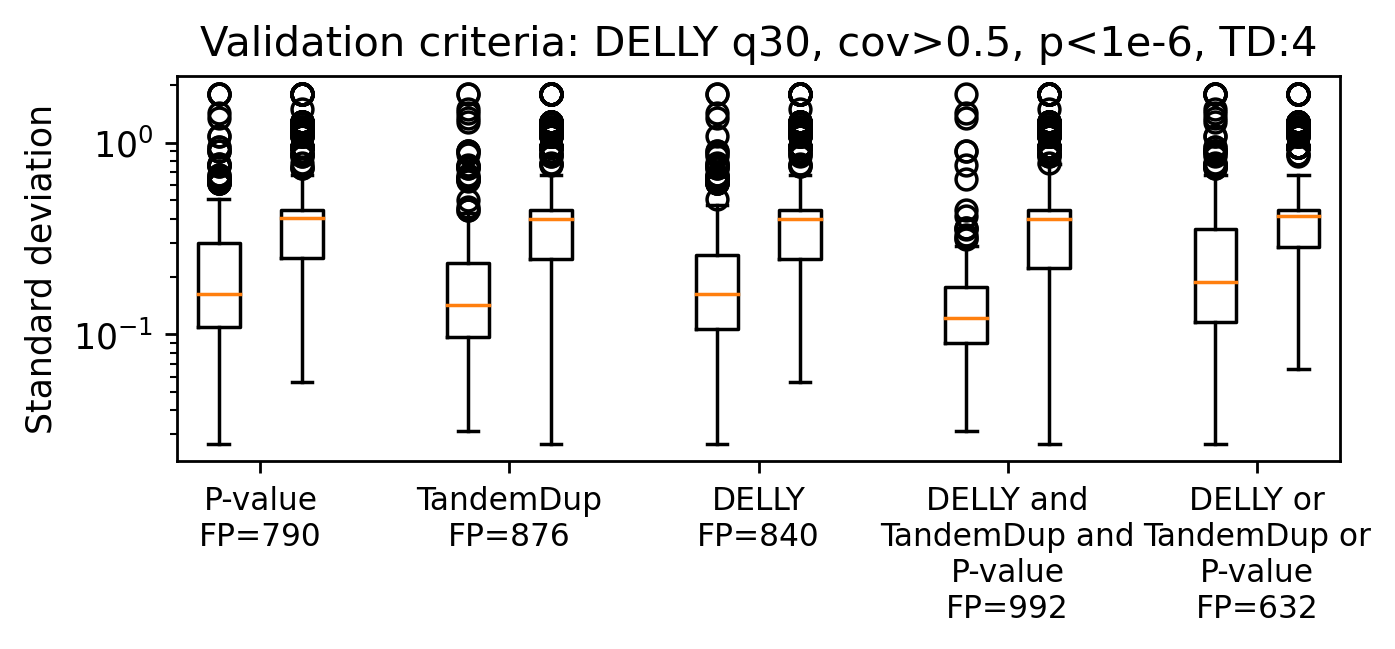

In [17]:
# Classifier type 1: validate CNV if at least one of three types of support
# Plot standard deviations of true positives vs. false positives

# Final filtering

data = []
positions = []
cur_position = 0
label_positions = []
labels = []

for keep_criteria, keep_method in [([0, 0, 1], 'and'), ([0, 1, 0], 'and'), ([1, 0, 0], 'and'), 
                                   ([1, 1, 1], 'and'), ([1, 1, 1], 'or')]:
    clone_CNV_full_validation_dict = filter_CNVs(30, 0.5, 1e-6, 4, keep_criteria, keep_method)
    truepos_values, falsepos_values = summarize_stdev(clone_CNV_full_validation_dict)
    TP = len(truepos_values); FP = len(falsepos_values)
    data += [truepos_values, falsepos_values]
    positions += [cur_position+1, cur_position+2]
    label_positions.append(cur_position + 1.5)
    label = keep_criteria_to_str(keep_criteria, keep_method)
    label += f"\nFP={FP}"
    labels.append(label)
    cur_position += 3

fig, ax = plt.subplots(figsize=(6, 2))
ax.boxplot(data, positions=positions)
ax.set_yscale('log')
ax.set_xticks(label_positions)
ax.set_xticklabels(labels, fontsize=9)
ax.set_title("Validation criteria: DELLY q30, cov>0.5, p<1e-6, TD:4")
ax.set_ylabel("Standard deviation")

## How well does copy ratio method work for low standard deviation samples?

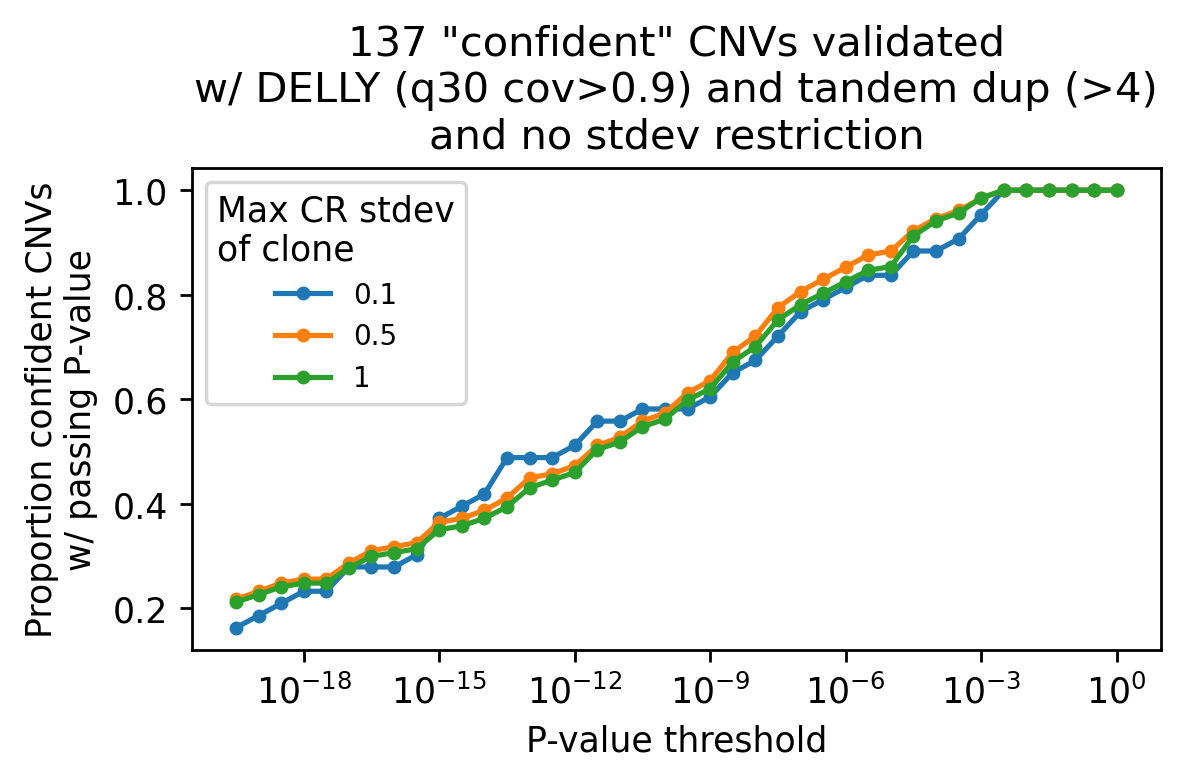

In [18]:
# Use samples that have support with all three as "confident" subset

stdev_list = [0.1, 0.5, 1]
clone_CNV_real_validation_dict = filter_CNVs(30, 0.9, 1e-10, 4, [1, 1, 0], 'and')

fig, ax = plt.subplots(figsize=(5, 2.5))

for stdev_max in stdev_list:
    
    num_test_list = []
    pval_threshold_list = []
    for x in np.arange(0, 20, 0.5):
        pval_threshold = 10**(-1*x)
        pval_threshold_list.append(pval_threshold)
        clone_CNV_test_validation_dict = filter_CNVs(30, 0.5, pval_threshold, 4, [0, 0, 1], 'and')

        num_real = 0; num_test = 0
        for clone in clone_CNV_real_validation_dict:
            if clone_stdev_dict[clone] > stdev_max: # Skip clones with standard deviation we don't want to consider
                continue
            for chrom in clone_CNV_real_validation_dict[clone]:
                for CNV in clone_CNV_real_validation_dict[clone][chrom]:
                    if clone_CNV_real_validation_dict[clone][chrom][CNV] is True:
                        num_real += 1
                        if clone_CNV_test_validation_dict[clone][chrom][CNV] is True:
                            num_test += 1

        num_test_list.append(num_test)
    
    ax.plot(pval_threshold_list, np.array(num_test_list)/num_real, '.-', label=stdev_max)

ax.set_xscale('log')
ax.set_xlabel("P-value threshold")
ax.set_ylabel("Proportion confident CNVs\nw/ passing P-value")
ax.set_title('%i "confident" CNVs validated\nw/ DELLY (q30 cov>0.9) and tandem dup (>4)\nand no stdev restriction' % num_real)
ax.legend(title="Max CR stdev\nof clone", fontsize=8)

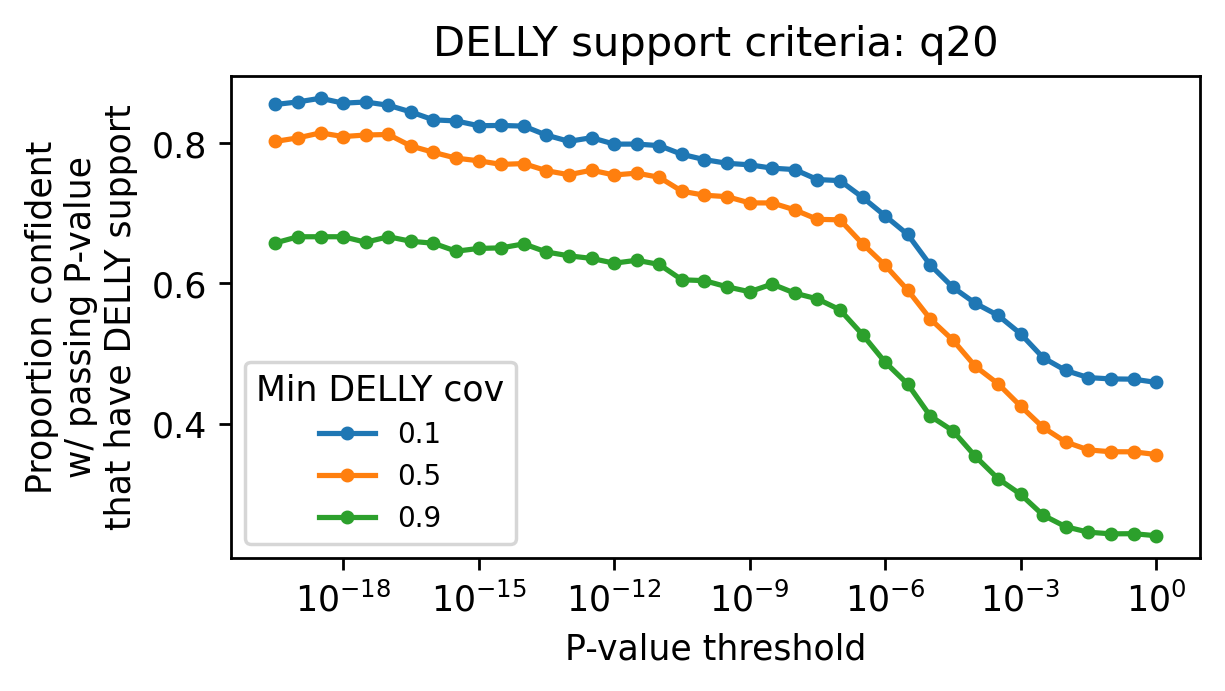

In [19]:
# What proportions of CNVs using different P-value thresholds have DELLY support?
# Could also make boxplots of DELLY coverage values

DELLY_cov_list = [0.1, 0.5, 0.9]
DELLY_quality_threshold = 20

fig, ax = plt.subplots(figsize=(5, 2.5))

for DELLY_cov_threshold in DELLY_cov_list:

    num_pval_list = []
    prop_delly_list = []
    pval_threshold_list = []

    for x in np.arange(0, 20, 0.5):
        pval_threshold = 10**(-1*x)
        pval_threshold_list.append(pval_threshold)

        clone_CNV_pval_validation_dict = filter_CNVs(DELLY_quality_threshold, DELLY_cov_threshold, pval_threshold, 4, [0, 0, 1], 'and')
        clone_CNV_delly_validation_dict = filter_CNVs(DELLY_quality_threshold, DELLY_cov_threshold, 1e-10, 4, [1, 0, 0], 'and')

        num_pval = 0; num_delly = 0
        for clone in clone_CNV_pval_validation_dict:
            for chrom in clone_CNV_pval_validation_dict[clone]:
                for CNV in clone_CNV_pval_validation_dict[clone][chrom]:
                    if clone_CNV_pval_validation_dict[clone][chrom][CNV] is True: # Has low enough P-value
                        num_pval += 1
                        if clone_CNV_delly_validation_dict[clone][chrom][CNV] is True:
                            num_delly += 1

        num_pval_list.append(num_pval)
        prop_delly_list.append(num_delly/float(num_pval))
    
    ax.plot(pval_threshold_list, prop_delly_list, '.-', label=DELLY_cov_threshold)

ax.set_xscale('log')
ax.set_xlabel("P-value threshold")
ax.set_ylabel("Proportion confident\nw/ passing P-value\nthat have DELLY support")
ax.set_title('DELLY support criteria: q%i' % DELLY_quality_threshold)
ax.legend(title="Min DELLY cov", fontsize=8)

Text(0.5, 0, 'Maximum P-value threshold for CNV')

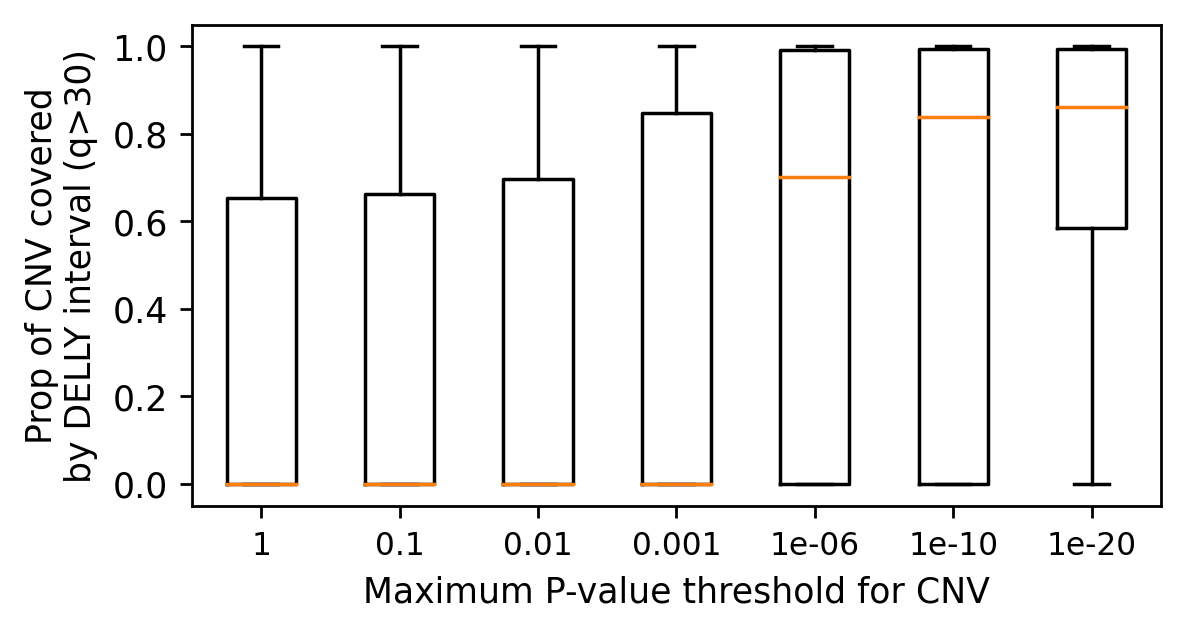

In [22]:
# What proportions of CNVs using different P-value thresholds have DELLY support?
# Could also make boxplots of DELLY coverage values

DELLY_quality_threshold = 30
clone_CNV_prop_coverage_dict = get_DELLY_coverage_dict(DELLY_quality_threshold)

data = []
labels = []

for x in [0, 1, 2, 3, 6, 10, 20]:
    pval_threshold = 10**(-1*x)
    labels.append(str(pval_threshold))

    clone_CNV_pval_validation_dict = filter_CNVs(DELLY_quality_threshold, DELLY_cov_threshold, pval_threshold, 4, [0, 0, 1], 'and')
    
    coverages = []
    for clone in clone_CNV_pval_validation_dict:
        for chrom in clone_CNV_pval_validation_dict[clone]:
            for CNV in clone_CNV_pval_validation_dict[clone][chrom]:
                if clone_CNV_pval_validation_dict[clone][chrom][CNV] is True: # Has low enough P-value
                    coverage = clone_CNV_prop_coverage_dict[clone][chrom][CNV]
                    coverages.append(coverage) # Store DELLY coverage
    data.append(coverages)

xs = np.arange(len(data))

fig, ax = plt.subplots(figsize=(5, 2.5))
ax.boxplot(data, positions=xs)
ax.set_xticks(xs)
ax.set_xticklabels(labels, fontsize=9)
ax.set_ylabel("Prop of CNV covered\nby DELLY interval (q>%i)" % DELLY_quality_threshold)
ax.set_xlabel("Maximum P-value threshold for CNV")

# Final filter

In [53]:
# Print as full table with support information

quality_threshold1 = 10
quality_threshold2 = 30

output_f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/CNV_multi_validation_results_full_KW.tsv', 'w')
header_items = ['In master set', 'Clone', 'Compound', 'Strain', 'Chrom', 'Start', 'End', 'CNV Number', 'CNV type', 
                'P-value', 'IQR', 'Tandem duplication support', 'DELLY overlap proportion (quality threshold 10)', 
                'DELLY overlap proportion (quality threshold 30)']
output_f.write('\t'.join(header_items) + '\n')

for clone in sorted(new_clones_included):
    
    in_master_set = (clone in final_clones)
    strain = clone_strain_dict[clone] if clone in clone_strain_dict else ""
    IQR = clone_IQR_dict[clone] if clone in clone_IQR_dict else ""
    compound = clone_compound_dict[clone] if clone in clone_compound_dict else ""
    
    if clone not in clone_CNV_dict: # No CNVs
        items = [in_master_set, clone, compound, strain, "None found", "", "", "", "", "", IQR, "", "", ""]
        output_f.write('\t'.join([str(item) for item in items]) + '\n')
    else:        
        for chrom in clone_CNV_dict[clone]:
            for CNV in clone_CNV_dict[clone][chrom]:

                CNV_type = clone_CNV_dict[clone][chrom][CNV]
                start, end = CNV            
                size = end - start

                total_overlap_bp1 = 0            
                for match_CNV in DELLY_clone_CNV_dict[clone][chrom]:
                    quality = DELLY_clone_CNV_quality_dict[clone][chrom][match_CNV]
                    match_CNV_type = DELLY_clone_CNV_dict[clone][chrom][match_CNV]
                    if CNV_type == match_CNV_type and quality >= quality_threshold1:
                        total_overlap_bp1 += getOverlap(CNV, match_CNV)

                prop_covered1 = (total_overlap_bp1/float(size))

                total_overlap_bp2 = 0            
                for match_CNV in DELLY_clone_CNV_dict[clone][chrom]:
                    quality = DELLY_clone_CNV_quality_dict[clone][chrom][match_CNV]
                    match_CNV_type = DELLY_clone_CNV_dict[clone][chrom][match_CNV]
                    if CNV_type == match_CNV_type and quality >= quality_threshold2:
                        total_overlap_bp2 += getOverlap(CNV, match_CNV)

                prop_covered2 = (total_overlap_bp2/float(size))

                classification, support = clone_CNV_heuristic_validation_dict[clone][chrom][CNV]

                pval = clone_CNV_pval_dict[clone][(chrom, start, end)]

                try:
                    CNV_num = clone_CNV_num_dict[clone][(chrom, start, end)]
                except:
                    CNV_num = 'N/A'

                if not ('TANDEM DUP' in classification):
                    support = -1

                items = [in_master_set, clone, compound, strain, chrom, start, end, CNV_num, CNV_type, pval, IQR,
                         support, prop_covered1, prop_covered2]
                output_f.write('\t'.join([str(item) for item in items]) + '\n')

output_f.close()

In [37]:
sanity_check_CNV_list = []
f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/CNV_multi_validation_results_full_KW.tsv', 'r')
header = f.readline()
for line in f:
    _, clone, _, _, chrom, start, end, _, _, _, _, _, _, _ = line.strip('\n').split('\t')
    sanity_check_CNV_list.append((clone, (chrom, start, end)))

print(len(sanity_check_CNV_list))

3048


In [44]:
sanity_check_CNV_list2 = []

f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/NewSummmaryTableall.tsv', 'r')
header = f.readline()
for line in f:
    bam_name, chrom, _, cr_avg, start, end, CNV_num, pval, IQR, parent_cr_avg, strain = line.strip('\n').split('\t')
    start = "" if start == " " else start; end = "" if end == " " else end
    clone = bam_name_to_clone_name(bam_name)
    sanity_check_CNV_list2.append((clone, (chrom, start, end)))

print(len(sanity_check_CNV_list2))

3055


In [47]:
for x in sanity_check_CNV_list2:
    if x not in sanity_check_CNV_list:
        print(x)

('BMGF-Winzeler-5391-2E3', ('Pf3D7_01_v3', '238416', '321758'))
('BMGF-Winzeler-5391-2E3', ('Pf3D7_01_v3', '357584', '570522'))
('BMGF-Winzeler-5391-3E9', ('Pf3D7_01_v3', '264958', '326234'))
('BMGF-Winzeler-5391-3E9', ('Pf3D7_01_v3', '352064', '570522'))
('Goldberg-834-3D7-15-D9', ('None found', '', ''))
('Goldberg-834-3D7-15-E5', ('None found', '', ''))
('Goldberg-834-3D7-15-H12', ('None found', '', ''))
('BMGF-Goldberg-11438-2D5', ('None found', '', ''))
('BMGF-Goldberg-11438-2G1', ('None found', '', ''))


In [52]:
clone_CNV_dict['BMGF-Goldberg-11438-2G1']

defaultdict(dict,
            {'Pf3D7_03_v3': {(218867, 232555): 'amplification'},
             'Pf3D7_04_v3': {(155627, 177502): 'amplification'},
             'Pf3D7_10_v3': {(286413, 314766): 'amplification'},
             'Pf3D7_11_v3': {(1908960, 1935832): 'amplification'},
             'Pf3D7_12_v3': {(1550074, 1566829): 'amplification'},
             'Pf3D7_13_v3': {(78364, 100771): 'amplification'}})

# Filtering method: manual decision tree

# CONTINUE HERE

What counts as near noncore?
5% of chrom length away from boundary
3% of chrom length away from internal hypervariable
---------------------
High IQR > 0.3:
TD >=4 not near noncore and DELLY10 >0.2, or
P-value < 1e-5 and DELLY10 > 0.8 and DELLY30 > 0.3

Intermediate IQR 0.12-0.3:
TD >=4 not near noncore and DELLY10 >0.2, or
P-value < 1e-4 and DELLY10 > 0.6 and DELLY30 > 0.2

Low IQR < 0.12:
TD >=4 not near noncore and DELLY10 >0.15, or
TD >=4 not near noncore and P-value < 1e-5, or
P-value < 0.0015 and DELLY10 > 0.45

How to combine CNVs:
Use TD value at the start, add the DELLY overlaps and take the minimum of the P-values
5000 bp?

In [28]:
def CNV_near_noncore(chrom, start, end):
    chrom_len = chrom_length_dict[chrom]
    
    noncore_start, noncore_end = chrom_noncore_regions_dict[chrom][0] # Starting region
    if (start <= noncore_start) or ((start-noncore_start) <= 0.05*chrom_len):
        return True
    
    noncore_start, noncore_end = chrom_noncore_regions_dict[chrom][-1] # Ending region
    if (noncore_end <= end) or ((noncore_end-end) <= 0.05*chrom_len):
        return True
    
    for noncore_start, noncore_end in chrom_noncore_regions_dict[chrom][1:-1]: # Internal hypervariable
        if ((noncore_start-start) <= 0.01*chrom_len) and ((end-noncore_end) <= 0.01*chrom_len):
            return True
        elif start <= noncore_start and noncore_end <= end:
            return True
    
    return False

def CNV_DELLY_prop_covered(clone, chrom, CNV, CNV_type, quality_threshold):
    start, end = CNV            
    size = end - start
    total_overlap_bp = 0
    
    for match_CNV in DELLY_clone_CNV_dict[clone][chrom]:
        quality = DELLY_clone_CNV_quality_dict[clone][chrom][match_CNV]
        match_CNV_type = DELLY_clone_CNV_dict[clone][chrom][match_CNV]
        if CNV_type == match_CNV_type and quality >= quality_threshold:
            total_overlap_bp += getOverlap(CNV, match_CNV)

    prop_covered = (total_overlap_bp/float(size))
    return prop_covered

In [29]:
# Returns dict CNV -> list of old CNVs

def get_combined_CNV_map(clone, chrom):
    combined_CNV_map = defaultdict(list)
    
    CNVs = sorted(clone_CNV_dict[clone][chrom].keys())

    combined_CNVs = []
    combination_found = False

    prev_start, prev_end = CNVs[0]; start, end = prev_start, prev_end
    CNVs_included = [(start, end)]
    for CNV in CNVs[1:]:
        CNV_type = clone_CNV_dict[clone][chrom][CNV]
        start, end = CNV

        if (start - prev_end) < 12000:
            combination_found = True
            CNVs_included.append((start, end))
            prev_end = end
        else: # New CNV
            combined_CNV_map[(prev_start, prev_end)] = CNVs_included
            CNVs_included = [(start, end)]
            prev_start, prev_end = CNV

    combined_CNV_map[(prev_start, prev_end)] = CNVs_included
    return combination_found, combined_CNV_map

In [30]:
# Test combining CNVs
for clone in sorted(final_clones):
    
    if clone not in clone_CNV_dict: # No CNVs
        continue
    
    # Firstly combine CNVs
    for chrom in clone_CNV_dict[clone]:
        CNVs = sorted(clone_CNV_dict[clone][chrom].keys())
        
        combined_CNVs = []
        combination_found = False
        
        prev_start, prev_end = CNVs[0]
        for CNV in CNVs[1:]:
            CNV_type = clone_CNV_dict[clone][chrom][CNV]
            start, end = CNV
            
            if (start - prev_end) < 12000:
                # print(clone, chrom, prev_start, prev_end, ' | ', start, end)
                combination_found = True
                prev_end = end
            else: # New CNV
                combined_CNVs.append((prev_start, prev_end))
                prev_start, prev_end = CNV
        
        combined_CNVs.append((prev_start, prev_end))
        
        if combination_found is False and set(CNVs) != set(combined_CNVs):
            print("sus")
        elif combination_found:
            #print(clone, chrom)
            #print(CNVs)
            #print(combined_CNVs)
            #print(get_combined_CNV_map(clone, chrom)[1])
            #print()
            pass

In [31]:
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/pf_gene_manhattan_pos.tsv', 'r')
gene_manhattan_pos_tups = []
ordered_genes = []
for line in f:
    gene, pos = line.rstrip('\n').split('\t')
    gene_manhattan_pos_tups.append((gene, pos))
    ordered_genes.append(gene)

In [32]:
for clone in final_clones:
    if final_clones.count(clone) > 1:
        print(clone)

In [33]:
# This annotates combined CNVs in separate column and includes all original CNVs
# Also stores final CNV list data for future plots

output_f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/NewSummmaryTableall-b_validation_v2.tsv', 'w')
header_items = original_header_items + ['Alt clone name', 'Compound', 'Tandem duplication support',
                                        'DELLY overlap proportion (quality threshold 10)',
                                        'DELLY overlap proportion (quality threshold 30)',
                                        'Combined with (CNV number)', 'Passes filter',
                                        'Technical duplicate', 'In master set'] # New added columns
output_f.write('\t'.join(header_items) + '\n')

row_new_data = {}

gene_clones_dict = defaultdict(set)
gene_compounds_dict = defaultdict(set)

clone_master_CNV_dict = {clone: defaultdict(dict) for clone in final_clones}
clone_filtered_CNV_validation_dict = {clone: defaultdict(dict) for clone in final_clones}
clone_independent_CNV_validation_dict = {clone: defaultdict(dict) for clone in final_clones}
clone_CNV_support_dict = {clone: defaultdict(dict) for clone in 
                          final_clones} # clone -> chrom -> start, end -> (P-value, TD support, DELLY10, DELLY30)

filtered_CNVs = set(); filtered_CNV_nums = set(); filtered_CNV_pval_dict = {}
independent_CNVs = set(); independent_CNV_nums = set()
independent_tandemdups = set()

new_row_duplicate_dict = {} # clone, chrom, start str, end str -> bool

for clone in sorted(test_clones_included):
    
    strain = clone_strain_dict[clone]    
    compound = clone_compound_dict[clone] if clone in clone_compound_dict else ""
    in_master_set = (clone in final_clones)
    
    if clone not in clone_CNV_dict: # No CNVs
        row_new_data[(clone, "None found", ' ', ' ')] = [clone, compound, '', '', '', '', '']
        continue    
    
    
    if clone not in clone_IQR_dict: # Clador
        for chrom in clone_CNV_dict[clone]:
            for start, end in clone_CNV_dict[clone][chrom]:
                CNV = (start, end)
                CNV_type = clone_CNV_dict[clone][chrom][CNV]
                DELLY10_prop_covered = CNV_DELLY_prop_covered(clone, chrom, CNV, CNV_type, 10)
                DELLY30_prop_covered = CNV_DELLY_prop_covered(clone, chrom, CNV, CNV_type, 30)
                TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][CNV]
                items = [clone, compound, TD_support, DELLY10_prop_covered, DELLY30_prop_covered, '', True]
                print(items)
                row_new_data[(clone, chrom, str(start), str(end))] = [str(item) for item in items]
                filtered_CNVs.add((clone, chrom, (start, end)))
                independent_CNVs.add((clone, chrom, (start, end)))
                genes = interval_to_genes(chrom, start, end, desc=False)
                for gene in genes:
                    gene_clones_dict[gene].add(clone)
                    gene_compounds_dict[gene].add(compound)
        continue
    
    IQR = clone_IQR_dict[clone]
    
    # Firstly combine CNVs
    for chrom in clone_CNV_dict[clone]:
        
        combined_status, combined_CNV_map = get_combined_CNV_map(clone, chrom)
        
        for combined_CNV in combined_CNV_map:            
            CNVs = combined_CNV_map[combined_CNV]
            
            first_CNV = CNVs[0]
            first_CNV_num = clone_CNV_num_dict[clone][(chrom, first_CNV[0], first_CNV[1])] if len(CNVs) > 1 else ''
            try:
                TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][first_CNV]
            except:
                TD_support = -1
            
            starting_TD = TD_support
            pvals = []
            total_size = 0
            DELLY10_covered_sum = 0
            DELLY30_covered_sum = 0
            for CNV in CNVs:

                CNV_type = clone_CNV_dict[clone][chrom][CNV]
                start, end = CNV; size = end-start

                # Support sources
                DELLY10_prop_covered = CNV_DELLY_prop_covered(clone, chrom, CNV, CNV_type, 10)
                DELLY30_prop_covered = CNV_DELLY_prop_covered(clone, chrom, CNV, CNV_type, 30)
                try:
                    TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][CNV]
                except:
                    TD_support = -1
                pval = clone_CNV_pval_dict[clone][(chrom, start, end)]
                
                pvals.append(pval)
                DELLY10_covered_sum += (size*DELLY10_prop_covered)
                DELLY30_covered_sum += (size*DELLY30_prop_covered)
                total_size += size

                # Other stuff
                try:
                    CNV_num = clone_CNV_num_dict[clone][(chrom, start, end)]
                except:
                    CNV_num = 'N/A'
            
            DELLY10_prop_covered_overall = DELLY10_covered_sum/float(total_size)
            DELLY30_prop_covered_overall = DELLY30_covered_sum/float(total_size)
            min_pval = min(pvals)
            start, end = combined_CNV
            
            # Filters
            keep = False
            if IQR > 0.3:
                if starting_TD >= 4 and not CNV_near_noncore(chrom, start, end) and DELLY10_prop_covered_overall > 0.2:
                    keep = True
                elif min_pval < 1e-5 and DELLY10_prop_covered_overall > 0.8 and DELLY30_prop_covered_overall > 0.3:
                    keep = True
            elif IQR > 0.12:
                if starting_TD >= 4 and not CNV_near_noncore(chrom, start, end) and DELLY10_prop_covered_overall > 0.2:
                    keep = True
                elif min_pval < 1e-4 and DELLY10_prop_covered_overall > 0.6 and DELLY30_prop_covered_overall > 0.2:
                    keep = True
            elif IQR <= 0.12:
                if starting_TD >= 4 and not CNV_near_noncore(chrom, start, end) and DELLY10_prop_covered_overall > 0.15:
                    keep = True
                elif starting_TD >= 4 and not CNV_near_noncore(chrom, start, end) and min_pval < 1e-5:
                    keep = True
                elif min_pval < 0.0015 and DELLY10_prop_covered_overall > 0.45:
                    keep = True
            
            # Write output
            is_duplicate = False
            for CNV in CNVs:

                CNV_type = clone_CNV_dict[clone][chrom][CNV]
                start, end = CNV; size = end-start

                # Support sources
                DELLY10_prop_covered = CNV_DELLY_prop_covered(clone, chrom, CNV, CNV_type, 10)
                DELLY30_prop_covered = CNV_DELLY_prop_covered(clone, chrom, CNV, CNV_type, 30)
                try:
                    TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][CNV]
                except:
                    TD_support = -1
                pval = clone_CNV_pval_dict[clone][(chrom, start, end)]
                
                items = [clone, compound, starting_TD, DELLY10_prop_covered_overall,
                         DELLY30_prop_covered_overall, first_CNV_num, keep]
                row = (clone, chrom, str(start), str(end))
                row_new_data[row] = [str(item) for item in items]
                if row in original_row_duplicate_dict and original_row_duplicate_dict[row] is True:
                    is_duplicate = True
            
            for CNV in CNVs:
                start, end = CNV
                row = (clone, chrom, str(start), str(end))
                new_row_duplicate_dict[row] = is_duplicate
            
            if in_master_set:
                clone_master_CNV_dict[clone][chrom][(start, end)] = 'amplification'
                clone_CNV_support_dict[clone][chrom][(start, end)] = (min_pval, starting_TD, DELLY10_prop_covered_overall,
                                                                      DELLY30_prop_covered_overall)            
                clone_filtered_CNV_validation_dict[clone][chrom][(start, end)] = keep
                clone_independent_CNV_validation_dict[clone][chrom][(start, end)] = keep and (not is_duplicate)
            
            CNV_num = clone_CNV_num_dict[clone][(chrom, first_CNV[0], first_CNV[1])]
            
            if (in_master_set) and keep is True:
                filtered_CNVs.add((clone, chrom, combined_CNV))
                filtered_CNV_nums.add(CNV_num)
                filtered_CNV_pval_dict[(clone, chrom, combined_CNV)] = min_pval
                if (not is_duplicate):                   
                    independent_CNVs.add((clone, chrom, combined_CNV))
                    independent_CNV_nums.add(CNV_num)
                    genes = interval_to_genes(chrom, start, end, desc=False)
                    
                    if starting_TD >= 4: # Probably a tandem duplication
                        independent_tandemdups.add((clone, chrom, combined_CNV))
                    
                    for gene in genes:
                        gene_clones_dict[gene].add(clone)
                        gene_compounds_dict[gene].add(compound)

for row in original_rows:
    clone = row[0]
    in_master_set = (clone in final_clones)
    original_data = list(original_row_data[row])
    technical_duplicate = new_row_duplicate_dict[row] if row in new_row_duplicate_dict else ''
    
    if row in row_new_data:
        extra_data = row_new_data[row]
    else:        
        compound = clone_compound_dict[clone] if clone in clone_compound_dict else ""
        extra_data = [clone, compound, '', '', '', '', '']
    
    items = original_data + extra_data + [str(technical_duplicate), str(in_master_set)]
    output_f.write('\t'.join(items) + '\n')

output_f.close()

['cladorA', 'cladosporin', 178, 0.9998958983968353, 0.7882746894302173, '', True]
['cladorB', 'cladosporin', 335, 0.9546025981282302, 0.9546025981282302, '', True]
['cladorC', 'cladosporin', 585, 0.7306095406360424, 0.04845406360424028, '', True]


In [37]:
pickle.dump(filtered_CNVs, open('filtered_CNVs.pkl', 'wb'))

In [8]:
filtered_CNVs = pickle.load(open('filtered_CNVs.pkl', 'rb'))

In [9]:
len(filtered_CNVs)

367

In [34]:
for gene in gene_desc_dict:
    if 'MDR1' in gene_desc_dict[gene]:
        print(gene, gene_desc_dict[gene])

PF3D7_0523000 multidrug+resistance+protein+(MDR1)


In [35]:
chrom_interest = 'Pf3D7_05_v3'
gene_interest = 'PF3D7_0523000'
start_interest, end_interest, _ = chrom_gene_interval_dict[chrom_interest][gene_interest]
print(gene_desc_dict[gene_interest])
print(start_interest, end_interest)

multidrug+resistance+protein+(MDR1)
957890 962149


In [36]:
clones_of_interest = '''Goldberg-BI-2536-3D7-poolA
Goldberg-BI-2536-3D7-poolD
Goldberg-BI-2536-Dd2-pol-delta-cloneAE9
Goldberg-BI-2536-Dd2-pol-delta-cloneAG8
Goldberg-BI-2536-Dd2-pol-delta-cloneBB5
Goldberg-BI-2536-Dd2-pol-delta-cloneBE11
Goldberg-Dd2-pol-delta-Parent-3-2020
Goldberg-BI-2536-Dd2-poolA
Goldberg-BI-2536-Dd2-poolB
Goldberg-BI-2536-Dd2-poolD
Goldberg-Dd2-B2-Parent-3-2020'''.split('\n')
for clone, chrom, interval in filtered_CNVs:
    if clone in clones_of_interest:
        
        start, end = interval
        if start_interest >= start and end_interest <= end and chrom == chrom_interest:
            print(clone, chrom, interval, "*")
        else:
            print(clone, chrom, interval)
            for gene in chrom_gene_interval_dict[chrom]:
                gene_start, gene_end, _ = chrom_gene_interval_dict[chrom][gene]
                if gene_start >= start and gene_end <= end:
                    pass #print(gene, gene_desc_dict[gene])
        
        print()

Goldberg-BI-2536-Dd2-pol-delta-cloneBE11 Pf3D7_05_v3 (888445, 976126) *

Goldberg-BI-2536-3D7-poolD Pf3D7_03_v3 (782937, 921286)

Goldberg-BI-2536-Dd2-pol-delta-cloneAG8 Pf3D7_05_v3 (888445, 969987) *

Goldberg-BI-2536-3D7-poolA Pf3D7_03_v3 (802010, 838521)

Goldberg-BI-2536-Dd2-pol-delta-cloneAE9 Pf3D7_05_v3 (888445, 969987) *

Goldberg-BI-2536-Dd2-poolA Pf3D7_05_v3 (897215, 969987) *



In [40]:
chrom = 'Pf3D7_03_v3'
start, end = (802010, 838521)
for gene in chrom_gene_interval_dict[chrom]:
    gene_start, gene_end, _ = chrom_gene_interval_dict[chrom][gene]
    if gene_start >= start and gene_end <= end:
        print(gene, gene_desc_dict[gene].replace('+', ' '))

PF3D7_0319100 E3 ubiquitin-protein ligase RBX1, putative (RBX1)
PF3D7_0319200 endonuclease/exonuclease/phosphatase family protein, putative
PF3D7_0319300 ubiquitin-conjugating enzyme, putative
PF3D7_0319400 kinesin-8, putative
PF3D7_0319500 RNA-binding protein, putative
PF3D7_0319600 elongation factor 1 (EF-1), putative
PF3D7_0319700 ABC transporter, putative
PF3D7_0319800 conserved Plasmodium protein, unknown function
PF3D7_0319900 conserved Plasmodium protein, unknown function
PF3D7_0320000 protein phosphatase inhibitor 2 (I2)


In [38]:
# Look for DHODH (PF3D7_0603300) Pf3D7_06_v3:130,191..132,792
clones_of_interest = set()
for clone, chrom, interval in filtered_CNVs:
    if chrom == 'Pf3D7_06_v3':
        start, end = interval
        if start < 130191 and end > 132792:
            clones_of_interest.add(clone)

clone_of_interest_CNV_dict = defaultdict(list)
for clone, chrom, interval in filtered_CNVs:
    if clone in clones_of_interest:
        clone_of_interest_CNV_dict[clone].append((chrom, interval))

print(len(clones_of_interest))

11


In [83]:
print([header[1]] + header[4:8] + header[13:24])
print()
for clone in clones_of_interest:
    
    print(clone)
    records = master_clone_records_dict[clone.split('-fixed')[0]]
    if len(records) > 0:
        compound = records[0][1]
        strain, lab = records[0][5:7]
        print(f"Compound: {compound} | Strain: {strain} | Lab: {lab}")
    
    for chrom, interval in clone_of_interest_CNV_dict[clone]:
        print(f"CNV: {chrom}:{interval[0]}-{interval[1]} (length: {interval[1]-interval[0]})")
    
    print("SNV/indel:")
    for items in records:
        chrom, pos = items[7:9]
        var_info = items[13:24]
        print('\t' + '\t'.join([f"{chrom}:{pos}"] + var_info))
    print()

['Compound', 'Approximate EC50 Fold Shift (x)', 'Parasite Genetic Background', 'Lab', 'Chromosome', 'Gene Name', 'Gene Description', 'Quality', 'Ref Base', 'Alt Base', 'Type', 'Effect', 'Impact', 'Codon Change', 'Amino Acid Change', 'Status']

TCMDC125334-3D7-T-F1-C2
Compound: TCMDC-125334 | Strain: 3D7 | Lab: Wirth
CNV: Pf3D7_06_v3:99531-160705 (length: 61174)
SNV/indel:
	Pf3D7_03_v3:1056064			735.88	A	T	SNP	intergenic_region				clonal
	Pf3D7_08_v3:1472707			5985.35	C	T	SNP	intergenic_region				clonal
	Pf3D7_12_v3:430430	PF3D7_1209300	telomere repeat-binding zinc finger protein	22708.84	ACTTGCATCACTTCTTCGG	A	INDEL	disruptive_inframe_deletion		agccgaagaagtgatgcaagt/agt	p.Arg812_Ser817del/c.2433_2450delCCGAAGAAGTGATGCAAG	clonal
	Pf3D7_12_v3:1709660	PF3D7_1240400	"erythrocyte membrane protein 1, PfEMP1"	11343.84	A	ACACCAGCACCAG	INDEL	disruptive_inframe_insertion		cct/ccAGCACCAGCACCt	p.Pro1740_Ser1741insAlaProAlaPro/c.5208_5219dupAGCACCAGCACC	clonal

GSK-MMV1490397-Dd2F-Pool3
Compound: MM

In [32]:
filtered_CNV_clones = set([clone for clone, chrom, combined_CNV in filtered_CNVs])
independent_CNV_clones = set([clone for clone, chrom, combined_CNV in independent_CNVs])
print("%i CNVs in %i clones post filtering, %i independent CNVs in %i clones" % (len(filtered_CNVs), len(filtered_CNV_clones),
                                                       len(independent_CNVs), len(independent_CNV_clones)))
print("%i independent tandem duplications" % len(independent_tandemdups))

367 CNVs in 283 clones post filtering, 243 independent CNVs in 189 clones
179 independent tandem duplications


In [35]:
pickle.dump(filtered_CNVs, open('resistome_filtered_CNVs.tsv', 'wb'))
pickle.dump(independent_CNVs, open('resistome_independent_CNVs.tsv', 'wb'))

In [40]:
IQRs = []; all_IQRs = []
for clone in sorted(set([x[0] for x in filtered_CNVs])):
    if 'MMV006901' in clone and clone in master_clone_set:
        IQRs.append(clone_IQR_dict[clone])
        print(('%.03f' % clone_IQR_dict[clone]) + '\t' + clone)

for clone in sorted(set([x[0] for x in filtered_CNVs])):
    if clone_strain_dict[clone] == '3D7':
        all_IQRs.append(clone_IQR_dict[clone])

print(np.mean(IQRs))
print(len(all_IQRs), np.median(all_IQRs))

0.388	Goldberg-MMV006901-3D7-2C8
0.392	Goldberg-MMV006901-3D7-2F9
0.413	Goldberg-MMV006901-3D7-5D5
0.424	Goldberg-MMV006901-3D7-5F11
0.414	Goldberg-MMV006901-3D7-5G4
0.110	Goldberg-MMV006901-3D7-6B11
0.113	Goldberg-MMV006901-3D7-6B6
0.118	Goldberg-MMV006901-3D7-6H3
0.2964475
137 0.17466


In [40]:
x = 0
for CNV in filtered_CNV_pval_dict:
    pval = filtered_CNV_pval_dict[CNV]
    if pval > 0.0001:
        x += 1
        print('\t'.join([str(item) for item in CNV] + [str(pval)]))
print(x)

2-2-D12	Pf3D7_12_v3	(1550074, 1566829)	0.0011798
2-2-D3	Pf3D7_12_v3	(1550074, 1566829)	0.00074792
4-1-C3	Pf3D7_12_v3	(1550074, 1566829)	0.0011326
4-3-A7	Pf3D7_12_v3	(1550074, 1566829)	0.001204
4-3-E3	Pf3D7_12_v3	(1550074, 1566829)	0.0013596
4-3-Ell	Pf3D7_12_v3	(1550074, 1566829)	0.0015958
BMGF-Fidock-023367-1B1	Pf3D7_05_v3	(948701, 969987)	0.0014154
BMGF-Fidock-023367-1G6	Pf3D7_05_v3	(948701, 969987)	0.0013596
BMGF-Fidock-029272-R3F10	Pf3D7_10_v3	(1507332, 1555952)	0.00027151
BMGF-Fidock-7224-R2-A2-SOFTCLIP	Pf3D7_12_v3	(783768, 799861)	0.00013105
BMGF-Fidock-8149R1-B2	Pf3D7_07_v3	(114989, 129175)	0.0022715
BMGF-Fidock-8149R2-E3	Pf3D7_08_v3	(1268885, 1284011)	0.0001948
BMGF-Fidock-8149R2-E3	Pf3D7_13_v3	(2655027, 2668031)	0.0028044
BMGF-Fidock-8149R3-B1	Pf3D7_03_v3	(402683, 413998)	0.0010872
BMGF-Fidock-8149R3-B1	Pf3D7_05_v3	(615032, 635632)	0.00015499
BMGF-Fidock-8149R3-B1	Pf3D7_08_v3	(855404, 870824)	0.0007966
BMGF-Fidock-8149R3-C10	Pf3D7_13_v3	(1087334, 1098714)	0.00073232
BMGF-Fidock

In [29]:
# Triple check
f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/NewSummmaryTableall-b_validation_v2.tsv', 'r')
header = f.readline()

candidate_clonesV = set(); candidate_CNVsV = set()
filtered_clonesV = set(); filtered_CNVsV = set(); filtered_CNV_numsV = set()
independent_clonesV = set(); independent_CNVsV = set(); independent_CNV_numsV = set()
low_pval_clonesV = set(); low_pval_CNVsV = set()

supp4_CNV_data_dict = {}

for line in f:
    items = line.rstrip('\n').split('\t')
    clone, chrom, _, _, start, end, CNV_num = items[:7]
    clone = items[11]
    pval = items[7]
    combined_with, passes_filter, is_duplicate, in_master_set = items[-4:]
    
    if chrom != "None found":
        if CNV_num == '': # Clador samples
            
            candidate_clonesV.add(clone)
            candidate_CNVsV.add((clone, chrom, (int(start), int(end))))
            filtered_clonesV.add(clone)
            filtered_CNVsV.add((clone, chrom, (int(start), int(end))))
            filtered_CNV_numsV.add(clone)
            supp4_CNV_data_dict[(clone, chrom, (int(start), int(end)))] = items
            independent_clonesV.add(clone)
            independent_CNVsV.add((clone, chrom, (int(start), int(end))))
            independent_CNV_numsV.add(clone)
        
        elif in_master_set == 'True':
            
            candidate_clonesV.add(clone)
            candidate_CNVsV.add((clone, chrom, (int(start), int(end))))
            
            if float(pval) < 0.0001:
                low_pval_clonesV.add(clone)
                low_pval_CNVsV.add((clone, chrom, (int(start), int(end))))
            
            if passes_filter == 'True':
                filtered_clonesV.add(clone)
                filtered_CNVsV.add((clone, chrom, (int(start), int(end))))
                supp4_CNV_data_dict[(clone, chrom, (int(start), int(end)))] = items
                filtered_CNV_numsV.add(combined_with if combined_with != '' else CNV_num)
                if is_duplicate != 'True':
                    independent_clonesV.add(clone)
                    independent_CNVsV.add((clone, chrom, (int(start), int(end))))
                    independent_CNV_numsV.add(combined_with if combined_with != '' else CNV_num)

print("%i CNVs in %i clones in master set" % (len(candidate_CNVsV), len(candidate_clonesV)))
print("%i CNVs in %i clones in master set with P-value < 0.0001" % (len(low_pval_CNVsV), len(low_pval_clonesV)))
print("%i CNVs (%i orig CNVs) in %i clones post filtering" % (len(filtered_CNV_numsV), len(filtered_CNVsV), len(filtered_clonesV)))
print("%i independent filtered CNVs (%i orig CNVs) in %i clones" % (len(independent_CNV_numsV), len(independent_CNVsV), len(independent_clonesV)))

1168 CNVs in 371 clones in master set
420 CNVs in 271 clones in master set with P-value < 0.0001
367 CNVs (410 orig CNVs) in 283 clones post filtering
243 independent filtered CNVs (270 orig CNVs) in 189 clones


# Supplemental Table 4

In [33]:
f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/CNV_extra_info.tsv', 'r')
bam_row_extra_filemaker_data_dict = {}
for line in f:
    bam_name, chrom, start, end, CNV_num, CNVindex, CNVindex_Count, num_repeats = [item.strip() for item in line.split('\t')]
    if 'clador' in bam_name:
        bam_name = 'p_fal_' + bam_name + '_p'
    bam_row_extra_filemaker_data_dict[(bam_name, chrom, start, end)] = [CNV_num, CNVindex, CNVindex_Count, num_repeats]

In [62]:
# Write Supplemental Table 4
# 410 original CNVs post filtering

f = open("/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/SupplementalData4_CNVs_072023.tsv", 'w')

header_items = ["Sample name", "Compound", "Genetic Background", "Chromosome", "CNV start", "CNV end", "CNV Number",
                "CNV size (# genes)", "Num repeats", "Average log2 copy ratio value", "Parent Average",
                "Parent comparison P-value", "Tandem duplication support",
                "DELLY overlap (quality>=10)", "DELLY overlap (quality>=30)", "Sample IQR",                   
                "Combined with", "Gene list", "Duplicate", "CNVindex", "CNVindex Count"]

f.write('\t'.join(header_items) + '\n')

x = 0
for CNV in sorted(filtered_CNVsV, key=lambda x: (clone_strain_dict[x[0]], x[0], x[1], x[2])):
    
    bam_clone, chrom, CNV_size, avg_CR, start, end, old_CNV_num, pval, IQR, parent_avg, strain, clone, \
        compound, TD_support, DELLY10, DELLY30, combined_with, passes_filter, \
        is_duplicate, in_master_set = supp4_CNV_data_dict[CNV]
    CNV_num, CNVindex, CNVindex_Count, num_repeats = bam_row_extra_filemaker_data_dict[(bam_clone, chrom, start, end)]
    if old_CNV_num != CNV_num: # New CNV numbers were added for these
        # print(clone, CNV_num, old_CNV_num)
        is_duplicate = 'False'
    genes = interval_to_genes(chrom, int(start), int(end), desc=False)
    combined_with = '' if combined_with == CNV_num else combined_with
    CNV_size = len(genes)
    items = [clone, compound, strain, chrom, start, end, CNV_num, CNV_size, num_repeats, avg_CR, parent_avg,
            pval, TD_support, DELLY10, DELLY30, IQR, combined_with, ','.join(genes), is_duplicate, CNVindex, CNVindex_Count]
    f.write('\t'.join([str(item) for item in items]) + '\n')

In [63]:
# Quadruple check
f = open("/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/SupplementalData4_CNVs_072023.tsv", 'r')
header = f.readline()

filtered_clonesV = set(); filtered_CNVsV = set(); filtered_CNV_numsV = set()
independent_clonesV = set(); independent_CNVsV = set(); independent_CNV_numsV = set()

for line in f:
    items = line.strip().split('\t')
    clone, _, _, chrom, start, end, CNV_num = items[:7]
    combined_with, _, duplicate = items[-5:-2]    
    
    filtered_clonesV.add(clone); filtered_CNVsV.add((clone, chrom, (int(start), int(end))))
    filtered_CNV_numsV.add(combined_with if combined_with != '' else CNV_num)
    
    if duplicate == 'False':
        independent_clonesV.add(clone); independent_CNVsV.add((clone, chrom, (int(start), int(end))))
        independent_CNV_numsV.add(combined_with if combined_with != '' else CNV_num)

print("%i CNVs (%i orig CNVs) in %i clones post filtering" % (len(filtered_CNV_numsV), len(filtered_CNVsV), len(filtered_clonesV)))
print("%i independent filtered CNVs (%i orig CNVs) in %i clones" % (len(independent_CNV_numsV), len(independent_CNVsV), len(independent_clonesV)))

367 CNVs (410 orig CNVs) in 283 clones post filtering
243 independent filtered CNVs (270 orig CNVs) in 189 clones


# Genes in independent CNVs for network

In [121]:
f = open("/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/independent_combined_CNV_genes.tsv", 'w')
f.write('\t'.join(['Clone', 'Chromosome', 'Start', 'End', 'Gene list']) + '\n')
for clone, chrom, CNV in independent_CNVs:
    start, end = CNV
    genes = interval_to_genes(chrom, start, end, desc=False)
    items = [clone, chrom, start, end, ','.join(genes)]
    f.write('\t'.join([str(item) for item in items]) + '\n')

# Manhattan plot

In [118]:
# Manually add cladosporin samples
#('BMGF-Winzeler-5391-2E3', 'Pf3D7_01_v3', 238416, 570522),
#                         ('BMGF-Winzeler-5391-3E9', 'Pf3D7_01_v3', 264958, 570522), 
#                         ('BMGF-Fidock-852-R2-A1-SOFTCLIP', 'Pf3D7_12_v3', 745752, 827962)]
#                          ('BMGF-Winzeler-882-3D7-SOFTCLIP', 'Pf3D7_05_v3', 936981, 1054163)]
"""
clado_CNVs = [line.split('\t') for line in '''cladorA	Pf3D7_13_v3	2000658	2058294
cladorB	Pf3D7_13_v3	2005108	2055221
cladorC	Pf3D7_13_v3	2000326	2022966'''.split('\n')]
compound = 'cladosporin'

for clone, chrom, start, end in clado_CNVs:
    start = int(start); end = int(end)
    genes = interval_to_genes(chrom, start, end, desc=False)
    for gene in genes:
        gene_clones_dict[gene].add(clone)
        gene_compounds_dict[gene].add(compound)
"""
pass

In [149]:
gene_abbreviation_dict = {}
for gene in gene_to_desc_dict:
    desc = gene_to_desc_dict[gene]
    if '(' in desc:
        abbr = desc.split('(')[1].split(')')[0]
        if abbr == 's':
            abbr = desc.split('(')[2].split(')')[0]
        gene_abbreviation_dict[gene] = abbr
        if len(abbr.split(' ')) > 1:
            pass # print(gene, desc, abbr)

gene_abbreviation_dict['PF3D7_0509000'] = "SNAP"
gene_abbreviation_dict['PF3D7_0317700'] = "CPSF"

In [154]:
f = open("/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/CNV_amplification_Manhattan_data_by_clone_all_names.tsv", 'w')
for gene, pos in gene_manhattan_pos_tups:
    count = len(gene_clones_dict[gene]) if gene in gene_clones_dict else 0
    gene_label = gene_abbreviation_dict[gene] if gene in gene_abbreviation_dict else ('' if count < 15 else gene)
    if count <= 2:
        gene_label = ''
    
    gene_label = gene + ' ' + (gene_to_desc_dict[gene] if gene in gene_to_desc_dict else '')
    
    if gene[:3] == 'PF3' and gene[6:9] != 'API':
        gene_idx = int(gene.split('PF3D7_')[1][:2])-1
        count_vector = [''] * 14
        count_vector[gene_idx] = count
        items = [gene_label, pos] + count_vector
        f.write('\t'.join([str(item) for item in items]) + '\n')
    else:
        count_vector = [''] * 14
        gene_label = ''
        items = [gene_label, pos] + count_vector
        f.write('\t'.join([str(item) for item in items]) + '\n')

f.close()

In [146]:
for gene in gene_to_desc_dict:
    desc = gene_to_desc_dict[gene]
    if 'sensitive factor' in desc:
        print(gene, desc)

PF3D7_0509000 SNAP protein (soluble N-ethylmaleimide-sensitive factor Attachment Protein), putative


In [95]:
gene_to_desc_dict['PF3D7_0523000']

'multidrug resistance protein (MDR1)'

# Old

In [46]:
# This combines CNVs (affects row count)

chrom_compound_interval_dict = {chrom: defaultdict(list) for chrom in chromosomes14}

output_f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/CNV_multi_validation_results_filtered_masterclones_with_genes_KW.tsv', 'w')
header_items = ['Strain', 'Compound', 'Clone', 'Chrom', 'Start', 'End', 'CNV Number', 'CNV type', 
                'P-value', 'IQR', 'Tandem duplication support', 'DELLY overlap proportion (quality threshold 10)', 
                'DELLY overlap proportion (quality threshold 30)', 'genes']
output_f.write('\t'.join(header_items) + '\n')

all_compounds = set()
all_clones = set()

all_pvals = []
all_DELLY_overlaps = []
orig_num_CNVs = 0

for clone in sorted(final_clones):
    
    if clone not in clone_CNV_dict: # No CNVs
        continue
    
    strain = clone_strain_dict[clone]
    IQR = clone_IQR_dict[clone]
    compound = clone_compound_dict[clone]
    
    # Firstly combine CNVs
    for chrom in clone_CNV_dict[clone]:
        
        combined_status, combined_CNV_map = get_combined_CNV_map(clone, chrom)
        
        for combined_CNV in combined_CNV_map:            
            CNVs = combined_CNV_map[combined_CNV]
            
            CNV = CNVs[0]
            try:
                TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][CNV]
            except:
                TD_support = -1
            
            starting_TD = TD_support
            pvals = []
            total_size = 0
            DELLY10_covered_sum = 0
            DELLY30_covered_sum = 0
            for CNV in CNVs:

                CNV_type = clone_CNV_dict[clone][chrom][CNV]
                start, end = CNV; size = end-start

                # Support sources
                DELLY10_prop_covered = CNV_DELLY_prop_covered(clone, chrom, CNV, CNV_type, 10)
                DELLY30_prop_covered = CNV_DELLY_prop_covered(clone, chrom, CNV, CNV_type, 30)
                try:
                    TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][CNV]
                except:
                    TD_support = -1
                pval = clone_CNV_pval_dict[clone][(chrom, start, end)]
                
                pvals.append(pval)
                DELLY10_covered_sum += (size*DELLY10_prop_covered)
                DELLY30_covered_sum += (size*DELLY30_prop_covered)
                total_size += size

                # Other stuff
                try:
                    CNV_num = clone_CNV_num_dict[clone][(chrom, start, end)]
                except:
                    CNV_num = 'N/A'
            
            DELLY10_prop_covered_overall = DELLY10_covered_sum/float(total_size)
            DELLY30_prop_covered_overall = DELLY30_covered_sum/float(total_size)
            min_pval = min(pvals)
            start, end = combined_CNV
            
            if clone == '11C-R-385' and chrom == 'Pf3D7_12_v3':#		1153102	1169352
                print(DELLY10_prop_covered_overall, DELLY30_prop_covered_overall, min_pval, starting_TD, IQR)
                print(chrom, start, end)
                print(CNV_near_noncore(chrom, start, end))
            
            # Filters
            keep = False
            if IQR > 0.3:
                if starting_TD >= 4 and not CNV_near_noncore(chrom, start, end) and DELLY10_prop_covered_overall > 0.2:
                    keep = True
                elif min_pval < 1e-5 and DELLY10_prop_covered_overall > 0.8 and DELLY30_prop_covered_overall > 0.3:
                    keep = True
            elif IQR > 0.12:
                if starting_TD >= 4 and not CNV_near_noncore(chrom, start, end) and DELLY10_prop_covered_overall > 0.2:
                    keep = True
                elif min_pval < 1e-4 and DELLY10_prop_covered_overall > 0.6 and DELLY30_prop_covered_overall > 0.2:
                    keep = True
            elif IQR <= 0.12:
                if starting_TD >= 4 and not CNV_near_noncore(chrom, start, end) and DELLY10_prop_covered_overall > 0.15:
                    keep = True
                elif starting_TD >= 4 and not CNV_near_noncore(chrom, start, end) and min_pval < 1e-5:
                    keep = True
                elif min_pval < 0.0015 and DELLY10_prop_covered_overall > 0.45:
                    keep = True
            
            orig_num_CNVs += 1
            
            if keep is False:
                continue
            
            genes = interval_to_genes(chrom, start, end, desc=False)
            all_pvals.append(min_pval)
            all_DELLY_overlaps.append(DELLY30_prop_covered_overall)
            
            # Write output
            items = [strain, compound, clone, chrom, start, end, CNV_num, CNV_type, min_pval, IQR,
                     starting_TD, DELLY10_prop_covered_overall, DELLY30_prop_covered_overall, ','.join(genes)]
            output_f.write('\t'.join([str(item) for item in items]) + '\n')
            chrom_compound_interval_dict[chrom][compound].append((start, end))
            all_compounds.add(compound)
            all_clones.add(clone)

output_f.close()

0.23876923076923076 0.0 0.00071813 -1 0.3618
Pf3D7_12_v3 1153102 1169352
False


In [19]:
len(all_clones)

277

In [54]:
len(all_compounds)

72

In [53]:
orig_num_CNVs

1055

In [51]:
len(all_pvals)

366

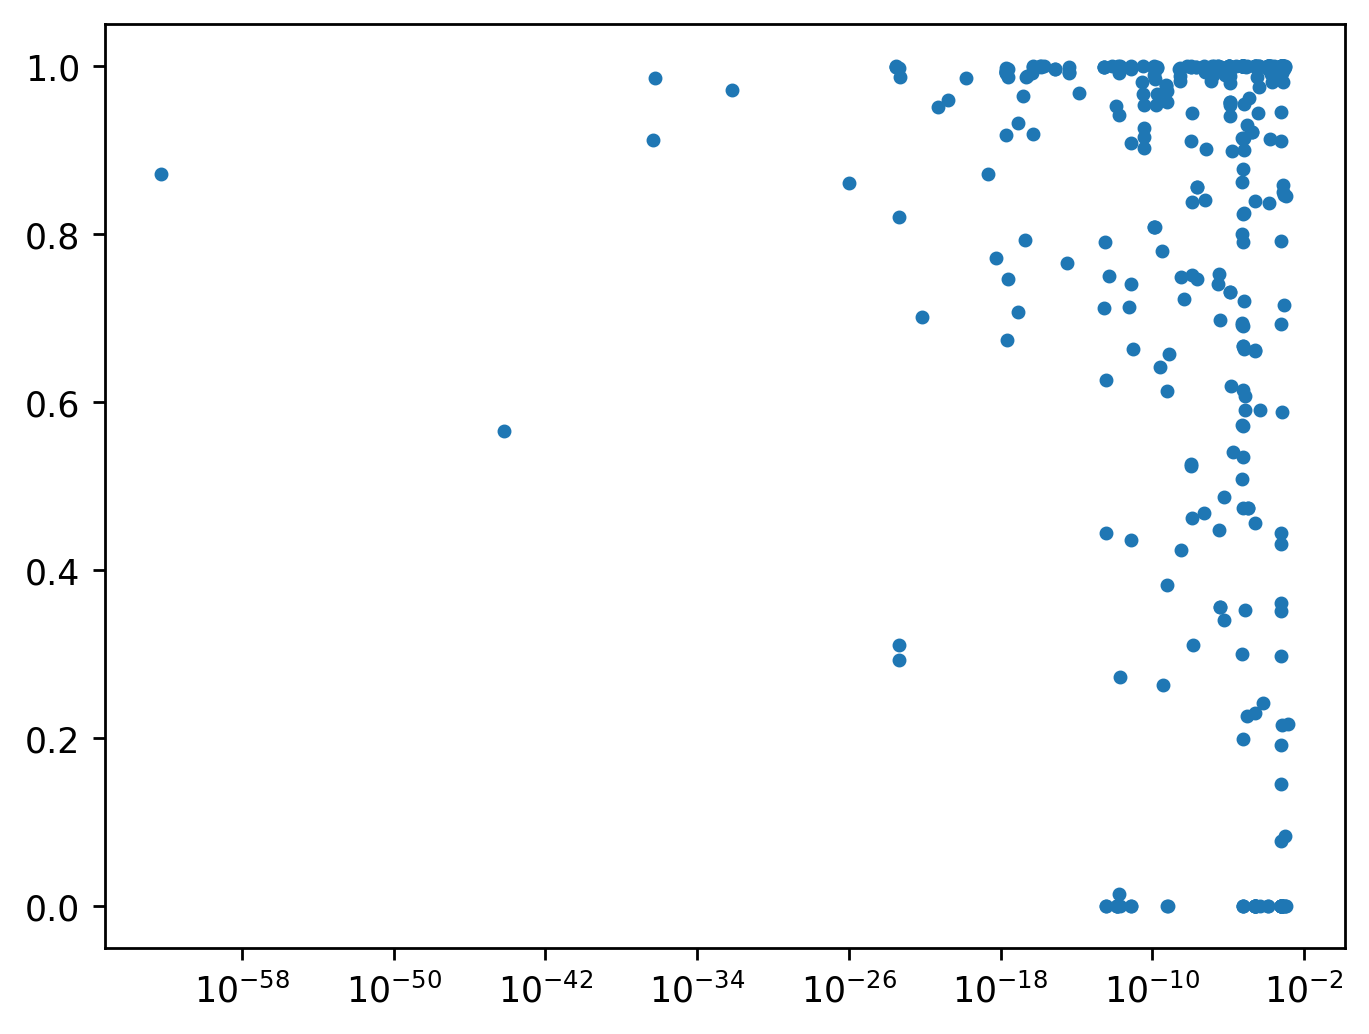

In [22]:
# Plot P-value vs. DELLY support
fig, ax = plt.subplots()
ax.plot(all_pvals, all_DELLY_overlaps, '.')
ax.set_xscale('log')

In [23]:
for chrom in chrom_compound_interval_dict:
    for compound in chrom_compound_interval_dict[chrom]:
        print(compound)
        for start, end in chrom_compound_interval_dict[chrom][compound]:
            print(interval_to_genes(chrom, start, end, desc=True))
        print("")

MMV023367
['mitochondrial carrier protein, putative', 'conserved Plasmodium protein, unknown function', 'conserved Plasmodium protein, unknown function', 'secreted ookinete protein, putative (PSOP24)', 'conserved Plasmodium protein, unknown function', 'unspecified product', 'photosensitized INA-labeled protein 1, PhIL1, putative', 'LCCL domain-containing protein (CCp5)', 'mRNA cleavage factor-like protein, putative', 'fatty acid elongation protein, GNS1/SUR4 family, putative', 'tubulin-specific chaperone a, putative', 'N-acetyltransferase, putative']

MMV028038
['DNA repair exonuclease Mre11, putative', 'conserved Plasmodium protein, unknown function', 'beta3 proteasome subunit, putative', 'conserved Plasmodium protein, unknown function', 'conserved Plasmodium protein, unknown function', 'mitochondrial carrier protein, putative', 'conserved Plasmodium protein, unknown function', 'conserved Plasmodium protein, unknown function', 'secreted ookinete protein, putative (PSOP24)', 'conserved

# Visualize CNVs grouped by compound

In [25]:
import matplotlib.cm as cm
import matplotlib.colors as colors

print(len(all_compounds))
cmap = matplotlib.cm.get_cmap('Dark2')

72


/tmp/ipykernel_1097756/1942405448.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Dark2')


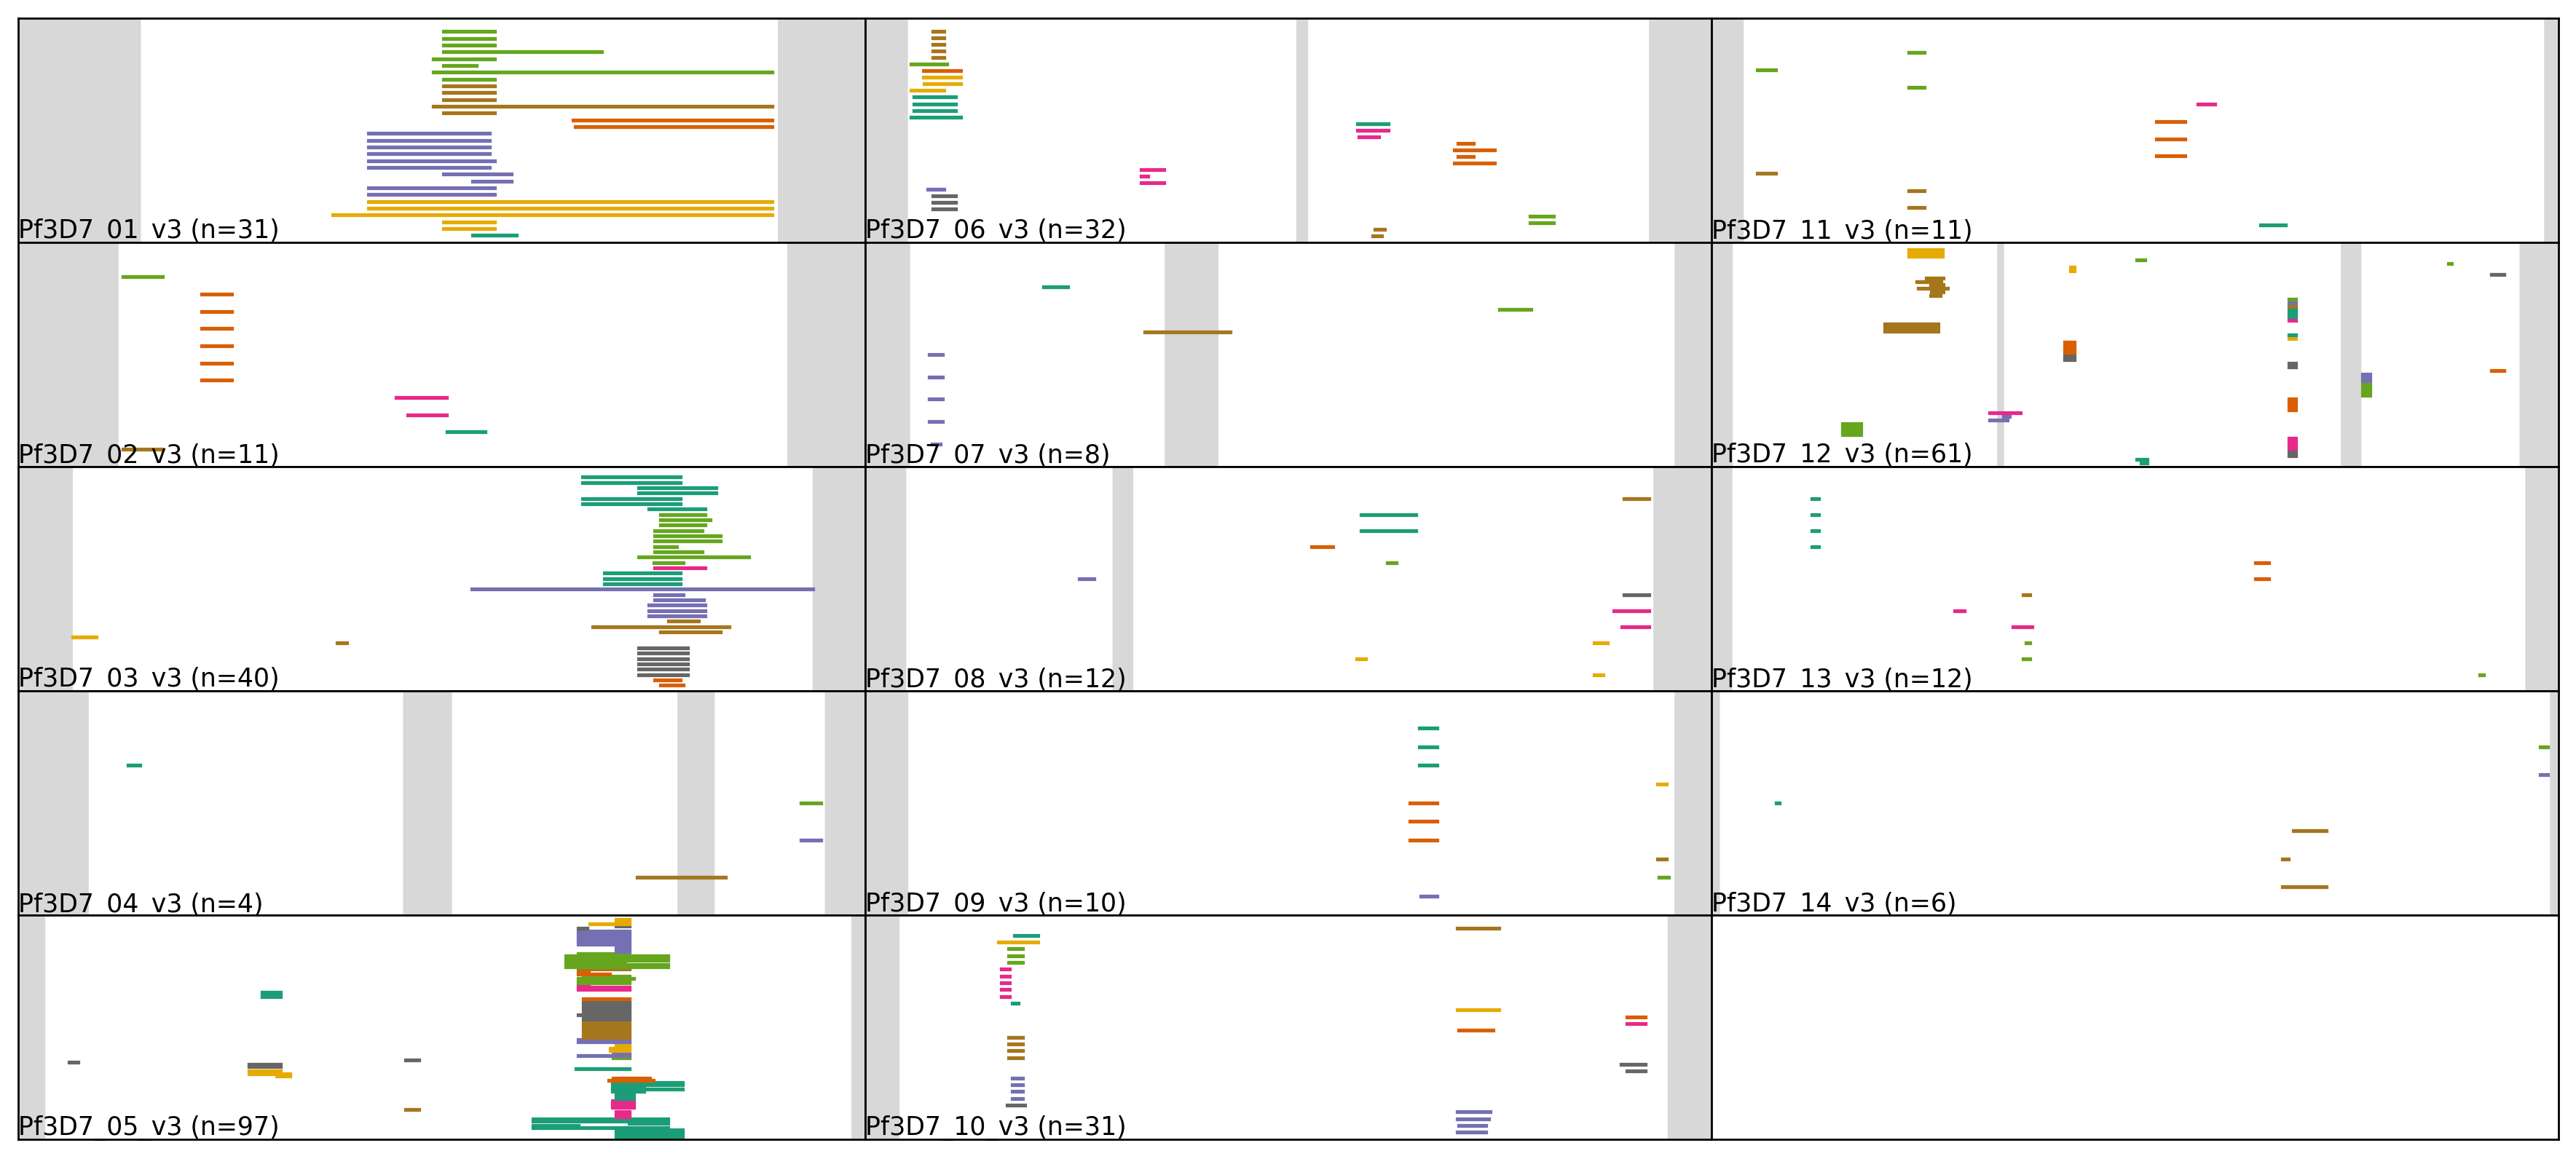

In [58]:
# Visualize where CNVs are found
fig, ax = plt.subplots(5, 3, figsize=(18, 8))

for idx, chrom in enumerate(chromosomes14):
    y = 0; i = idx%5; j = idx//5
    
    chrom_compounds = set(chrom_compound_interval_dict[chrom].keys())
    compound_color_dict = {}
    for x, compound in enumerate(chrom_compounds):
        compound_color_dict[compound] = cmap(x/float(len(chrom_compounds)))

    for compound in chrom_compound_interval_dict[chrom]:
        for start, end in chrom_compound_interval_dict[chrom][compound]:
            ax[i][j].plot([start, end], [y, y], '-', label=compound, color=compound_color_dict[compound])
            y += 1
    #ax[i][j].set_title("%s (n=%i CNVs)" % (chrom, y))
    ax[i][j].text(0, -1+(y/50), "%s (n=%i)" % (chrom, y))
    for noncore_start, noncore_end in chrom_noncore_regions_dict[chrom]:
        ax[i][j].fill_between(range(noncore_start, noncore_end+1), -1, y+1, color='gray', alpha=0.3, edgecolor=None, zorder=-5)
    
    ax[i][j].set_xlim((1, chrom_length_dict[chrom]))
    ax[i][j].set_ylim((-1, y+1))
    handles, labels = ax[i][j].get_legend_handles_labels()
    label_handle_dict = {}
    for label, handle in zip(labels, handles):
        label_handle_dict[label] = handle
    #ax[i][j].legend(label_handle_dict.values(), label_handle_dict.keys(), 
    #             loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i][j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

ax[4][2].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.subplots_adjust(wspace=0, hspace=0)

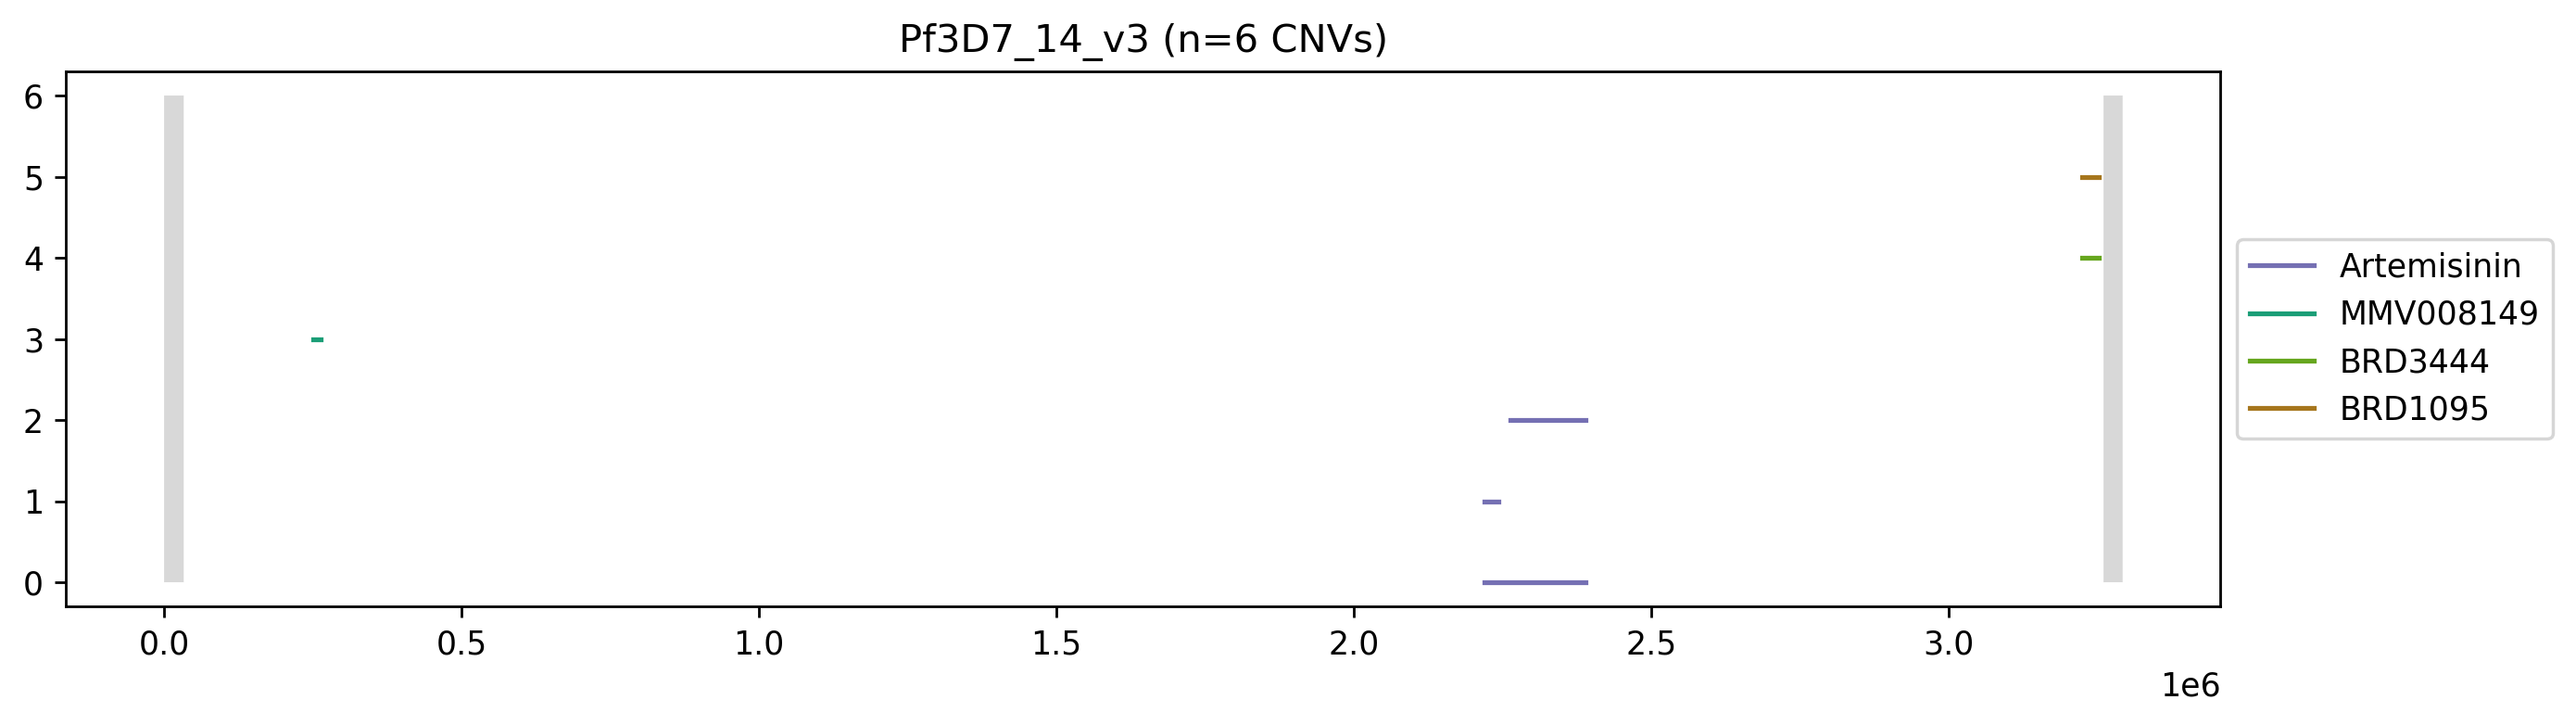

In [70]:
# Visualize where CNVs are found
fig, ax = plt.subplots(figsize=(12, 3))

chrom = chromosomes14[13]
y = 0

chrom_compounds = set(chrom_compound_interval_dict[chrom].keys())
compound_color_dict = {}
for i, compound in enumerate(chrom_compounds):
    compound_color_dict[compound] = cmap(i/float(len(chrom_compounds)))

for compound in chrom_compound_interval_dict[chrom]:
    for start, end in chrom_compound_interval_dict[chrom][compound]:
        ax.plot([start, end], [y, y], '-', label=compound, color=compound_color_dict[compound])
        y += 1
ax.set_title("%s (n=%i CNVs)" % (chrom, y))
for noncore_start, noncore_end in chrom_noncore_regions_dict[chrom]:
    ax.fill_between(range(noncore_start, noncore_end+1), 0, y, color='gray', alpha=0.3, edgecolor=None, zorder=-5)

handles, labels = ax.get_legend_handles_labels()
label_handle_dict = {}
for label, handle in zip(labels, handles):
    label_handle_dict[label] = handle
ax.legend(label_handle_dict.values(), label_handle_dict.keys(), 
             loc='center left', bbox_to_anchor=(1, 0.5))

# Filtering method 1: any support

In [47]:
# Final filtering

clone_CNV_full_validation_dict = defaultdict(dict)
for clone in clone_CNV_dict:
    for chrom in clone_CNV_dict[clone]:
        clone_CNV_full_validation_dict[clone][chrom] = defaultdict(bool)

# Validate anything with enough coverage by high quality DELLY CNVs
quality_threshold = 30
coverage_threshold = 0.6

# Validate anything with low enough P-value
pval_threshold = 1e-6

# Validate tandem duplications
tandem_dup_support_threshold = 4

# Setup output table
output_f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/CNV_multi_validation_results_filtered.tsv', 'w')

output_f.write('''DELLY quality threshold: %i
DELLY proportion coverage threshold: %s
P-value threshold: %s
Tandem duplication support threshold: %i\n''' % (quality_threshold, str(coverage_threshold),
                                                 str(pval_threshold), tandem_dup_support_threshold))

header_items = ['Clone', 'Compound', 'Strain', 'Chrom', 'Start', 'End', 'CNV type', 
                'P-value', 'Tandem duplication support', 'DELLY overlap proportion']
output_f.write('\t'.join(header_items) + '\n')

for clone in clone_CNV_dict:    
    for chrom in clone_CNV_dict[clone]:
        for CNV in clone_CNV_dict[clone][chrom]:
            
            CNV_type = clone_CNV_dict[clone][chrom][CNV]
            start, end = CNV            
            size = end - start
            
            total_overlap_bp = 0            
            for match_CNV in DELLY_clone_CNV_dict[clone][chrom]:
                quality = DELLY_clone_CNV_quality_dict[clone][chrom][match_CNV]
                match_CNV_type = DELLY_clone_CNV_dict[clone][chrom][match_CNV]
                if CNV_type == match_CNV_type and quality >= quality_threshold:
                    total_overlap_bp += getOverlap(CNV, match_CNV)
            
            prop_covered = (total_overlap_bp/float(size))
            if prop_covered > coverage_threshold:
                clone_CNV_full_validation_dict[clone][chrom][CNV] = True
            
            classification, support = clone_CNV_heuristic_validation_dict[clone][chrom][CNV]
            pval = clone_CNV_pval_dict[clone][(chrom, CNV[0], CNV[1])]
            
            if ('TANDEM DUP' in classification and support >= tandem_dup_support_threshold) or pval < pval_threshold:
                    clone_CNV_full_validation_dict[clone][chrom][CNV] = True
            
            if clone_CNV_full_validation_dict[clone][chrom][CNV]:
                items = [clone, compound, strain, chrom, start, end, CNV_type, pval, support, prop_covered]
                output_f.write('\t'.join([str(item) for item in items]) + '\n')

output_f.close()

# Filtering method 2: all support

In [174]:
# Final filtering

clone_CNV_full_validation_dict = defaultdict(dict)
for clone in clone_CNV_dict:
    for chrom in clone_CNV_dict[clone]:
        clone_CNV_full_validation_dict[clone][chrom] = defaultdict(bool)

# Validate anything with enough coverage by high quality DELLY CNVs
quality_threshold = 30
coverage_threshold = 0.6

# Validate anything with low enough P-value
pval_threshold = 1e-6

# Validate tandem duplications
tandem_dup_support_threshold = 4

# Setup output table
output_f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/CNV_multi_validation_results_filtered.tsv', 'w')

output_f.write('''DELLY quality threshold: %i
DELLY proportion coverage threshold: %s
P-value threshold: %s
Tandem duplication support threshold: %i\n''' % (quality_threshold, str(coverage_threshold),
                                                 str(pval_threshold), tandem_dup_support_threshold))

header_items = ['Clone', 'Compound', 'Strain', 'Chrom', 'Start', 'End', 'CNV type', 
                'P-value', 'Tandem duplication support', 'DELLY overlap proportion']
output_f.write('\t'.join(header_items) + '\n')

for clone in clone_CNV_dict:    
    for chrom in clone_CNV_dict[clone]:
        for CNV in clone_CNV_dict[clone][chrom]:
            
            CNV_type = clone_CNV_dict[clone][chrom][CNV]
            start, end = CNV            
            size = end - start
            
            total_overlap_bp = 0            
            for match_CNV in DELLY_clone_CNV_dict[clone][chrom]:
                quality = DELLY_clone_CNV_quality_dict[clone][chrom][match_CNV]
                match_CNV_type = DELLY_clone_CNV_dict[clone][chrom][match_CNV]
                if CNV_type == match_CNV_type and quality >= quality_threshold:
                    total_overlap_bp += getOverlap(CNV, match_CNV)
            
            # Check support
            DELLY_support, tandem_dup_support, pval_support = (False, False, False)
            
            prop_covered = (total_overlap_bp/float(size))
            if prop_covered > coverage_threshold:
                DELLY_support = True
            
            classification, support = clone_CNV_heuristic_validation_dict[clone][chrom][CNV]
            pval = clone_CNV_pval_dict[clone][chrom][CNV]
            
            if ('TANDEM DUP' in classification and support >= tandem_dup_support_threshold):
                tandem_dup_support = True
            
            if pval < pval_threshold:
                pval_support = True
            
            if DELLY_support and tandem_dup_support and pval_support:
                clone_CNV_full_validation_dict[clone][chrom][CNV] = True
            
            if clone_CNV_full_validation_dict[clone][chrom][CNV]:
                items = [clone, compound, strain, chrom, start, end, CNV_type, pval, support, prop_covered]
                output_f.write('\t'.join([str(item) for item in items]) + '\n')

output_f.close()

# Characterize filtered CNVs

# Amplified gene characteristics

In [23]:
def mergeIntervals(mintervals):
    # Sort the array on the basis of start values of intervals.
    intervals = sorted(mintervals)
    stack = []
    # insert first interval into stack
    stack.append(intervals[0])
    for i in intervals[1:]:
        # Check for overlapping interval,
        # if interval overlap
        if stack[-1][0] <= i[0] <= stack[-1][-1]:
            stack[-1][-1] = max(stack[-1][-1], i[-1])
        else:
            stack.append(i)
    
    return stack

core_genome_len = 0
for chrom in chromosomes14:
    for start, end in chrom_core_regions_dict[chrom]:
        core_genome_len += (end-start+1)

def compute_five_num_summary(values):
    return np.min(values), np.quantile(values, 0.25), np.median(values), np.quantile(values, 0.75), np.max(values)

In [24]:
chrom_CNV_regions_dict = defaultdict(list) # chrom -> list of (start, end)
CNV_gene_count_dict = defaultdict(int)
amplified_gene_count_dict = defaultdict(int)
deleted_gene_count_dict = defaultdict(int)
num_deletions = 0; num_amplifications = 0
clones = set(); compounds = set()
clone_num_CNV_dict = defaultdict(int)

for clone in clone_master_CNV_dict:
    for chrom in clone_master_CNV_dict[clone]:
        for CNV in clone_master_CNV_dict[clone][chrom]:
            CNV_type = clone_master_CNV_dict[clone][chrom][CNV]
            start, end = CNV
            
            if clone_filtered_CNV_validation_dict[clone][chrom][CNV] is True:
                chrom_CNV_regions_dict[chrom].append([start, end])
                clones.add(clone)
                compounds.add(clone_compound_dict[clone])
                clone_num_CNV_dict[clone] += 1

                if CNV_type == 'deletion':
                    num_deletions += 1
                elif CNV_type == 'amplification':
                    num_amplifications += 1

                for gene in interval_to_genes(chrom, start, end, desc=False):
                    CNV_gene_count_dict[gene] += 1
                    if CNV_type == 'deletion':
                        deleted_gene_count_dict[gene] += 1
                    elif CNV_type == 'amplification':
                        amplified_gene_count_dict[gene] += 1

for chrom in chrom_CNV_regions_dict:
    intervals = chrom_CNV_regions_dict[chrom]
    chrom_CNV_regions_dict[chrom] = mergeIntervals(intervals)

print("%i CNVs, %i deletions, %i amplifications" % (num_deletions+num_amplifications, num_deletions, num_amplifications))
print("%i clones, %i compounds" % (len(clones), len(compounds)))
print("%i clones with 1 CNV" % list(clone_num_CNV_dict.values()).count(1))
print("%i clones with 2 CNVs" % list(clone_num_CNV_dict.values()).count(2))
print(compute_five_num_summary(list(clone_num_CNV_dict.values())))

364 CNVs, 0 deletions, 364 amplifications
280 clones, 72 compounds
223 clones with 1 CNV
44 clones with 2 CNVs
(1, 1.0, 1.0, 1.0, 7)


In [25]:
# Percentage of nuclear genome covered vs. not covered by CNV

total_len = 0
for chrom in chrom_CNV_regions_dict:
    for start, end in chrom_CNV_regions_dict[chrom]:
        total_len += (end-start)+1

print("%s covered by CNV" % str(total_len/float(core_genome_len)))

0.16772016450753752 covered by CNV


In [26]:
# Essentiality of amplified genes / deleted genes

amplified_CNV_gene_mutidxs = []; amplified_num_CNV_genes = 0
amplified_nonCNV_gene_mutidxs = []; amplified_num_nonCNV_genes = 0

deleted_CNV_gene_mutidxs = []; deleted_num_CNV_genes = 0
deleted_nonCNV_gene_mutidxs = []; deleted_num_nonCNV_genes = 0

for gene in all_genes:
    
    if gene in gene_mutagenesis_idx_dict:
        mutidx = gene_mutagenesis_idx_dict[gene]
        
        if gene in amplified_gene_count_dict:
            amplified_CNV_gene_mutidxs.append(mutidx)
            amplified_num_CNV_genes += 1
        else:
            amplified_nonCNV_gene_mutidxs.append(mutidx)
            amplified_num_nonCNV_genes += 1
        
        if gene in deleted_gene_count_dict:
            deleted_CNV_gene_mutidxs.append(mutidx)
            deleted_num_CNV_genes += 1
        else:
            deleted_nonCNV_gene_mutidxs.append(mutidx)
            deleted_num_nonCNV_genes += 1

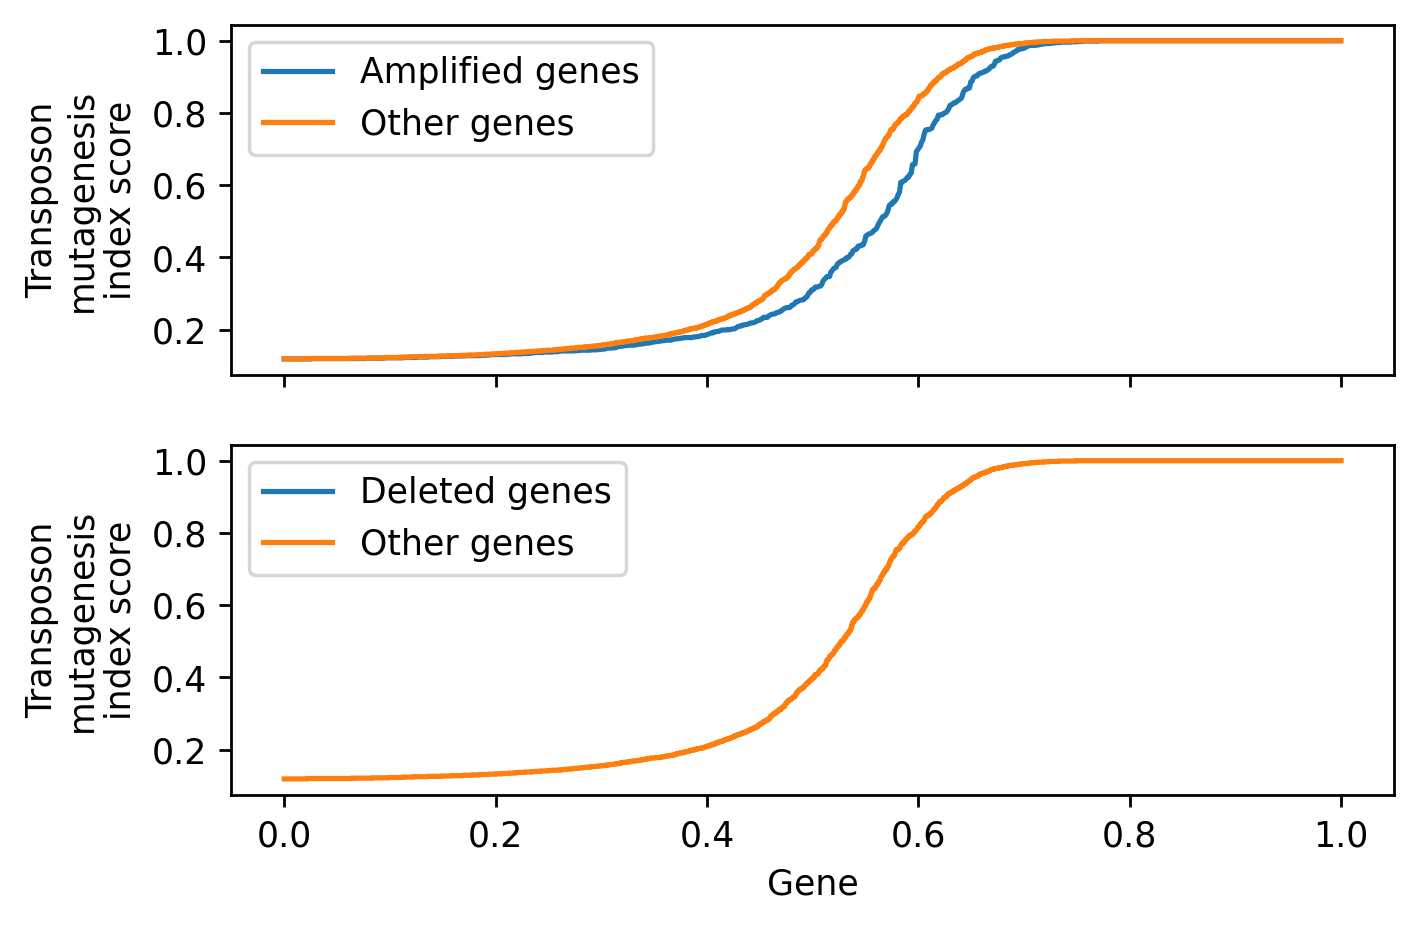

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(np.arange(amplified_num_CNV_genes)/amplified_num_CNV_genes, 
        sorted(amplified_CNV_gene_mutidxs), label="Amplified genes")
ax[0].plot(np.arange(amplified_num_nonCNV_genes)/amplified_num_nonCNV_genes, 
        sorted(amplified_nonCNV_gene_mutidxs), label="Other genes")

ax[1].plot(np.arange(deleted_num_CNV_genes)/deleted_num_CNV_genes, 
        sorted(deleted_CNV_gene_mutidxs), label="Deleted genes")
ax[1].plot(np.arange(deleted_num_nonCNV_genes)/deleted_num_nonCNV_genes, 
        sorted(deleted_nonCNV_gene_mutidxs), label="Other genes")

ax[0].legend()
ax[0].set_ylabel("Transposon\nmutagenesis\nindex score")
ax[1].set_ylabel("Transposon\nmutagenesis\nindex score")
ax[1].set_xlabel("Gene")
ax[1].legend()

In [28]:
num_amplifications_list = []
num_deletions_list = []
mutidxs_list = []

for gene in all_genes:    
    if gene in gene_mutagenesis_idx_dict:
        mutidxs_list.append(gene_mutagenesis_idx_dict[gene])
        num_amplifications_list.append(amplified_gene_count_dict[gene])        
        num_deletions_list.append(deleted_gene_count_dict[gene])

Text(0, 0.5, 'Transposon mutagenesis\nindex score')

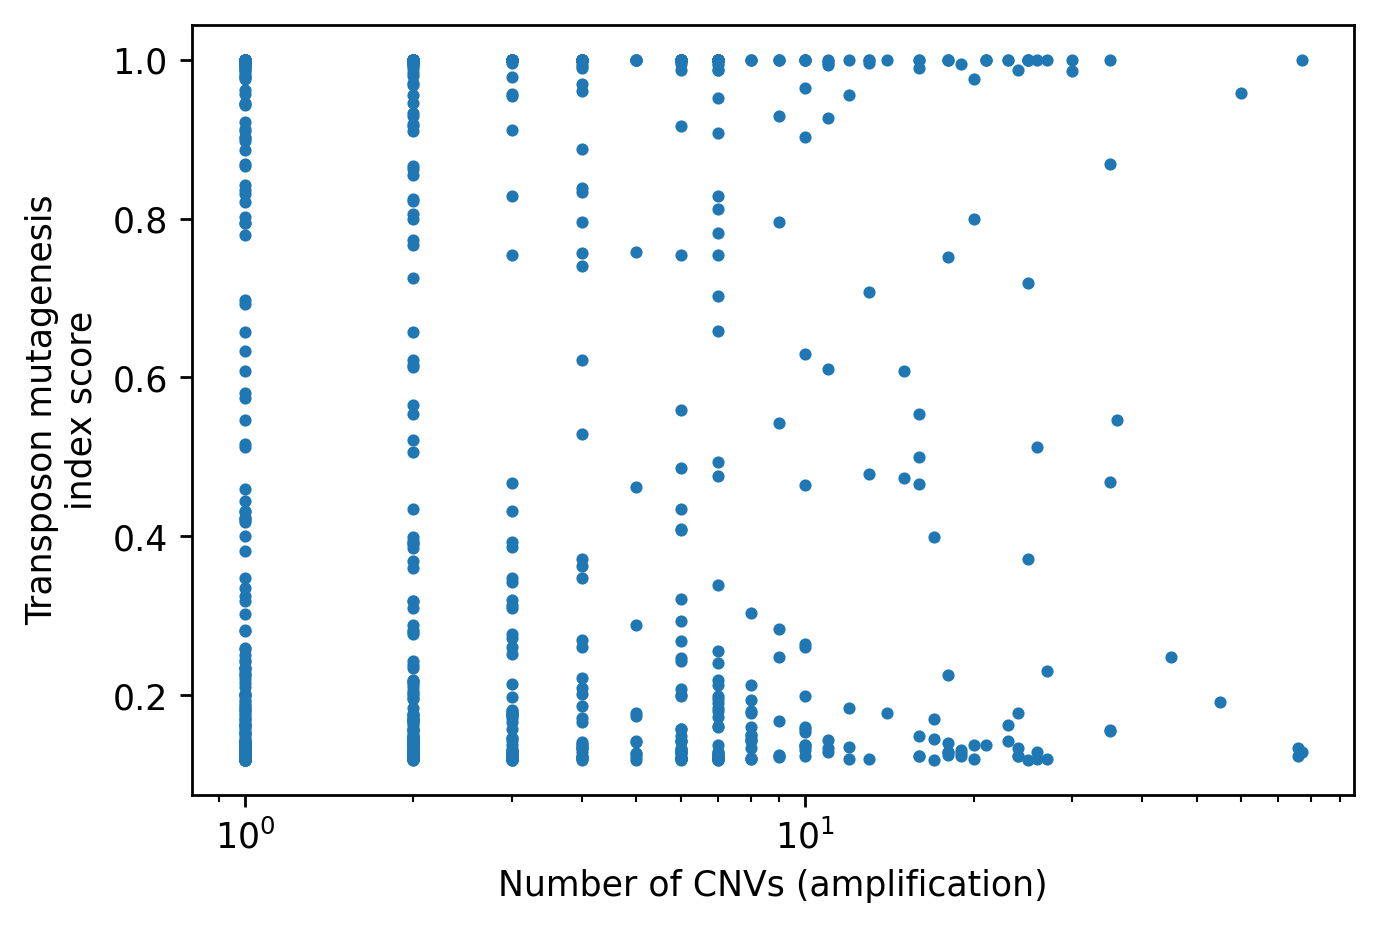

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(num_amplifications_list, mutidxs_list, '.', markersize=5)
# ax.plot(num_deletions_list, mutidxs_list, '.')
ax.set_xscale('log')
ax.set_xlabel("Number of CNVs (amplification)")
ax.set_ylabel("Transposon mutagenesis\nindex score")

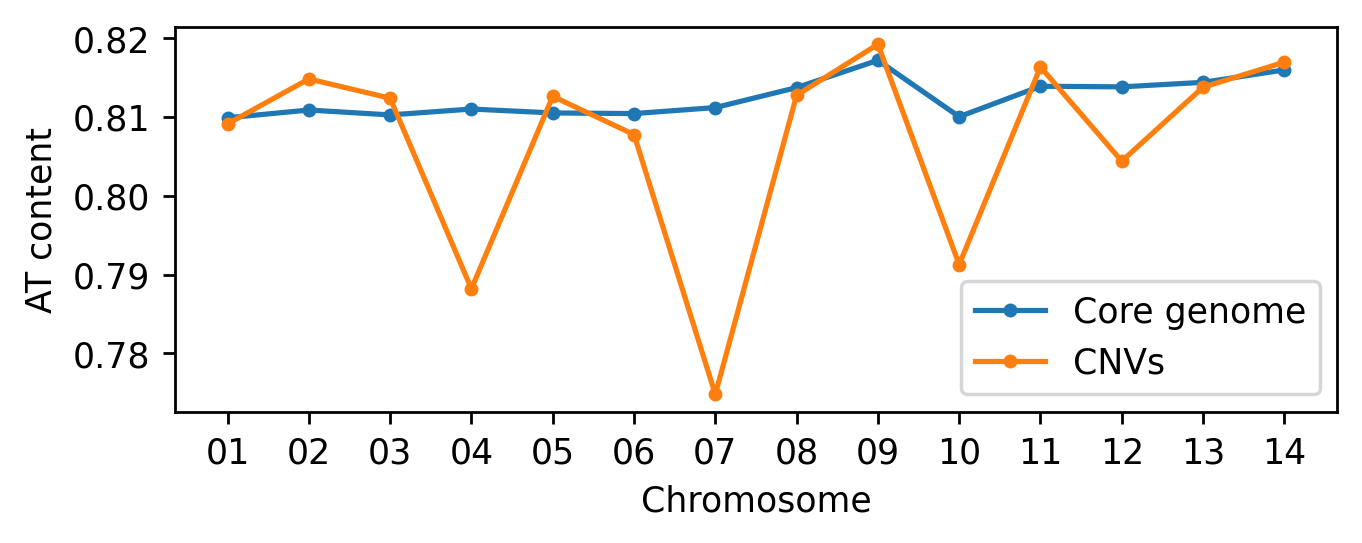

In [30]:
# AT content of CNVs

CNV_chrom_AT_content_dict = {}
core_chrom_AT_content_dict = {}

for chrom in chrom_CNV_regions_dict:
    intervals = chrom_CNV_regions_dict[chrom]
    AT_content = get_AT_content(chrom, intervals)
    CNV_chrom_AT_content_dict[chrom] = AT_content

for chrom in chrom_core_regions_dict:
    intervals = chrom_core_regions_dict[chrom]
    AT_content = get_AT_content(chrom, intervals)
    core_chrom_AT_content_dict[chrom] = AT_content

CNV_AT_list = []; core_AT_list = []
chr_labels = [cname.split('Pf3D7_')[1].split('_v3')[0] for cname in sorted(CNV_chrom_AT_content_dict.keys())]

for chrom in sorted(CNV_chrom_AT_content_dict.keys()):
    CNV_AT_list.append(CNV_chrom_AT_content_dict[chrom])
    core_AT_list.append(core_chrom_AT_content_dict[chrom])

fig, ax = plt.subplots(figsize=(6, 2))
xs = np.arange(1, len(CNV_chrom_AT_content_dict)+1)
ax.plot(xs, core_AT_list, '.-', label="Core genome")
ax.plot(xs, CNV_AT_list, '.-', label="CNVs")
ax.set_xticks(xs)
ax.set_xticklabels(chr_labels)
ax.set_xlabel("Chromosome")
ax.set_ylabel("AT content")
ax.legend()

# Boundary/breakpoint characteristics

In [190]:
multigene_members = ["PfEMP", "rifin", "MC-2TM", "stevor"]
def distance_to_nearest_multigene(chrom, pos):
    min_distance = chrom_length_dict[chrom]
    for noncore_start, noncore_end in chrom_noncore_regions_dict[chrom]:
        distance = min(np.abs(pos - noncore_start), np.abs(pos - noncore_end))
        if distance < min_distance:
            min_distance = distance
    
    for gene_start, gene_end in chrom_interval_gene_dict[chrom]:
        for multigene_keyword in multigene_members:
            if multigene_keyword in chrom_interval_gene_dict[chrom][(gene_start, gene_end)][1]:
                distance = min(np.abs(pos - gene_start), np.abs(pos - gene_end))
                if distance < min_distance:
                    min_distance = distance
    
    return min_distance

def distance_category(distance):
    if distance <= 1000:
        return '1000'
    elif distance <= 10000:
        return '10000'
    elif distance <= 100000:
        return '100000'
    elif distance <= 500000:
        return '500000'
    else:
        return '>500000'

In [29]:
# Firstly look at all filtered CNVs
# Annotate CNVs by how close they are to hypervariable regions/multigene families

breakpoint_distance_to_multigene_list = []
breakpoint_distance_category_count_dict = defaultdict(int)

for clone in clone_master_CNV_dict:
    for chrom in clone_master_CNV_dict[clone]:
        for CNV in clone_master_CNV_dict[clone][chrom]:
            start, end = CNV
            if clone_filtered_CNV_validation_dict[clone][chrom][CNV] is True: # Filtered CNV
                start_distance = distance_to_nearest_multigene(chrom, start)
                end_distance = distance_to_nearest_multigene(chrom, end)
                breakpoint_distance_to_multigene_list.append(start_distance)
                breakpoint_distance_to_multigene_list.append(end_distance)
                for distance in [start_distance, end_distance]:
                    distcat = distance_category(distance)
                    breakpoint_distance_category_count_dict[distcat] += 1

In [30]:
core_genome_multigene_dist_dict = defaultdict(int)
core_genome_distance_to_multigene_list = []
for chrom in tqdm(chrom_core_regions_dict):
    for start, end in chrom_core_regions_dict[chrom]:
        midpoint = int((start + end)/2)        
        for pos in range(start, midpoint):
            distance = pos - start
            core_genome_distance_to_multigene_list.append(distance)
            core_genome_multigene_dist_dict[distance_category(distance)] += 1
        for pos in range(midpoint, end+1):
            distance = end - pos
            core_genome_distance_to_multigene_list.append(distance)
            core_genome_multigene_dist_dict[distance_category(distance)] += 1

100%|█████████████████████████████████████████████| 14/14 [00:09<00:00,  1.54it/s]


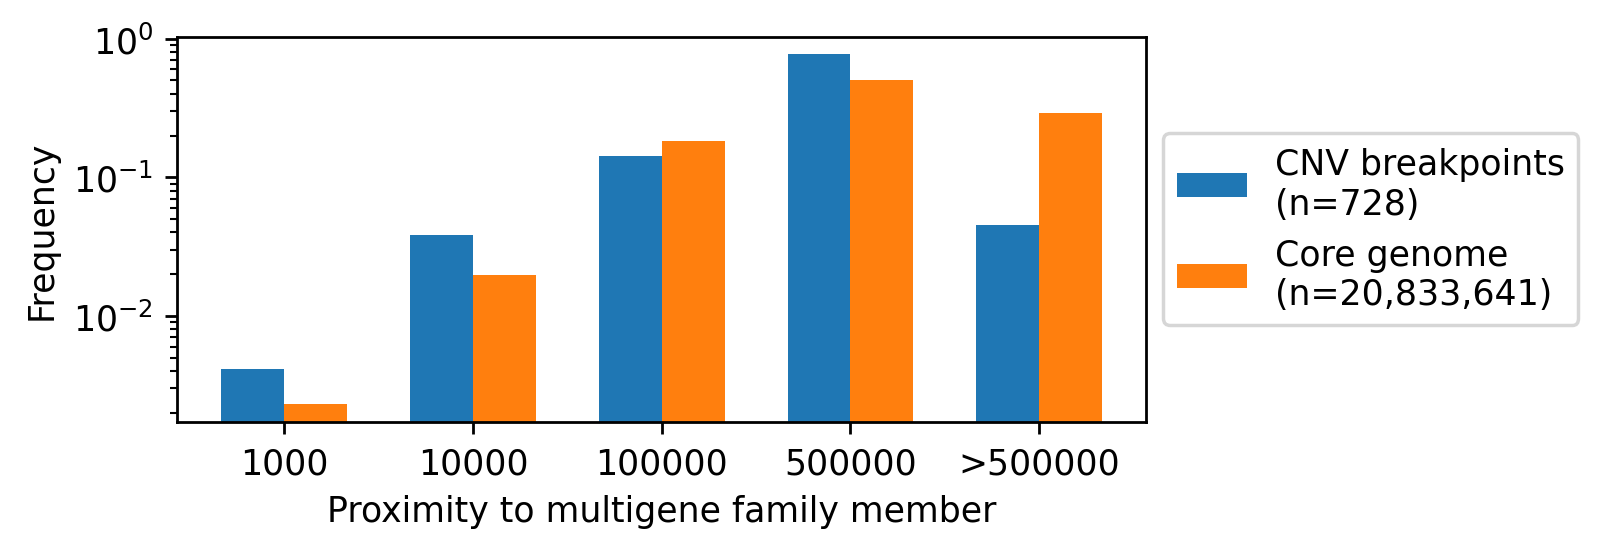

In [31]:
fig, ax = plt.subplots(figsize=(5, 2))

cat_list = ['1000', '10000', '100000', '500000', '>500000']
breakpoint_class_dist = []
core_genome_class_dist = []
total_num_breakpoints = sum(breakpoint_distance_category_count_dict.values())
total_core_genome_size = sum(core_genome_multigene_dist_dict.values())

for cat in cat_list:
    breakpoint_class_dist.append(breakpoint_distance_category_count_dict[cat]/float(total_num_breakpoints))
    core_genome_class_dist.append(core_genome_multigene_dist_dict[cat]/float(total_core_genome_size))

xs = 1.5*np.arange(len(cat_list))
ax.bar(xs, breakpoint_class_dist, width=0.5, label="CNV breakpoints\n(n=%i)" % total_num_breakpoints)
ax.bar(xs+0.5, core_genome_class_dist, width=0.5, label="Core genome\n(n={:,})".format(total_core_genome_size))
ax.set_xticks(xs+0.25)
ax.set_xticklabels(cat_list)
ax.set_xlabel("Proximity to multigene family member")
ax.set_ylabel("Frequency")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale('log')

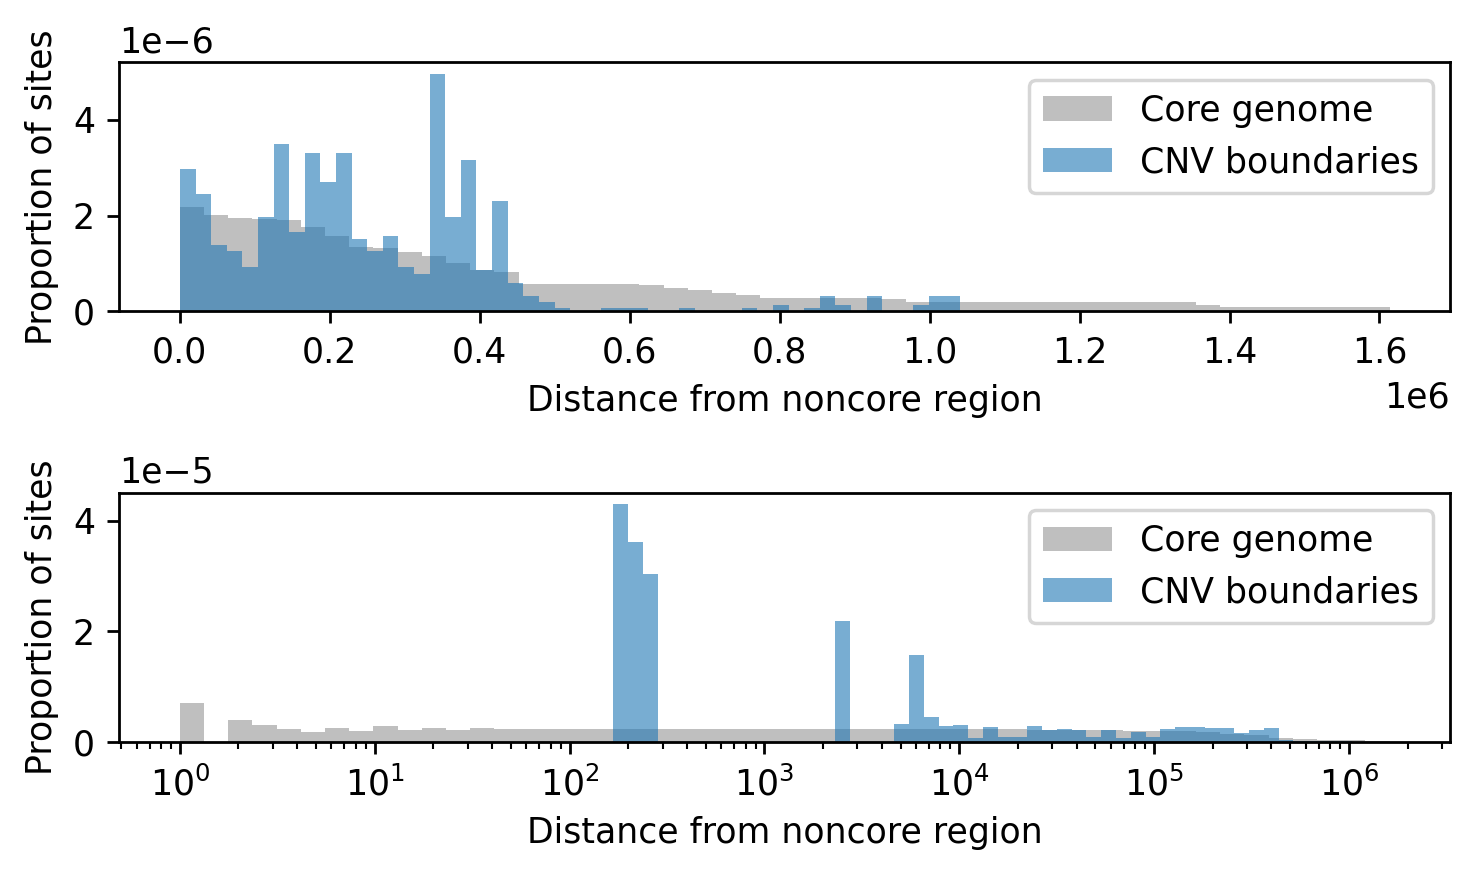

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(6, 3.6))

core_genome_distance_to_multigene_list = [d for d in core_genome_distance_to_multigene_list if d != 0]

hist, bins, _ = ax[0].hist(core_genome_distance_to_multigene_list, bins=50, density=True, alpha=0.5, color='gray', label="Core genome")
ax[1].hist(core_genome_distance_to_multigene_list, bins=np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins)),
        density=True, alpha=0.5, color='gray', label="Core genome")

hist, bins, _ = ax[0].hist(breakpoint_distance_to_multigene_list, bins=50, density=True, alpha=0.6, label="CNV boundaries")
ax[1].hist(breakpoint_distance_to_multigene_list, bins=np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins)),
        density=True, alpha=0.6, label="CNV boundaries")

ax[1].set_xscale('log')
ax[0].set_xlabel("Distance from noncore region"); ax[0].set_ylabel("Proportion of sites"); ax[0].legend()
ax[1].set_xlabel("Distance from noncore region"); ax[1].set_ylabel("Proportion of sites"); ax[1].legend()
plt.tight_layout()

In [32]:
def distance_to_nearest_gene(chrom, pos):
    min_distance = chrom_length_dict[chrom]
    for gene_start, gene_end in chrom_interval_gene_dict[chrom]:
        if pos >= gene_start and pos <= gene_end:
            return 0
        else:
            distance = min([np.abs(pos-gene_start), np.abs(pos-gene_end)])
            if distance < min_distance:
                min_distance = distance
    return min_distance

In [33]:
breakpoint_classification_dict = defaultdict(int)
breakpoint_pair_classification_dict = defaultdict(int)

num_filtered_CNVs = 0
num_TD_CNVs = 0
num_confident_TD_CNVs = 0

confident_TD_CNVs = [] # List of (chrom, start, end) tuples

AT_contents = []
clone_tandemdup_distance_to_gene_dict = {clone: defaultdict(dict) for clone in final_clones}

breakpoint_seqs = []
start_breakpoints = []
end_breakpoints = []

# Get subset of CNVs with confident breakpoints
for clone in clone_master_CNV_dict:
    for chrom in clone_master_CNV_dict[clone]:
        intervals = []
        for CNV in clone_master_CNV_dict[clone][chrom]:
            if clone_independent_CNV_validation_dict[clone][chrom][CNV] is True: # Filtered CNV (should this be independent?)
                num_filtered_CNVs += 1
                
                if CNV in clone_tandemdup_revised_boundaries_dict[clone][chrom]: # Tandem duplication (uncombined)
                    num_TD_CNVs += 1
                    
                    TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][CNV]
                    newstart, newend = clone_tandemdup_revised_boundaries_dict[clone][chrom][CNV]
                    
                    if TD_support >= 10:
                        num_confident_TD_CNVs += 1
                        confident_TD_CNVs.append((chrom, newstart, newend))
                        breakpoint_seqs.append(get_sequence(chrom, newstart, range_below=50, range_above=50, show_pos='left'))
                        breakpoint_seqs.append(get_sequence(chrom, newend, range_below=50, range_above=50, show_pos='right'))
                        start_breakpoints.append((chrom, newstart))
                        end_breakpoints.append((chrom, newend))
                        
                        start_classification = classify_position(chrom, newstart)
                        end_classification = classify_position(chrom, newstart)
                        
                        breakpoint_classification_dict[start_classification] += 1
                        breakpoint_classification_dict[end_classification] += 1
                        breakpoint_pair_classification_dict[(start_classification, end_classification)] += 1
                        
                        start_distance_to_gene = distance_to_nearest_gene(chrom, newstart)
                        end_distance_to_gene = distance_to_nearest_gene(chrom, newend)                        
                        
                        clone_tandemdup_distance_to_gene_dict[clone][chrom][CNV] = (start_distance_to_gene, end_distance_to_gene)
                        intervals.append((newstart-15, newstart+15))
                        intervals.append((newend-15, newend+15))
        
        if len(intervals) > 0:
            AT_contents.append(get_AT_content(chrom, intervals))

print("%i independent X filtered X CNVs" % num_filtered_CNVs)
print("%i are potentially tandem duplications (based on original/uncombined intervals)" % num_TD_CNVs)
print("%i are confident tandem duplications (based on original/uncombined intervals)" % num_confident_TD_CNVs)

# Characteristics of breakpoints in tandem duplications

print(np.mean(AT_contents))

240 independent X filtered X CNVs
176 are potentially tandem duplications (based on original/uncombined intervals)
142 are confident tandem duplications (based on original/uncombined intervals)
0.844388914129941


In [34]:
sorted_confident_TD_CNVs = sorted(confident_TD_CNVs, key=lambda x: (x[0], x[1], x[2]))
for tup in sorted_confident_TD_CNVs:
    print('\t'.join([str(item) for item in tup]))

Pf3D7_01_v3	264316	359397
Pf3D7_01_v3	264318	359398
Pf3D7_01_v3	264402	359409
Pf3D7_01_v3	264463	359403
Pf3D7_01_v3	264468	359392
Pf3D7_01_v3	313141	361232
Pf3D7_01_v3	321512	373087
Pf3D7_01_v3	321513	372906
Pf3D7_01_v3	322189	345944
Pf3D7_01_v3	322189	442319
Pf3D7_01_v3	344452	377739
Pf3D7_02_v3	205237	238329
Pf3D7_02_v3	422506	478667
Pf3D7_02_v3	434621	480631
Pf3D7_02_v3	480713	516017
Pf3D7_03_v3	712655	837217
Pf3D7_03_v3	712655	837228
Pf3D7_03_v3	739073	837354
Pf3D7_03_v3	782961	845517
Pf3D7_03_v3	782961	845558
Pf3D7_03_v3	782964	845564
Pf3D7_03_v3	782967	845566
Pf3D7_03_v3	782969	845564
Pf3D7_03_v3	782969	879985
Pf3D7_03_v3	794007	869573
Pf3D7_03_v3	801930	839574
Pf3D7_03_v3	802657	869797
Pf3D7_03_v3	803403	835980
Pf3D7_03_v3	803406	840553
Pf3D7_03_v3	803406	893985
Pf3D7_03_v3	803406	894014
Pf3D7_03_v3	803418	863182
Pf3D7_03_v3	807986	884748
Pf3D7_03_v3	809776	871486
Pf3D7_03_v3	809917	871488
Pf3D7_03_v3	820779	860811
Pf3D7_05_v3	364963	415846
Pf3D7_05_v3	365254	415842
Pf3D7_05_v3	

In [38]:
# Classify as:
# A-content >= 10/12, T-content >=10/12
# AT-rich >= 10/12
# Other

def categorize_subseq(subseq):
    A_content = subseq.count('A'); T_content = subseq.count('T'); AT_content = A_content + T_content
    n = len(subseq)
    if (A_content/float(n)) >= (5/6.0):
        return 'Poly-A'
    elif (T_content/float(n)) >= (5/6.0):
        return 'Poly-T'
    elif (AT_content/float(n)) >= (10/12.0):
        return 'AT_rich'
    return 'Other'

breakpoint_seq_cat_dict = defaultdict(list)
breakpoint_fullseq_cat_dict = defaultdict(list)

# Categorize the breakpoint sequences
for seq in breakpoint_seqs:
    leftseq, rightseq = seq.split('|')
    leftsubseq = leftseq[-12:]
    rightsubseq = rightseq[:12]
    left_class = categorize_subseq(leftsubseq)
    right_class = categorize_subseq(rightsubseq)
    
    breakpoint_seq_cat_dict[right_class].append(seq)
    breakpoint_seq_cat_dict[left_class].append(seq)
    
    if left_class == 'Other' and right_class == 'Other':
        breakpoint_fullseq_cat_dict['Other'].append(seq)
    elif left_class == 'AT_rich' or right_class == 'AT_rich':
        breakpoint_fullseq_cat_dict['AT_rich'].append(seq)
    elif left_class == 'Poly-A' or right_class == 'Poly-A':
        breakpoint_fullseq_cat_dict['Poly-A'].append(seq)
    elif left_class == 'Poly-T' or right_class == 'Poly-T':
        breakpoint_fullseq_cat_dict['Poly-T'].append(seq)
    else:
        breakpoint_fullseq_cat_dict['sus'].append(seq)
        

for cat in sorted(breakpoint_seq_cat_dict):
    print(cat, len(breakpoint_seq_cat_dict[cat]))

AT_rich 267
Other 188
Poly-A 54
Poly-T 59


In [39]:
# Plot AT content around CNV breakpoints

def get_AT_content_sliding_vector(seqs, window=5):
    AT_count_vector = []
    for i in range(len(seqs[0])-window+1):
        AT_count = 0; total_len = 0
        for seq in seqs:
            subseq = seq[i:i+window]
            AT_count += subseq.count('A') + subseq.count('T')
            total_len += len(subseq)
        AT_count_vector.append(AT_count/float(total_len))
    return np.array(AT_count_vector)

seq_radius = 6000; window = 100

start_breakpoint_seqs_aligned = []
for chrom, start in start_breakpoints:
    seq = get_sequence(chrom, start, range_below=seq_radius, range_above=seq_radius, show_pos='left')
    leftseq, rightseq = seq.split('|')
    start_breakpoint_seqs_aligned.append(leftseq[-seq_radius:] + rightseq[:seq_radius])    

start_breakpoint_AT_vector = get_AT_content_sliding_vector(start_breakpoint_seqs_aligned, window=window)

end_breakpoint_seqs_aligned = []
for chrom, end in end_breakpoints:
    seq = get_sequence(chrom, end, range_below=seq_radius, range_above=seq_radius, show_pos='right')
    leftseq, rightseq = seq.split('|')
    end_breakpoint_seqs_aligned.append(leftseq[-seq_radius:] + rightseq[:seq_radius])

end_breakpoint_AT_vector = get_AT_content_sliding_vector(end_breakpoint_seqs_aligned, window=window)

combined_breakpoint_seqs_aligned = start_breakpoint_seqs_aligned + end_breakpoint_seqs_aligned
combined_breakpoint_AT_vector = get_AT_content_sliding_vector(combined_breakpoint_seqs_aligned, window=window)

Text(0, 0.5, 'AT content')

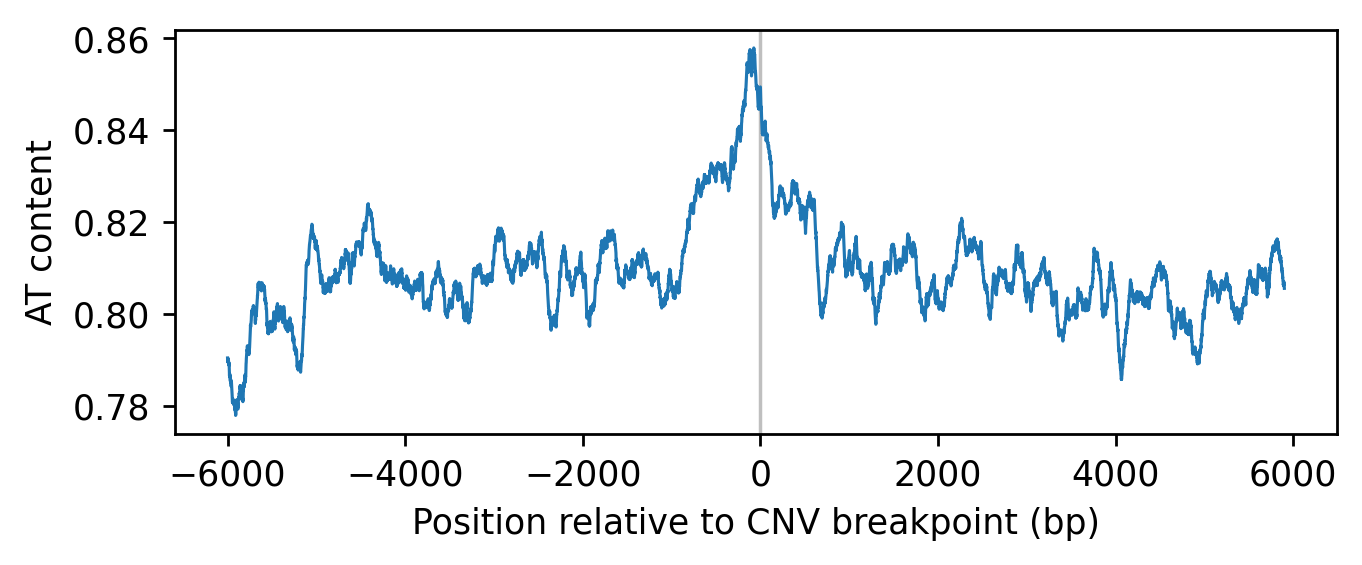

In [40]:
fig, ax = plt.subplots(figsize=(6, 2.1))
xs = np.arange(len(combined_breakpoint_AT_vector)) - seq_radius

# Write table for Prism plot
with open("/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/ind_tandemdup_breakpoint_AT_content.tsv", 'w') as f:
    f.write('\t'.join(["Relative position", "AT content"]) + '\n')
    for x, AT_content in zip(xs, combined_breakpoint_AT_vector):
        items = [x, AT_content]
        f.write('\t'.join([str(item) for item in items]) + '\n')

ax.axvline(0, linestyle='-', color='gray', alpha=0.5, linewidth=1)
ax.plot(xs, combined_breakpoint_AT_vector, linewidth=0.9)
# ax.set_title("CNV breakpoints (n=%i), sliding window %i bp" % (len(combined_breakpoint_seqs_aligned), window))
ax.set_xlabel("Position relative to CNV breakpoint (bp)"); ax.set_ylabel("AT content")

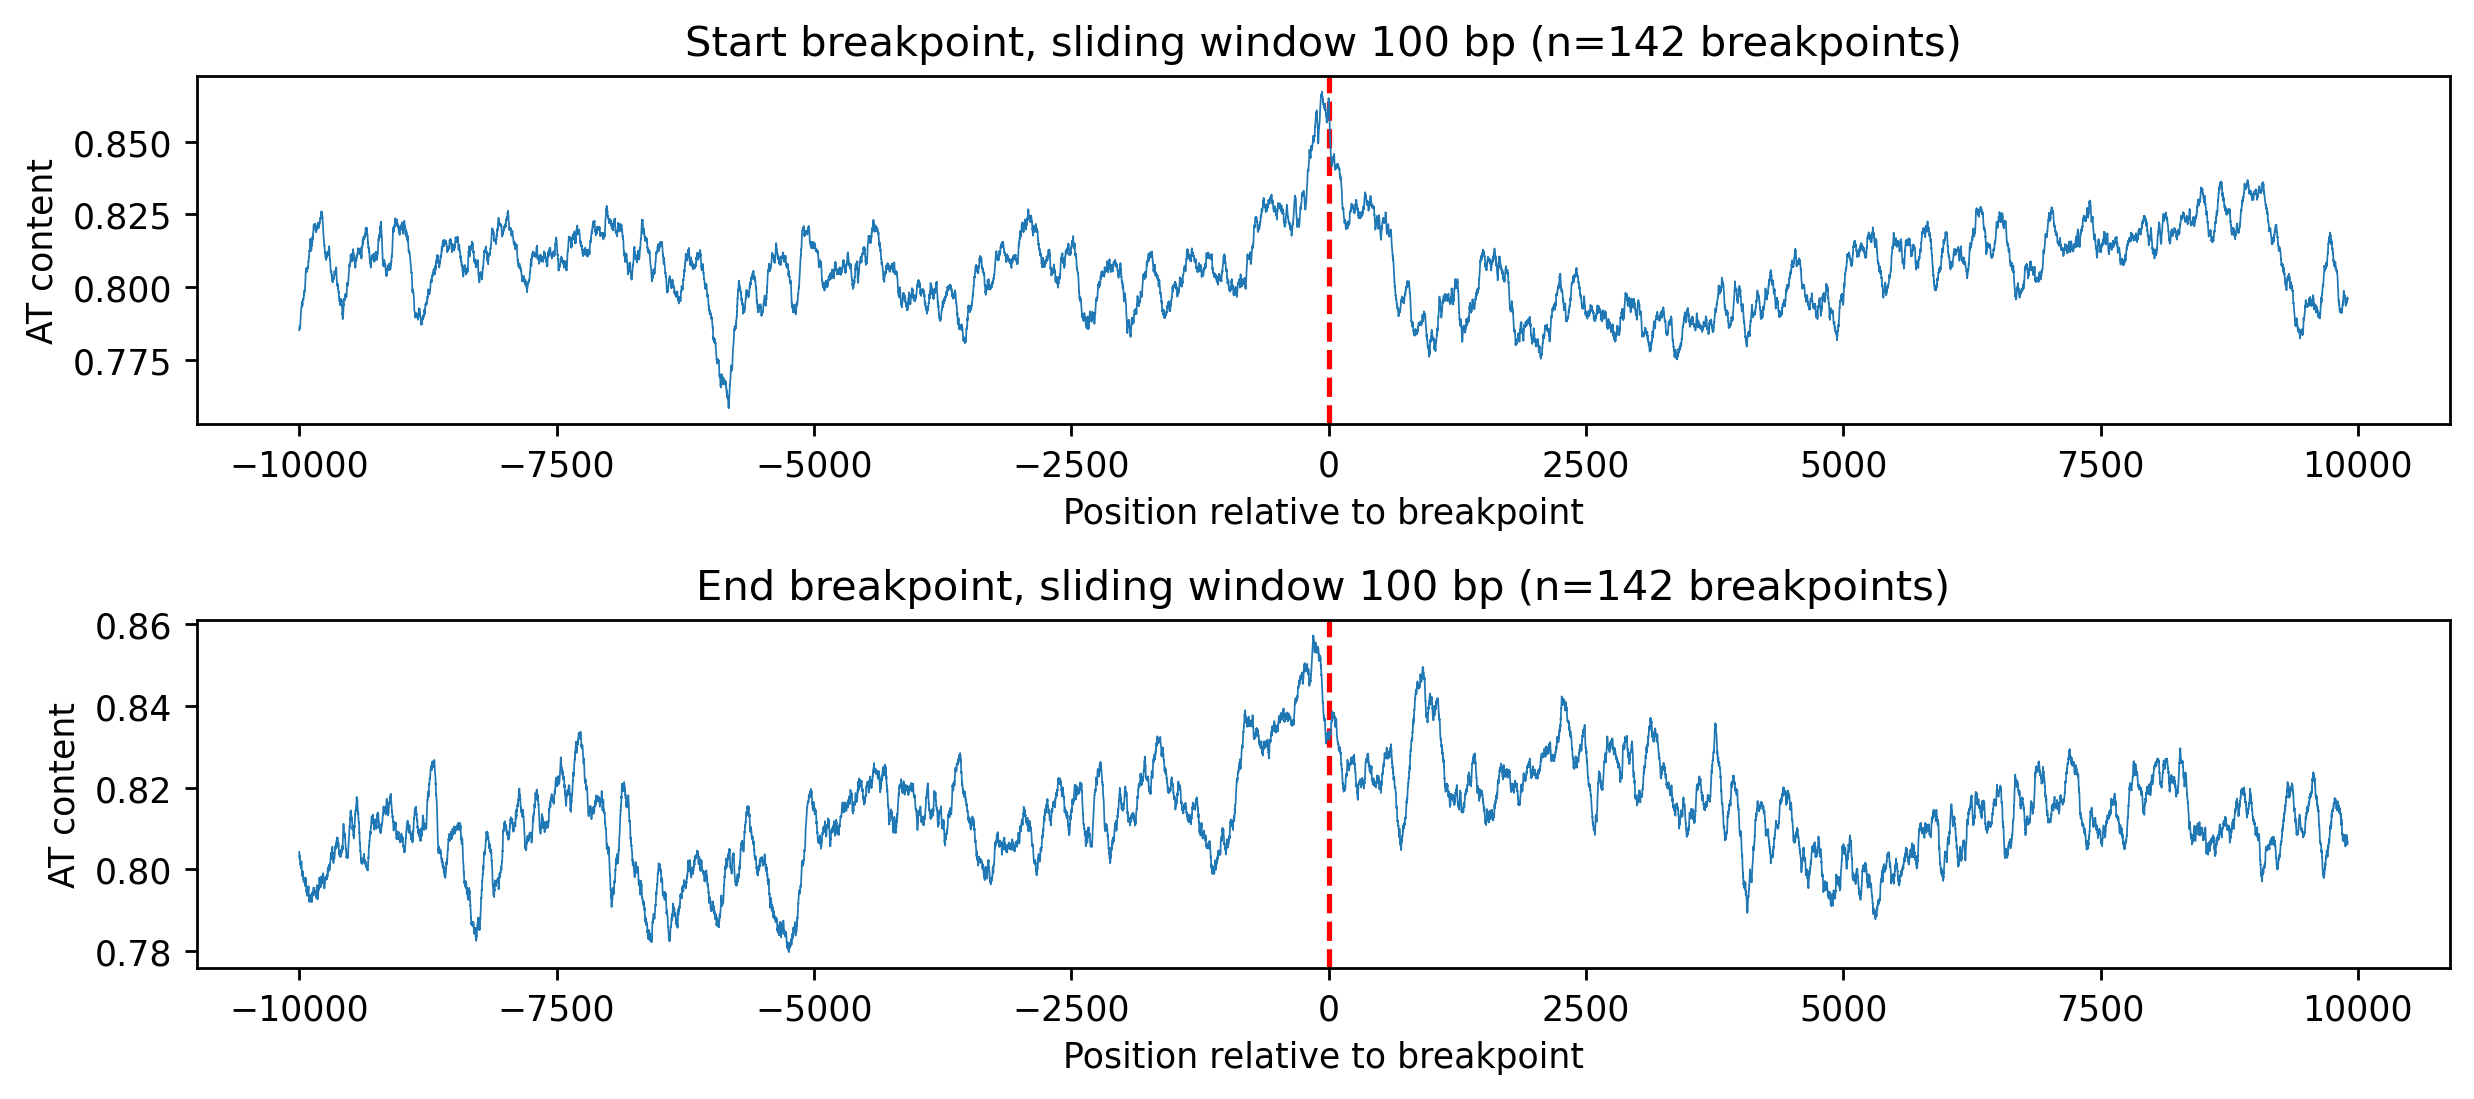

In [169]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4.5))
xs = np.arange(len(end_breakpoint_AT_vector)) - seq_radius

ax[0].axvline(0, linestyle='--', color='red')
ax[0].plot(xs, start_breakpoint_AT_vector, linewidth=0.5)
ax[0].set_title("Start breakpoint, sliding window %i bp (n=%i breakpoints)" % (window, len(start_breakpoint_seqs_aligned)))
ax[0].set_xlabel("Position relative to breakpoint"); ax[0].set_ylabel("AT content")

ax[1].axvline(0, linestyle='--', color='red')
ax[1].plot(xs, end_breakpoint_AT_vector, linewidth=0.5)
ax[1].set_title("End breakpoint, sliding window %i bp (n=%i breakpoints)" % (window, len(end_breakpoint_seqs_aligned)))
ax[1].set_xlabel("Position relative to breakpoint"); ax[1].set_ylabel("AT content")

plt.tight_layout()

In [170]:
# How about sequence repetitiveness?
# See https://academic.oup.com/bib/article/22/3/bbaa086/5855256

def repetitiveness(seq, k=5):
    overall_kmer_count_dict = defaultdict(int)
    i_kmer_count_dict = {i: defaultdict(int) for i in range(len(seq))}
    for idx in range(len(seq)-k+1):
        kmer = seq[idx:idx+k]
        overall_kmer_count_dict[kmer] += 1
        for i in range(idx, idx+k):
            i_kmer_count_dict[i][kmer] += 1
    
    rscore_vector = []
    for i in range(len(seq)):
        rscore_i = 0
        for kmer in i_kmer_count_dict[i]:
            rscore_i += overall_kmer_count_dict[kmer]
        rscore_vector.append(rscore_i)
    
    max_score = k*len(seq)
    return np.array(rscore_vector)/float(max_score)

seq_radius = 10000; window = 100

# Start
start_breakpoint_seqs_aligned = []
for chrom, start in start_breakpoints:
    seq = get_sequence(chrom, start, range_below=seq_radius, range_above=seq_radius, show_pos='left')
    leftseq, rightseq = seq.split('|')
    start_breakpoint_seqs_aligned.append(leftseq[-seq_radius:] + rightseq[:seq_radius])

start_avg_r_vector = np.zeros(seq_radius*2)
for seq in start_breakpoint_seqs_aligned:
    start_avg_r_vector = np.add(start_avg_r_vector, repetitiveness(seq))
start_avg_r_vector /= len(start_breakpoint_seqs_aligned)

start_avg_r_running_avg = []
for i in range(len(start_avg_r_vector)-window+1):
    start_avg_r_running_avg.append(np.mean(start_avg_r_vector[i:i+window]))

# End
end_breakpoint_seqs_aligned = []
for chrom, end in end_breakpoints:
    seq = get_sequence(chrom, end, range_below=seq_radius, range_above=seq_radius, show_pos='right')
    leftseq, rightseq = seq.split('|')
    end_breakpoint_seqs_aligned.append(leftseq[-seq_radius:] + rightseq[:seq_radius])

end_avg_r_vector = np.zeros(seq_radius*2)
for seq in end_breakpoint_seqs_aligned:
    end_avg_r_vector = np.add(end_avg_r_vector, repetitiveness(seq))
end_avg_r_vector /= len(end_breakpoint_seqs_aligned)

end_avg_r_running_avg = []
for i in range(len(end_avg_r_vector)-window+1):
    end_avg_r_running_avg.append(np.mean(end_avg_r_vector[i:i+window]))

# Combined
combined_breakpoint_seqs_aligned = start_breakpoint_seqs_aligned + end_breakpoint_seqs_aligned

combined_avg_r_vector = np.zeros(seq_radius*2)
for seq in combined_breakpoint_seqs_aligned:
    combined_avg_r_vector = np.add(combined_avg_r_vector, repetitiveness(seq))
combined_avg_r_vector /= len(combined_breakpoint_seqs_aligned)

combined_avg_r_running_avg = []
for i in range(len(combined_avg_r_vector)-window+1):
    combined_avg_r_running_avg.append(np.mean(combined_avg_r_vector[i:i+window]))

Text(0, 0.5, 'Repetitiveness')

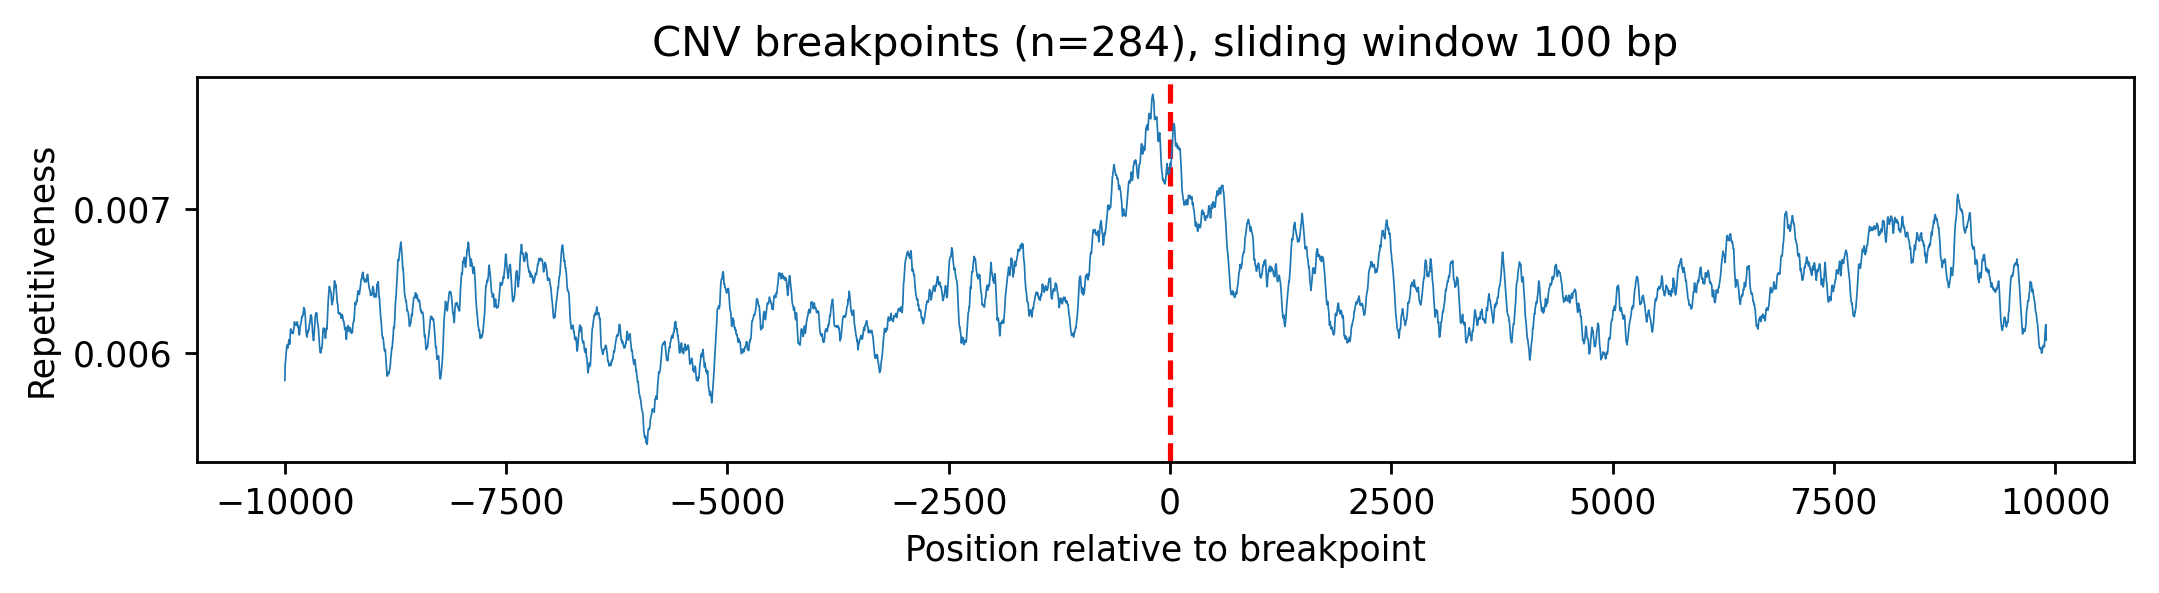

In [171]:
fig, ax = plt.subplots(figsize=(10, 2))
xs = np.arange(len(combined_avg_r_running_avg)) - seq_radius

ax.axvline(0, linestyle='--', color='red')
ax.plot(xs, combined_avg_r_running_avg, linewidth=0.5)
ax.set_title("CNV breakpoints (n=%i), sliding window %i bp" % (len(combined_breakpoint_seqs_aligned), window))
ax.set_xlabel("Position relative to breakpoint"); ax.set_ylabel("Repetitiveness")

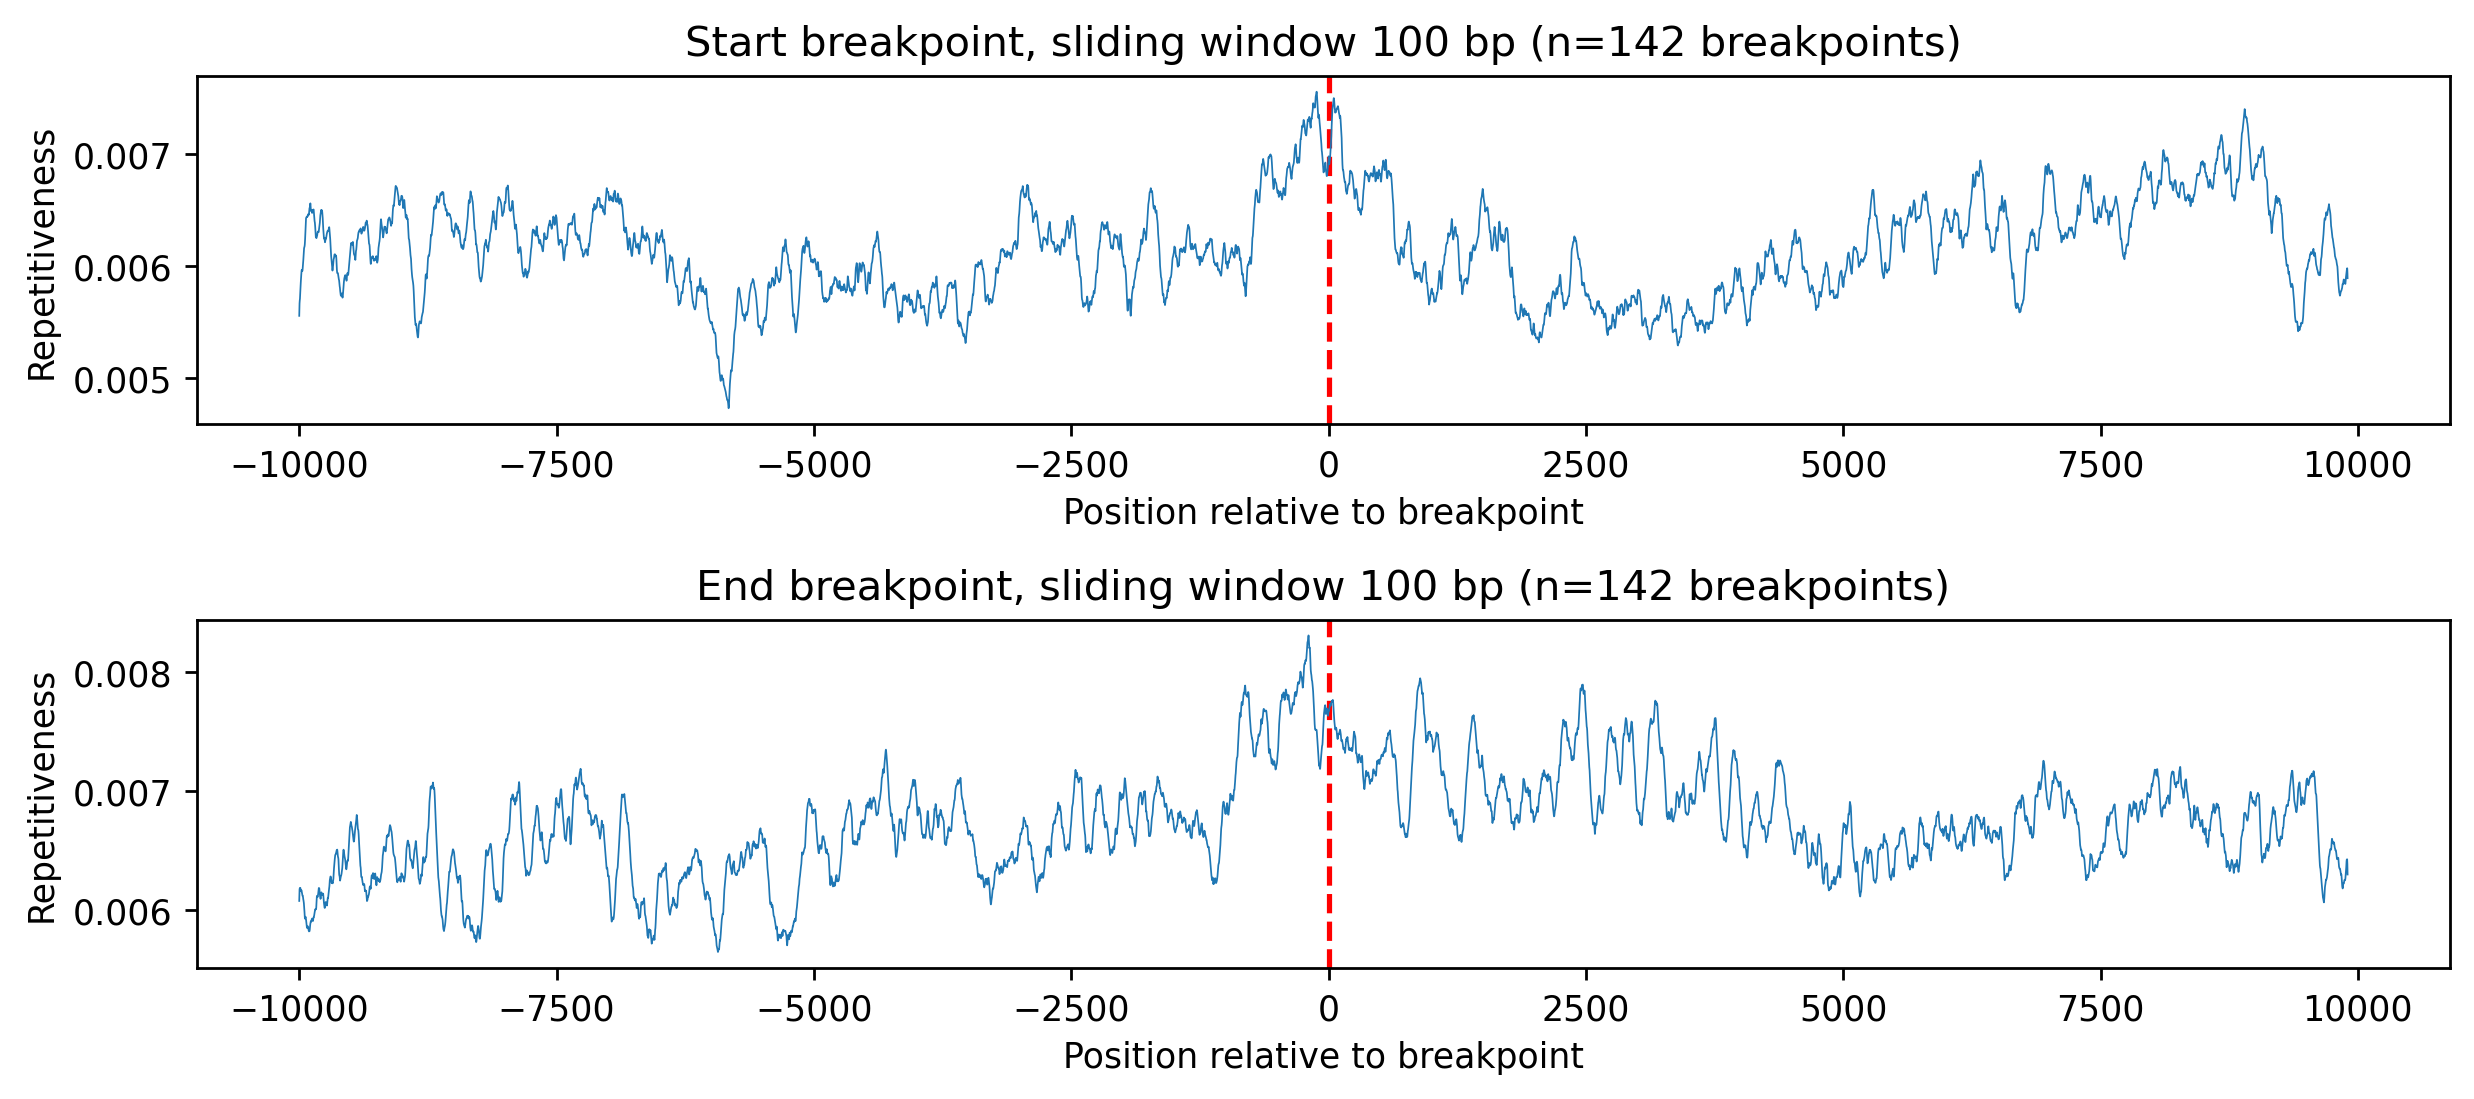

In [172]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4.5))
xs = np.arange(len(start_avg_r_running_avg)) - seq_radius

ax[0].axvline(0, linestyle='--', color='red')
ax[0].plot(xs, start_avg_r_running_avg, linewidth=0.5)
ax[0].set_title("Start breakpoint, sliding window %i bp (n=%i breakpoints)" % (window, len(start_breakpoint_seqs_aligned)))
ax[0].set_xlabel("Position relative to breakpoint"); ax[0].set_ylabel("Repetitiveness")

ax[1].axvline(0, linestyle='--', color='red')
ax[1].plot(xs, end_avg_r_running_avg, linewidth=0.5)
ax[1].set_title("End breakpoint, sliding window %i bp (n=%i breakpoints)" % (window, len(end_breakpoint_seqs_aligned)))
ax[1].set_xlabel("Position relative to breakpoint"); ax[1].set_ylabel("Repetitiveness")

plt.tight_layout()

In [ ]:
# How many times are CNV breakpoints reused?


In [36]:
for seq in breakpoint_seq_cat_dict['Poly-A']:
    print(seq)

for seq in breakpoint_seq_cat_dict['Poly-T']:
    print(seq)

for seq in breakpoint_seq_cat_dict['AT_rich']:
    print(seq)

for seq in breakpoint_seq_cat_dict['Other']:
    print(seq)

AGAATAATATAATCTCGTATTTATTCTTATATTCTAGCCATATTGAAGGG|AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATATATATATATATATATATA
GAGAATAATATAATCTCGTATTTATTCTTATATTCTAGCCATATTGAAGG|GAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATATATATATATATATATAT
AGAATAATATAATCTCGTATTTATTCTTATATTCTAGCCATATTGAAGGG|AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATATATATATATATATATATA
AACTCCGTTTTGATATTTATAAATTATAAAATGATGATTTAAACAAAAAAA|TAAAAAAAAATTATATATAACATAAATAAAAATATAAATATATTAACAGA
GAGAATAATATAATCTCGTATTTATTCTTATATTCTAGCCATATTGAAGG|GAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATATATATATATATATATAT
AATACGAAAATGGAGATATTTACATAGGCACCTCAAGAAATAAAAAAAGAA|ATGGATTTGGATACTACCTATATGTTAACATCAAAACCATATATCAAGGG
ATCGAAAATTTATTTATGCTTCTAAAAATTTGAAAAAATAATACAAACAC|AAAAAAAAAAAAAAAAAAAAAAAAAAGGAATATTATATATATAAATATATA
TAATATAAAACTTCTTTAAATCGGGAATAAATGCGACTAGCTGTAAAACA|AAAAATAAAAAATAATATAATATAATATAATATAATATAATATAATATAAT
ATACACCTAAAATAGATTTTGATATATCCCATTTAAATCAAAGAAATAAT|AAAAAAAAAAAAAAAAAAAAAAAAAAAATACAAAGTGATCAAAATAGTGTA
CATTGCTTCGTGATGAAAAAAAAAGAAAAAAAAAAAAAAAAAAATAAAAT|AAAATAAAATAAAATGAAATAA

In [39]:
for seq in breakpoint_fullseq_cat_dict['Poly-A']:
    print(seq)

for seq in breakpoint_fullseq_cat_dict['Poly-T']:
    print(seq)

for seq in breakpoint_fullseq_cat_dict['AT_rich']:
    print(seq)

for seq in breakpoint_fullseq_cat_dict['Other']:
    print(seq)

AGAATAATATAATCTCGTATTTATTCTTATATTCTAGCCATATTGAAGGG|AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATATATATATATATATATATA
GAGAATAATATAATCTCGTATTTATTCTTATATTCTAGCCATATTGAAGG|GAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATATATATATATATATATAT
AGAATAATATAATCTCGTATTTATTCTTATATTCTAGCCATATTGAAGGG|AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATATATATATATATATATATA
GAGAATAATATAATCTCGTATTTATTCTTATATTCTAGCCATATTGAAGG|GAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATATATATATATATATATAT
AATACGAAAATGGAGATATTTACATAGGCACCTCAAGAAATAAAAAAAGAA|ATGGATTTGGATACTACCTATATGTTAACATCAAAACCATATATCAAGGG
ATCGAAAATTTATTTATGCTTCTAAAAATTTGAAAAAATAATACAAACAC|AAAAAAAAAAAAAAAAAAAAAAAAAAGGAATATTATATATATAAATATATA
TAATATAAAACTTCTTTAAATCGGGAATAAATGCGACTAGCTGTAAAACA|AAAAATAAAAAATAATATAATATAATATAATATAATATAATATAATATAAT
CATTGCTTCGTGATGAAAAAAAAAGAAAAAAAAAAAAAAAAAAATAAAAT|AAAATAAAATAAAATGAAATAAAATAAAATAATAACAAAATGAAGATCAAA
AAAATATGTATTTTCTTATAAAATAATATTTAAAAAAAAAAAAAAAAAAAA|AATGAAATGCCTTGTTATAGTTGATGCACAAAATGACTTTTTACCGAACG
TATAGGACAAAATGTGTAAAAAAATACAAATAACAAAAGATGAAATATTG|AAAGAAAAAAAAAAAAAAAAAT

In [86]:
# Compare random parts of genome

for chrom in chrom_core_regions_dict:
    seq = chromosome_sequence_dict[chrom]
    print(chrom, get_AT_content(chrom, [(1, len(seq))]))
    startpos = random.randint(1, len(seq))
    subseq = seq[start_pos:(start_pos+101)]
    print(subseq)

Pf3D7_01_v3 0.7949851057422084
TTTTTCATAGGGGGGGGTATTGCTCCTGGGGCCAATTTTCTATCAAAATTTTGGTCCATTTTTTCAACTAATTGTCACAACTACTTCAATGAAAAGCTAAT
Pf3D7_02_v3 0.8025091278447306
TTCTTTATCTACATTATGATTTACTTTTATGCTTTTGTGTGCATTATGTGTTGTTTTATATGCATGGAGGTGCATTTTTTTACTTACATCGCCATTTTTAC
Pf3D7_03_v3 0.7993578477318204
TTTGTAATCTTAATCTTACCTTACTATTACTCTTTTCTTGTCCAACATAGCACTTATATGCACAATCATGTCCAACATGAGTCATTTACTACTACTTTGTT
Pf3D7_04_v3 0.7948512690651317
CTATACATAAAAAATGGTACTATATGTGTGCAACTATGTCTATATTTTGTGTGCACTTCAATTTTCCTTCATAGTCCATTTTCCCCTAGCACTTTGCTTGC
Pf3D7_05_v3 0.8067234959142039
AAGCTAATACTGCTGCATTTAGGTGCTTCATATTCCTATTATTATGATTTTTTGGTCACCCAAATTTTGGCCTTCATTTTCGACCAAAAGAGGACTTTACT
Pf3D7_06_v3 0.8021275635610848
GAGATGAAAAAGGAAAATGGTATCAATTTAAGGACGATTTAAAAAAAAAATTTGAACCTTCCGAAAAAAACACACGTACTACAGATTCGCAAGATGCAATA
Pf3D7_07_v3 0.8015066353816442
TCTATTTCATTTTTTATTTTTCATCAAAATTTCCATTCCCTAATTACCCCCAAAACACACTCATTTGTACTTAATCATTCCATTATGGTGCATGGTAGTGC
Pf3D7_08_v3 0.8043047110785202
ACTTCAATCAAAAGCTAATACTGCTGCATTTAGGTGCA

In [187]:
'''
core_genome_classification_dict = defaultdict(int)
for chrom in tqdm(chrom_core_regions_dict):
    for start, end in chrom_core_regions_dict[chrom]:
        for pos in range(start, end+1):
            classification = classify_position(chrom, pos)
            core_genome_classification_dict[classification] += 1

pickle.dump(core_genome_classification_dict, open('core_genome_classification_dict.pkl', 'wb'))
'''
core_genome_classification_dict = pickle.load(open('core_genome_classification_dict.pkl', 'rb'))

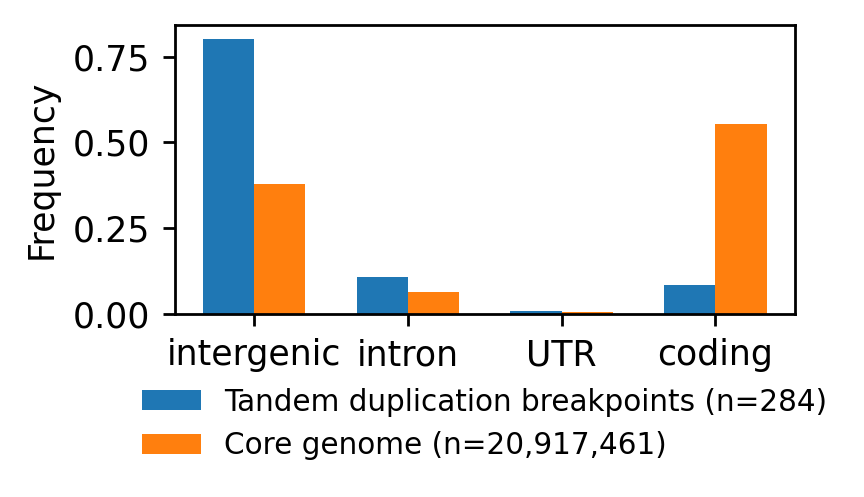

In [193]:
fig, ax = plt.subplots(figsize=(3.2, 1.5))

classification_list = ['intergenic', 'intron', 'UTR', 'coding']
breakpoint_class_dist = []
core_genome_class_dist = []
total_num_breakpoints = sum(breakpoint_classification_dict.values())
total_core_genome_size = sum(core_genome_classification_dict.values())

for classification in classification_list:
    breakpoint_class_dist.append(breakpoint_classification_dict[classification]/float(total_num_breakpoints))
    core_genome_class_dist.append(core_genome_classification_dict[classification]/float(total_core_genome_size))

# Write contingency table for Prism (columns: Tandem duplication breakpoints vs. Core genome, rows: classification)
with open("/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/ind_tandemdup_breakpoint_classification.tsv", 'w') as f:
    f.write('\t'.join(["Classification", "Independent tandem duplication breakpoint freq", "Core genome freq",
                      "Independent tandem duplication breakpoint", "Core genome"]) + '\n')
    for classification in classification_list:
        TD_freq = breakpoint_classification_dict[classification]/float(total_num_breakpoints)
        core_freq = core_genome_classification_dict[classification]/float(total_core_genome_size)
        items = [classification, TD_freq, core_freq, 
                 breakpoint_classification_dict[classification], core_genome_classification_dict[classification]]
        f.write('\t'.join([str(item) for item in items]) + '\n')

xs = 1.5*np.arange(len(classification_list))
ax.bar(xs, breakpoint_class_dist, width=0.5, label="Tandem duplication breakpoints (n=%i)" % total_num_breakpoints)
ax.bar(xs+0.5, core_genome_class_dist, width=0.5, label="Core genome (n={:,})".format(total_core_genome_size))
ax.set_xticks(xs+0.25)
ax.set_xticklabels(classification_list)
ax.set_ylabel("Frequency")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), fontsize=8.5, frameon=False)

Text(0, 0.5, 'Distance to\nnearest gene (bp)')

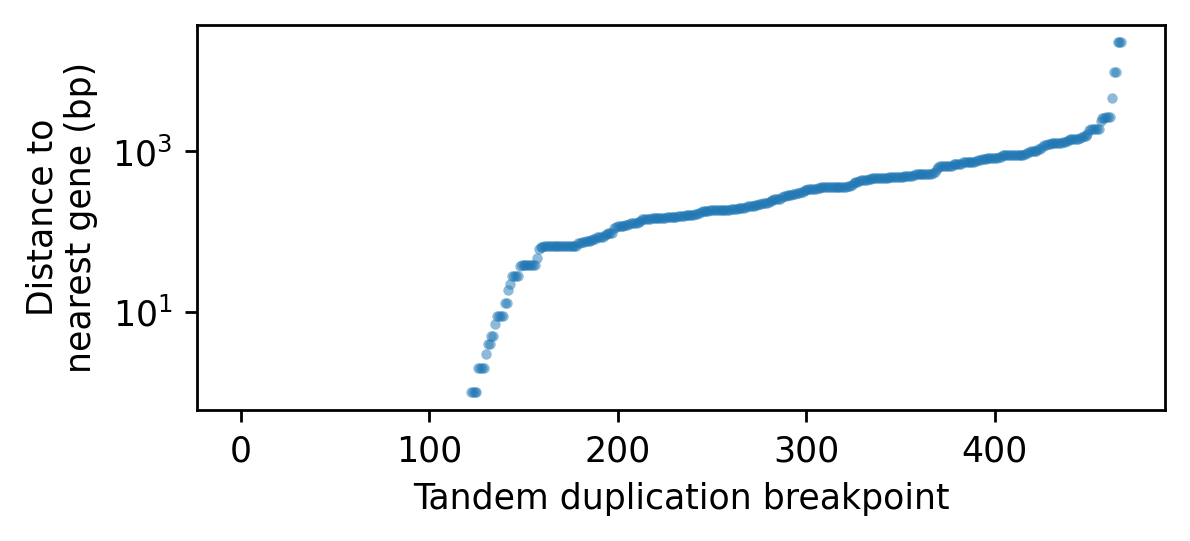

In [37]:
breakpoint_distances = []
breakpoint_distance_pairs = []
for clone in clone_tandemdup_distance_to_gene_dict:
    for chrom in clone_tandemdup_distance_to_gene_dict[clone]:
        for CNV in clone_tandemdup_distance_to_gene_dict[clone][chrom]:
            start_distance, end_distance = clone_tandemdup_distance_to_gene_dict[clone][chrom][CNV]
            breakpoint_distance_pairs.append((start_distance, end_distance))
            breakpoint_distances.append(start_distance)
            breakpoint_distances.append(end_distance)

fig, ax = plt.subplots(figsize=(5, 2))
xs = np.arange(len(breakpoint_distances))
ax.plot(xs, sorted(breakpoint_distances), '.', alpha=0.5, mew=0)
ax.set_yscale('log')
ax.set_xlabel("Tandem duplication breakpoint")
ax.set_ylabel("Distance to\nnearest gene (bp)")

Text(0, 0.5, 'Distance to nearest gene (bp)\nEnd breakpoint')

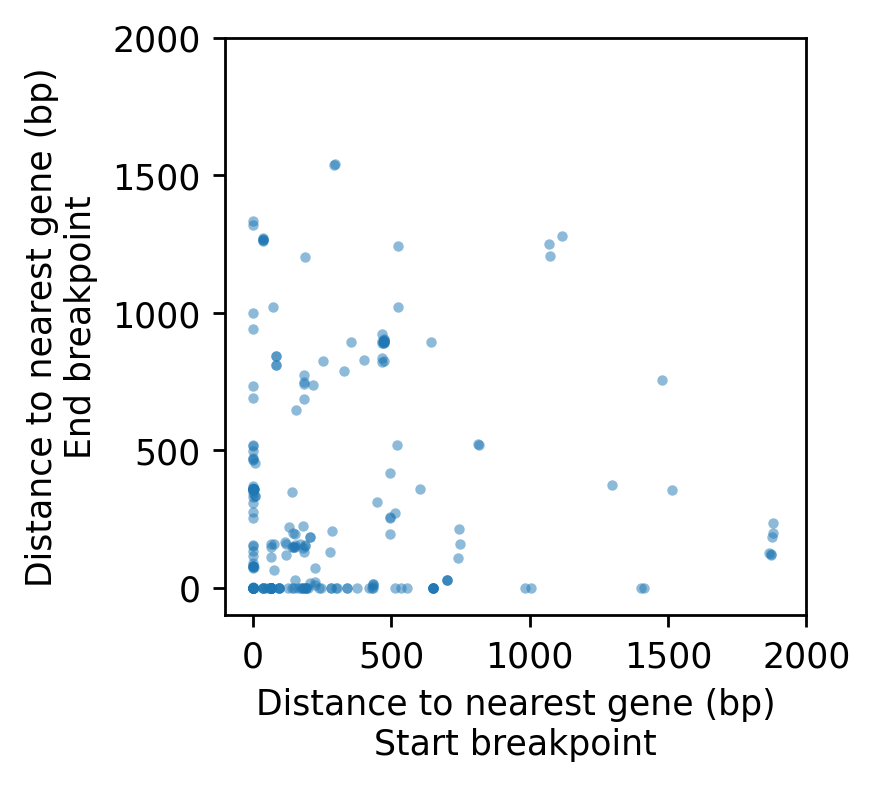

In [38]:
start_distances = [sd for sd, ed in sorted(breakpoint_distance_pairs)]
end_distances = [ed for sd, ed in sorted(breakpoint_distance_pairs)]

fig, ax = plt.subplots(figsize=(3, 3))
xs = np.arange(len(start_distances))
ax.plot(start_distances, end_distances, '.', alpha=0.5, mew=0)
ax.set_xlim((-100, 2000)); ax.set_ylim((-100, 2000))
ax.set_xlabel("Distance to nearest gene (bp)\nStart breakpoint")
ax.set_ylabel("Distance to nearest gene (bp)\nEnd breakpoint")

SRR2729233-BRD1095-Dd2-flask3-clone3-fixed
BMGF-Wirth-3444-8F7
Number of CNVs: 364 (0.33) across 280 clones


Text(0.5, 0, 'Number of CNVs per clone')

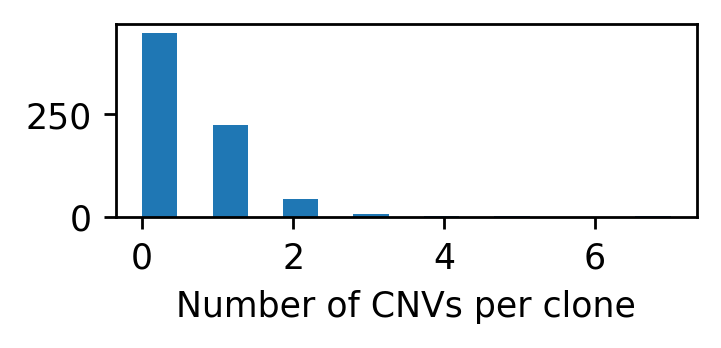

In [39]:
# Characterize filtered CNVs
num_validated_CNVs = 0
total_num_CNVs = 0
clones_with_CNVs = set()

clone_num_CNVs_dict = defaultdict(int)

for clone in clone_master_CNV_dict:
    for chrom in clone_master_CNV_dict[clone]:
        for CNV in clone_master_CNV_dict[clone][chrom]:
            total_num_CNVs += 1
            if clone_filtered_CNV_validation_dict[clone][chrom][CNV] is True:
                num_validated_CNVs += 1
                clone_num_CNVs_dict[clone] += 1
                clones_with_CNVs.add(clone)
    
    if clone_num_CNVs_dict[clone] > 5:
        print(clone)

print("Number of CNVs: %i (%.02f) across %i clones" % (num_validated_CNVs, num_validated_CNVs/float(total_num_CNVs),
                                                      len(clones_with_CNVs)))
fig, ax = plt.subplots(figsize=(3, 1))
ax.hist(clone_num_CNVs_dict.values(), bins=15)
ax.set_xlabel("Number of CNVs per clone")

## Figure 1: P-value vs. Delly support ROC curve

In [75]:
# OLD
'''
quality_threshold = 30

pval_list = []
DELLY_support_list = []
true_label_list = []

for clone in clone_master_CNV_dict:
    strain = clone_strain_dict[clone]
    compound = clone_compound_dict[clone]
    for chrom in clone_CNV_dict[clone]:
        for CNV in clone_CNV_dict[clone][chrom]:
            
            CNV_type = clone_CNV_dict[clone][chrom][CNV]
            start, end = CNV            
            size = end - start
            
            total_overlap_bp = 0            
            for match_CNV in DELLY_clone_CNV_dict[clone][chrom]:
                quality = DELLY_clone_CNV_quality_dict[clone][chrom][match_CNV]
                match_CNV_type = DELLY_clone_CNV_dict[clone][chrom][match_CNV]
                if CNV_type == match_CNV_type and quality >= quality_threshold:
                    total_overlap_bp += getOverlap(CNV, match_CNV)
            
            prop_covered = (total_overlap_bp/float(size))
            
            classification, support = clone_CNV_heuristic_validation_dict[clone][chrom][CNV]
            pval = clone_CNV_pval_dict[clone][(chrom, start, end)]
            
            pval_list.append(pval)
            DELLY_support_list.append(prop_covered)
            true_label_list.append(clone_CNV_full_validation_dict[clone][chrom][CNV])

true_label_list = np.array(true_label_list)
'''
pass

In [27]:
true_label_list = []
pval_list = []; DELLY10_support_list = []; DELLY30_support_list = []; TD_support_list = []

for clone in clone_master_CNV_dict:
    for chrom in clone_master_CNV_dict[clone]:
        for CNV in clone_master_CNV_dict[clone][chrom]:
            true_label_list.append(clone_filtered_CNV_validation_dict[clone][chrom][CNV])
            pval, TD_support, delly10, delly30 = clone_CNV_support_dict[clone][chrom][CNV]
            pval_list.append(pval)
            TD_support_list.append(TD_support)
            DELLY10_support_list.append(delly10)
            DELLY30_support_list.append(delly30)

true_label_list = np.array(true_label_list)

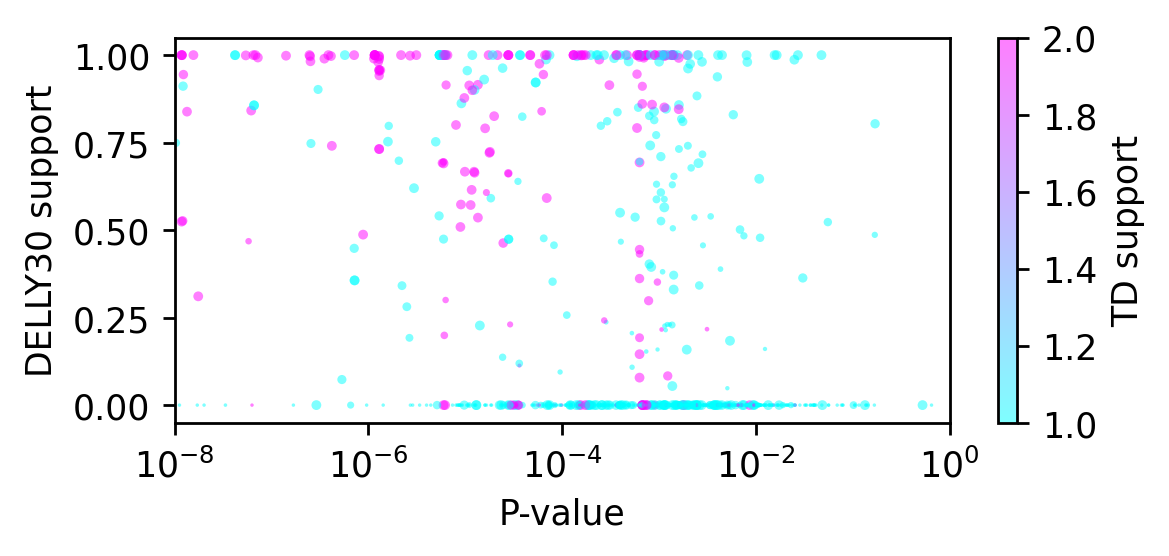

In [28]:
fig, ax = plt.subplots(figsize=(5, 2))
TD_support_categorized_list = []
for TD in TD_support_list:
    if TD == 0:
        TD_support_categorized_list.append(0)
    elif TD <= 4:
        TD_support_categorized_list.append(1)
    else:
        TD_support_categorized_list.append(2)
sc = ax.scatter(pval_list, DELLY30_support_list, alpha=0.5, s=((np.array(DELLY10_support_list)+1)**3), 
                c=TD_support_categorized_list, linewidth=0, cmap='cool')
ax.set_xscale('log'); ax.set_xlim((1e-8, 1))
ax.set_xlabel("P-value"); ax.set_ylabel("DELLY30 support")
plt.colorbar(sc, label="TD support")

In [29]:
# For different P-value thresholds, show number of final CNVs that DON'T satisfy it
# These are false negatives

pval_num_false_negatives_dict = defaultdict(int); pval_threshold_list = []
pval_num_false_positives_dict = defaultdict(int)
for exponent in np.arange(-10, -0.5, 0.5):
    pval_threshold = 10**exponent; pval_threshold_list.append(pval_threshold)

DELLY10_num_false_negatives_dict = defaultdict(int); DELLY10_threshold_list = np.arange(0, 1, 0.05)
DELLY10_num_false_positives_dict = defaultdict(int)

DELLY30_num_false_negatives_dict = defaultdict(int); DELLY30_threshold_list = np.arange(0, 1, 0.05)
DELLY30_num_false_positives_dict = defaultdict(int)

TD_num_false_negatives_dict = defaultdict(int); TD_threshold_list = np.arange(0, 21)
TD_num_false_positives_dict = defaultdict(int)

num_kept = 0
total_num = len(true_label_list)

for kept, pval, DELLY10, DELLY30, TD_support in zip(true_label_list, pval_list, DELLY10_support_list, 
                                                    DELLY30_support_list, TD_support_list):
    for pval_threshold in pval_threshold_list:
        if (not (pval < pval_threshold)) and (kept):
            pval_num_false_negatives_dict[pval_threshold] += 1
        elif (pval < pval_threshold) and (not kept):
            pval_num_false_positives_dict[pval_threshold] += 1
    
    for DELLY10_threshold in DELLY10_threshold_list:
        if (not (DELLY10 > DELLY10_threshold)) and (kept):
            DELLY10_num_false_negatives_dict[DELLY10_threshold] += 1
        elif (DELLY10 > DELLY10_threshold) and (not kept):
            DELLY10_num_false_positives_dict[DELLY10_threshold] += 1
    
    for DELLY30_threshold in DELLY30_threshold_list:
        if (not (DELLY30 > DELLY30_threshold)) and (kept):
            DELLY30_num_false_negatives_dict[DELLY30_threshold] += 1
        elif (DELLY30 > DELLY30_threshold) and (not kept):
            DELLY30_num_false_positives_dict[DELLY30_threshold] += 1
    
    for TD_threshold in TD_threshold_list:
        if (not (TD_support > TD_threshold)) and (kept):
            TD_num_false_negatives_dict[TD_threshold] += 1
        elif (TD_support > TD_threshold) and (not kept):
            TD_num_false_positives_dict[TD_threshold] += 1
    
    if kept:
        num_kept += 1

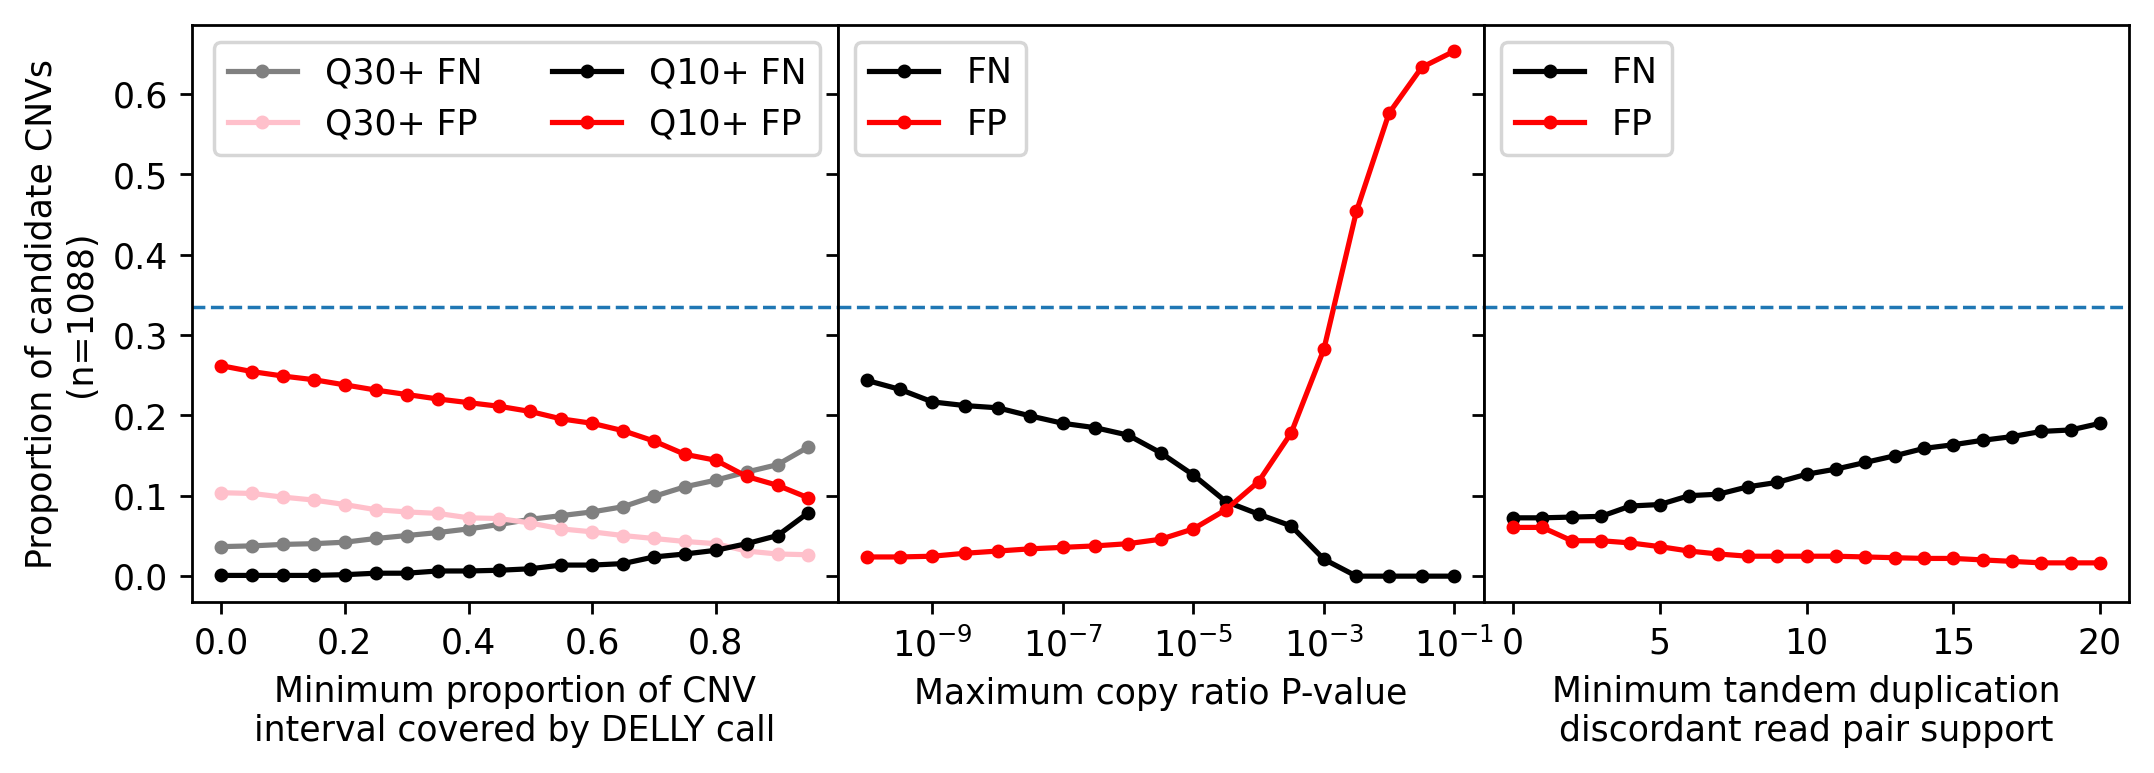

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

fns = []; fps = [] 
for DELLY30_threshold in DELLY30_threshold_list:
    fns.append(DELLY30_num_false_negatives_dict[DELLY30_threshold]); fps.append(DELLY30_num_false_positives_dict[DELLY30_threshold])
ax[0].plot(DELLY30_threshold_list, np.array(fns)/total_num, '.-', label="Q30+ FN", color='gray')
ax[0].plot(DELLY30_threshold_list, np.array(fps)/total_num, '.-', label="Q30+ FP", color='pink')

fns = []; fps = [] 
for DELLY10_threshold in DELLY10_threshold_list:
    fns.append(DELLY10_num_false_negatives_dict[DELLY10_threshold]); fps.append(DELLY10_num_false_positives_dict[DELLY10_threshold])
ax[0].plot(DELLY10_threshold_list, np.array(fns)/total_num, '.-', label="Q10+ FN", color='black')
ax[0].plot(DELLY10_threshold_list, np.array(fps)/total_num, '.-', label="Q10+ FP", color='red')
ax[0].set_xlabel("Minimum proportion of CNV\ninterval covered by DELLY call")
ax[0].legend(ncol=2)

fns = []; fps = [] 
for pval_threshold in pval_threshold_list:
    fns.append(pval_num_false_negatives_dict[pval_threshold]); fps.append(pval_num_false_positives_dict[pval_threshold])
ax[1].plot(pval_threshold_list, np.array(fns)/total_num, '.-', label="FN", color='black')
ax[1].plot(pval_threshold_list, np.array(fps)/total_num, '.-', label="FP", color='red')
ax[1].set_xscale('log')
ax[1].set_xlabel("Maximum copy ratio P-value")
ax[1].legend()

fns = []; fps = [] 
for TD_threshold in TD_threshold_list:
    fns.append(TD_num_false_negatives_dict[TD_threshold]); fps.append(TD_num_false_positives_dict[TD_threshold])
ax[2].plot(TD_threshold_list, np.array(fns)/total_num, '.-', label="FN", color='black')
ax[2].plot(TD_threshold_list, np.array(fps)/total_num, '.-', label="FP", color='red')
ax[2].set_xlabel("Minimum tandem duplication\ndiscordant read pair support")
ax[2].legend(loc="upper left")

for i in [0, 1, 2]:
    ax[i].axhline(y=(num_kept/float(total_num)), linestyle='--', linewidth=1)

ax[0].set_ylabel("Proportion of candidate CNVs\n(n=%i)" % total_num)
plt.subplots_adjust(wspace=0)

In [30]:
strain_interval_gene_id_desc_class_dict = defaultdict(dict) # (contig, start, end) -> (ID, desc, class)

for strain in ['3D7', 'Dd2']:
    with open('/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/%s_interval_annotations.tsv' % strain, 'r') as f:
        header = f.readline()
        for line in f:
            items = line.split('\t')
            contig, start, end, = items[:3]
            gene_id, gene_desc, miles_genome_class = items[-3:]
            start = int(start); end = int(end); miles_genome_class = miles_genome_class.strip()
            strain_interval_gene_id_desc_class_dict[strain][(contig, start, end)] = (gene_id, gene_desc, miles_genome_class)

def get_copyratio_dict(sample_full_name, strain):
    chrom_interval_copyratio_dict = defaultdict(dict)
    
    copyratio_dir = '/storage/NFS/ANALYSIS/DNAseq/test/gatk_cnv_%s' % strain
    f = open('%s/%s.denoisedCR.tsv' % (copyratio_dir, sample_full_name), 'r')
    line = f.readline()
    while line[0] == '@':
        line = f.readline()
    
    header = line.strip().split('\t')
    for line in f:
        chrom, start, end, log2_copyratio = line.strip().split('\t')
        chrom_interval_copyratio_dict[chrom][(int(start), int(end))] = float(log2_copyratio)
    
    return chrom_interval_copyratio_dict

def get_copyratio_list(strain, chrom_interval_copyratio_dict, chrom, start_pos, end_pos):
    copyratio_list = []
    gene_list = []
    interval_list = []
    start_flag = False
    for interval_start, interval_end in sorted(chrom_interval_copyratio_dict[chrom]):
        interval = (interval_start, interval_end)
        copyratio = chrom_interval_copyratio_dict[chrom][(interval_start, interval_end)]
        gene = strain_interval_gene_id_desc_class_dict[strain][(chrom, interval_start, interval_end)][0]
        if start_flag:
            copyratio_list.append(copyratio)
            gene_list.append(gene)
            interval_list.append(interval)
        if start_pos >= interval_start and start_pos <= interval_end:
            copyratio_list.append(copyratio)
            gene_list.append(gene)
            interval_list.append(interval)
            start_flag = True
        if end_pos >= interval_start and end_pos <= interval_end:
            copyratio_list.append(copyratio)
            gene_list.append(gene)
            interval_list.append(interval)
            break
    
    return copyratio_list, gene_list, interval_list

def get_predicted_CNVs(sample_name):
    predicted_CNVs = []
    chrom_intervals_dict = defaultdict(list)
    
    f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/CNVprobabilityvalues.tsv', 'r')
    header = f.readline()
    
    for line in f:
        items = line.rstrip().split('\t')
        if items[0] == "":
            break
        clone_name, compound, pval, CNV_start, CNV_end, CNV_dir, chrom = items[:7]
        pval = float(pval)
        if clone_name == sample_name:
            predicted_CNVs.append((chrom, int(CNV_start), int(CNV_end)))
            chrom_intervals_dict[chrom].append((int(CNV_start), int(CNV_end)))
    
    return predicted_CNVs

def get_evidence_reads(sample_full_name, strain):
    RF_chrom_reads_dict = defaultdict(list)
    RR_chrom_reads_dict = defaultdict(list)
    FF_chrom_reads_dict = defaultdict(list)
    
    bam_dir = '/storage/NFS/ANALYSIS/DNAseq/test/bam_sam_filtered_daisy_%s' % strain
    f = open('%s/%s_INVDUP.sam' % (bam_dir, sample_full_name), 'r')
    for line in tqdm(f):
        items = line.strip().split('\t')
        qname, flag, chrom, pos, mapq, cigar, chrom_next, pos_next, tlen, seq, qual = items[:11]
        flag = int(flag); pos = int(pos); mapq = int(mapq); pos_next = int(pos_next); insert_size = np.abs(int(tlen))

        if mapq >= 20:
            if flag in [97, 81, 145, 161] and (insert_size > 500 or insert_size < 50):
                RF_chrom_reads_dict[chrom].append((flag, pos, len(seq), chrom_next, pos_next))
            elif flag in [177, 113]:
                RR_chrom_reads_dict[chrom].append((flag, pos, len(seq), chrom_next, pos_next))
            elif flag in [65, 129]:
                FF_chrom_reads_dict[chrom].append((flag, pos, len(seq), chrom_next, pos_next))
    
    return RF_chrom_reads_dict, RR_chrom_reads_dict, FF_chrom_reads_dict

In [31]:
# MDR1 CNVs as a heatmap, different breakpoints
# Do some genes always have same CNV breakpoints come up?

ordered_MDR1_clones = []
MDR1_CR_array = []

labels = []

for clone in tqdm(sorted(clone_master_CNV_dict)):
    
    compound = clone_compound_dict[clone]
    strain = clone_strain_dict[clone]
    if strain == 'Dd2':
        continue
    
    for chrom in clone_master_CNV_dict[clone]:
        for start, end in clone_master_CNV_dict[clone][chrom]:
            if clone_independent_CNV_validation_dict[clone][chrom][(start, end)] is True:
                if 'PF3D7_0523000' in interval_to_genes(chrom, start, end): # MDR1
                    labels.append((clone, compound, start, end))
                    sample_bam_name = clone_to_bam_name_dict[clone]                
                    chrom_interval_copyratio_dict = get_copyratio_dict(sample_bam_name, strain)
                    cr_list, gene_list, interval_list = get_copyratio_list(strain, chrom_interval_copyratio_dict, chrom, 850000, 1060000)
                    ordered_MDR1_clones.append(clone)
                    MDR1_CR_array.append(cr_list)

MDR1_CR_array = np.array(MDR1_CR_array)

100%|███████████████████████████████████████| 726/726 [00:00<00:00, 6358.56it/s]


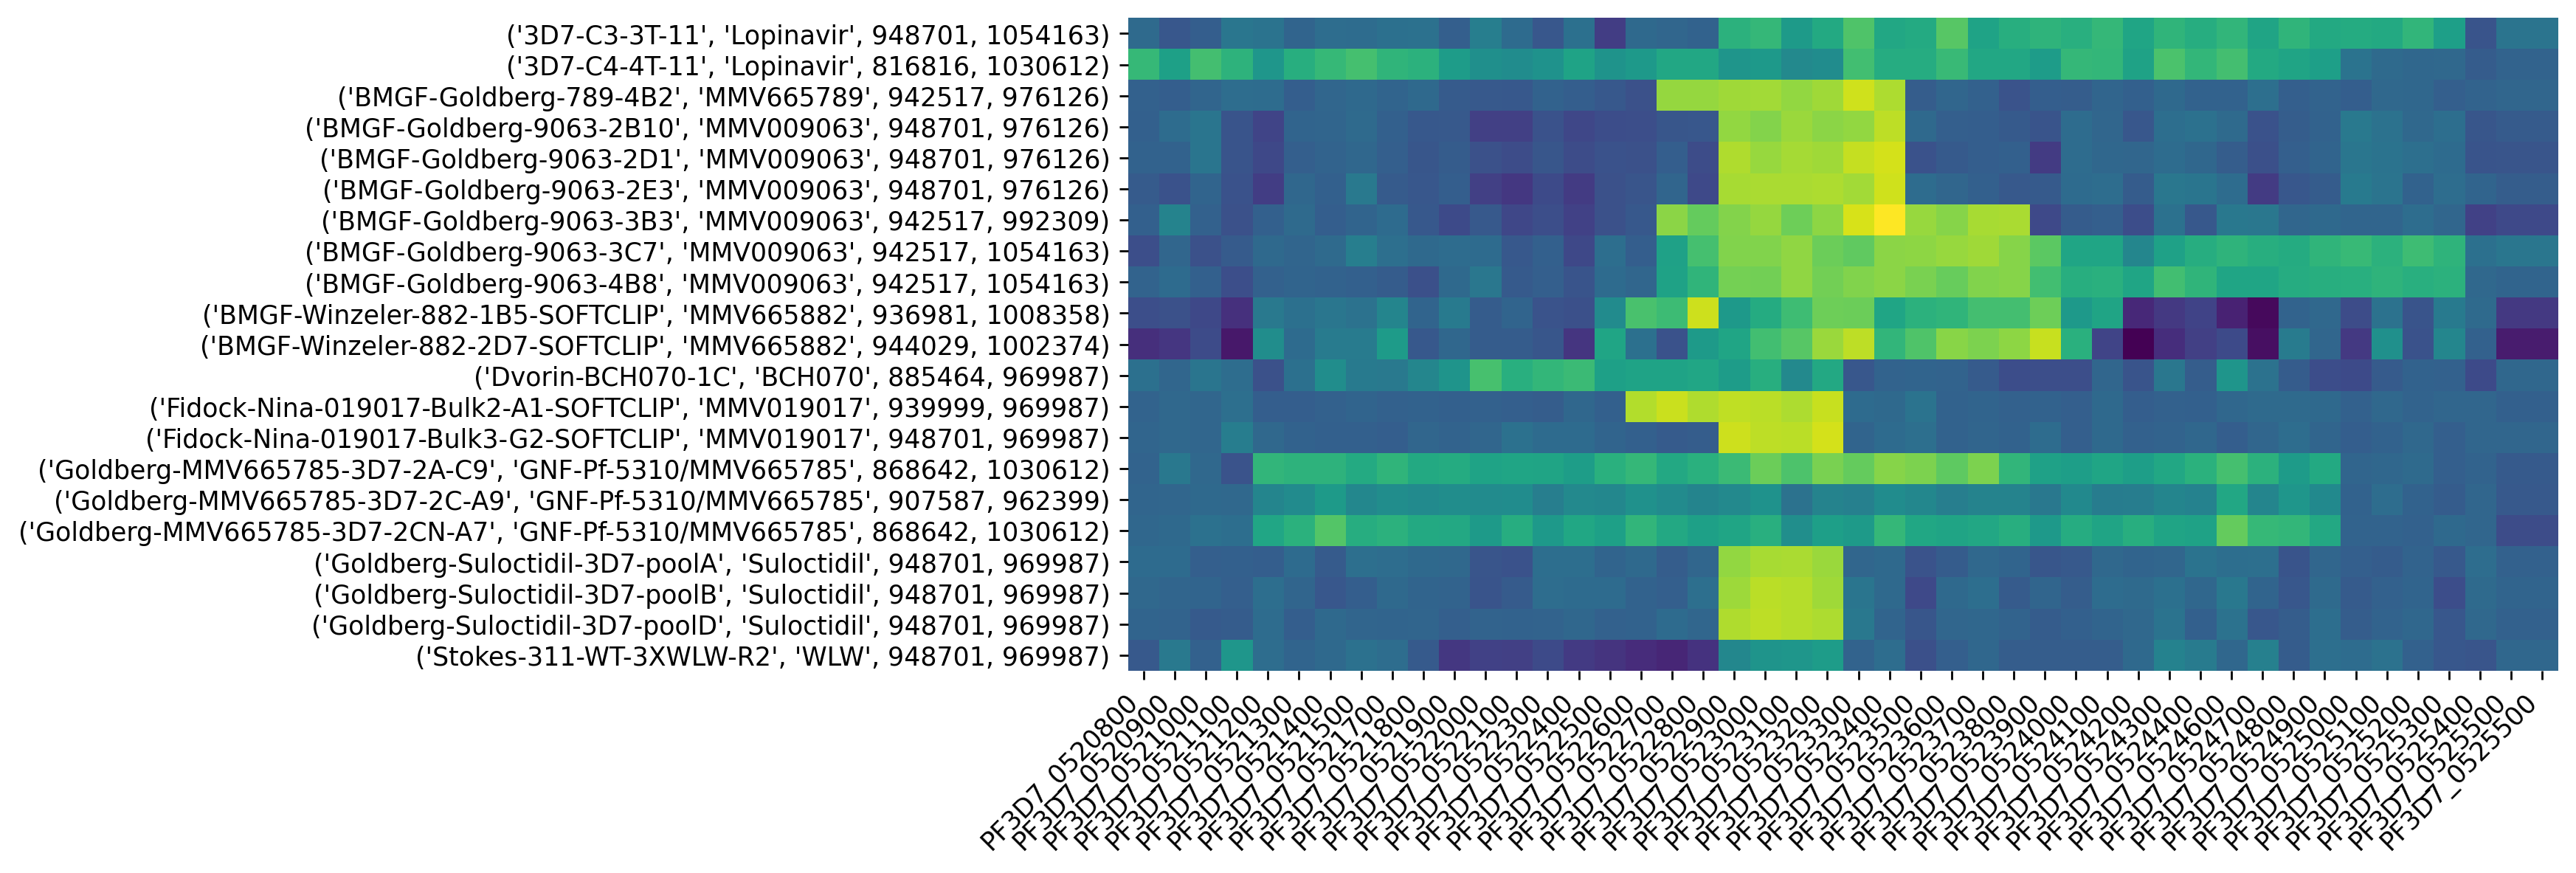

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(MDR1_CR_array, cmap="viridis")
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(MDR1_CR_array.shape[1]))
ax.set_yticks(np.arange(MDR1_CR_array.shape[0]))
ax.set_yticklabels(labels)
ax.set_xticklabels(gene_list, rotation=45, ha='right')
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.25)
ax.tick_params(which="minor", bottom=False, left=False)

In [33]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [34]:
def CR_to_color(copyratio):
    yellow_val = 0.6
    blue_val = 0
    black_val = -0.6
    neg_color_gradient = get_color_gradient('#046cdb', '#000000', 7)
    pos_color_gradient = get_color_gradient('#046cdb', '#ffff00', 7)
    if copyratio >= 0.6:
        return pos_color_gradient[-1]
    elif copyratio >= 0:
        idx = int(10*copyratio)
        return pos_color_gradient[idx]
    elif copyratio <= -0.6:
        return neg_color_gradient[-1]
    else:
        idx = int(-10*copyratio)
        return neg_color_gradient[idx]

In [35]:
def clean_figure_clone_name(clone):
    clone_ID = clone.replace('-SOFTCLIP', '').split('-')[-1]
    for strain_str in ['3D7-', '-3D7-', '-Dd2', '-Dd2-', '-Dd2-pol-delta-']:
        if strain_str in clone:
            clone_ID = clone.split(strain_str)[1]
    clone_ID = clone_ID.replace('clone-', '').replace('clone', '')
    compound = clone_compound_dict[clone]
    if compound == 'GNF-Pf-5310/MMV665785':
        compound = 'MMV665785'
    strain = clone_strain_dict[clone]
    return ':'.join([compound, clone_ID])

In [36]:
# Clones sorted by compound followed by clone name (only for those relevant to clean figure clone name)
sorted_clones_for_heatmap = sorted(clone_master_CNV_dict.keys(), key=lambda x: clean_figure_clone_name(x).split(':'))
sorted_clones_for_heatmap = sorted_clones_for_heatmap[::-1]

In [37]:
plt.rcParams['svg.fonttype'] = 'none'

100%|██████████████████████████████████████████| 726/726 [00:02<00:00, 283.40it/s]


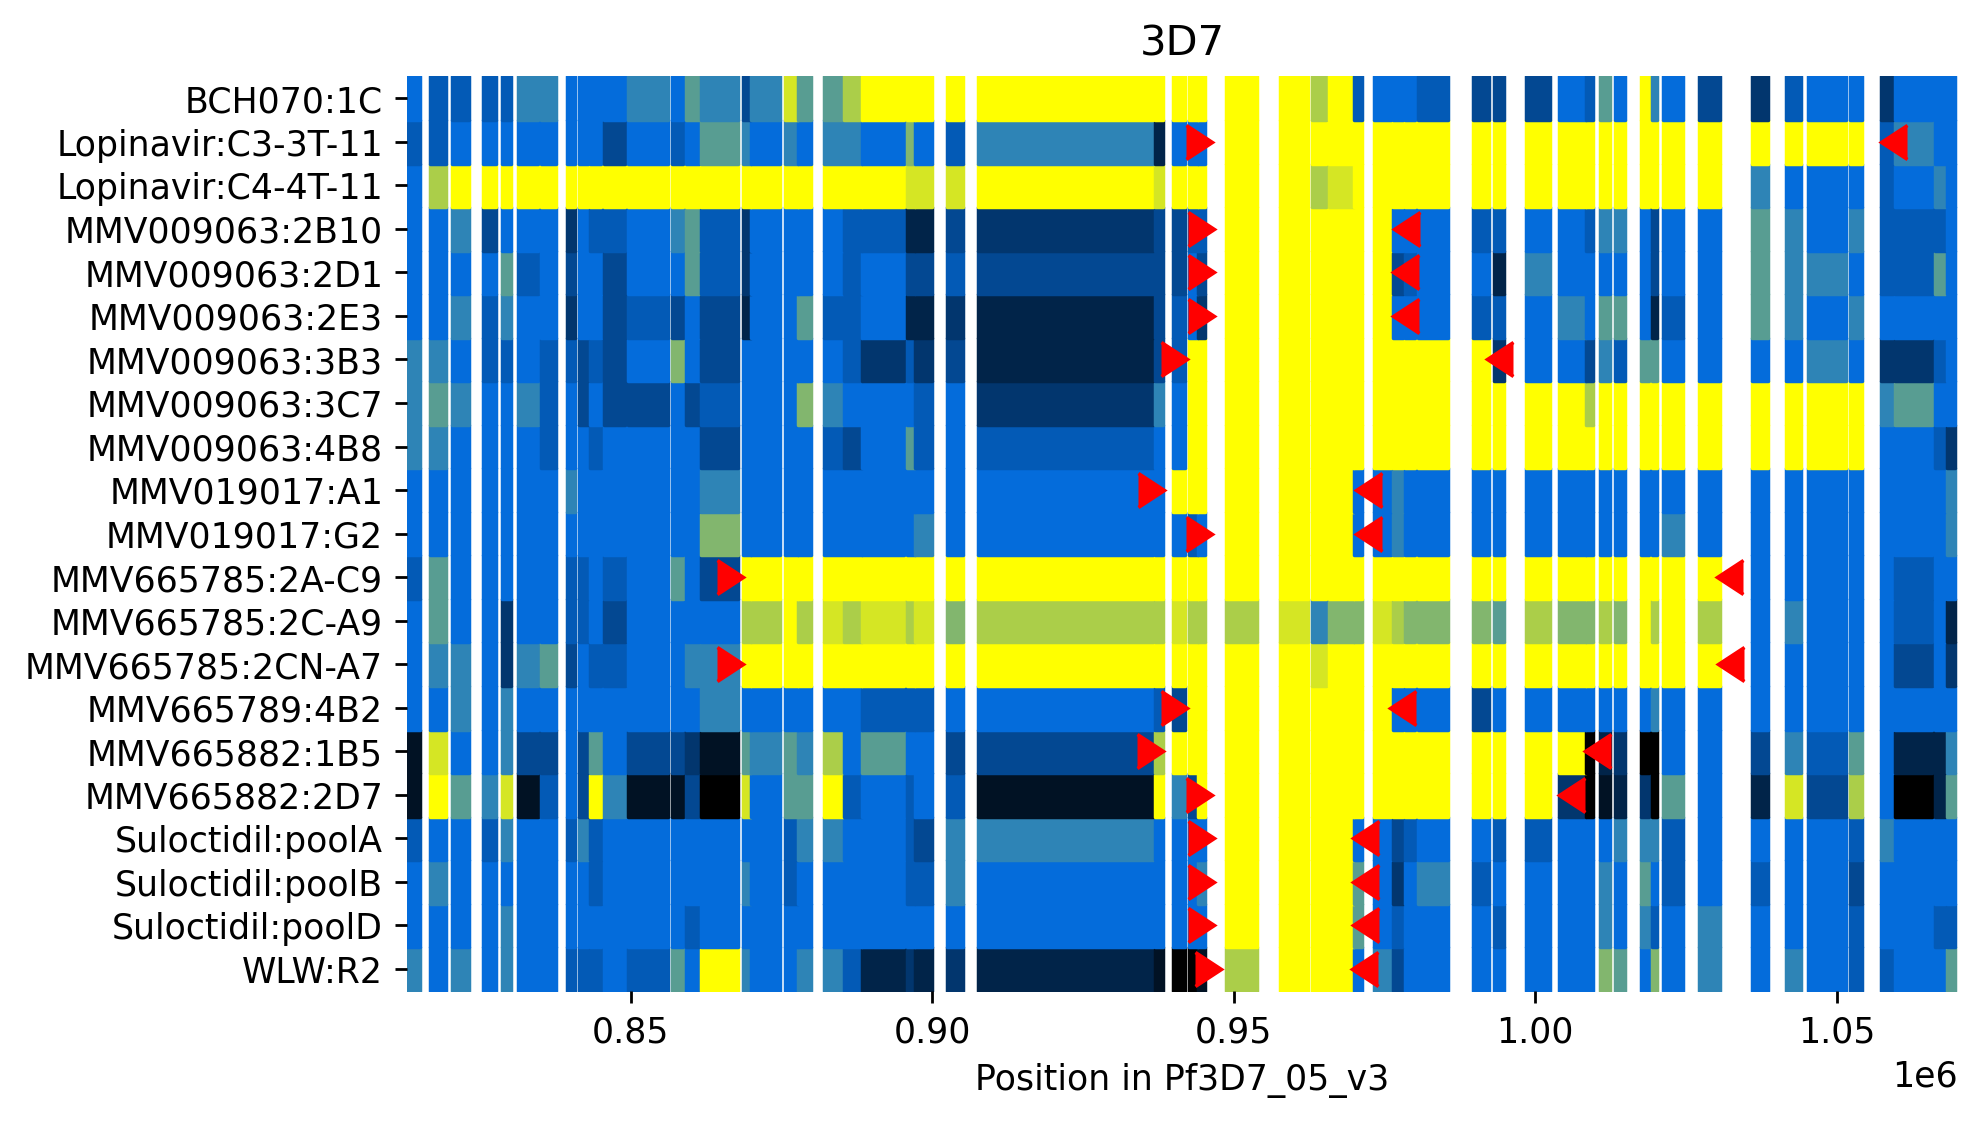

In [174]:
# Make a plot that is gene length accurate


xmin = 813000; xmax = 1070000; desired_strain = '3D7'

width = 4.75 if strain == 'Dd2' else 4

fig, ax = plt.subplots(figsize=(8, width))

labels = []

y = 0
for clone in tqdm(sorted_clones_for_heatmap):
    
    compound = clone_compound_dict[clone]
    strain = clone_strain_dict[clone]
    
    if strain != desired_strain:
        continue
    
    for chrom in clone_master_CNV_dict[clone]:
        for CNV in clone_master_CNV_dict[clone][chrom]:
            start, end = CNV
            if clone_independent_CNV_validation_dict[clone][chrom][(start, end)] is True:
                
                if 'PF3D7_0523000' in interval_to_genes(chrom, start, end): # MDR1

                    labels.append(clean_figure_clone_name(clone))
                    # labels.append(clone) #, compound)) # , newstart, newend))

                    sample_bam_name = clone_to_bam_name_dict[clone]                
                    chrom_interval_copyratio_dict = get_copyratio_dict(sample_bam_name, strain)
                    cr_list, gene_list, interval_list = get_copyratio_list(strain, chrom_interval_copyratio_dict, chrom, 
                                                                           xmin, xmax)
                    # test_chrom_interval_copyratio_dict = chrom_interval_copyratio_dict; test_strain = strain
                    for interval, CR in zip(interval_list, cr_list):
                        interval_start, interval_end = interval
                        ax.fill_between([interval_start, interval_end], y-0.5, y+0.5, color=CR_to_color(CR))
                    
                    if CNV in clone_tandemdup_revised_boundaries_dict[clone][chrom]: # Tandem duplication (uncombined)
                        TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][CNV]
                        newstart, newend = clone_tandemdup_revised_boundaries_dict[clone][chrom][CNV]  
                        ax.plot([newstart], [y], marker=5, linewidth=0, markersize=10, color='red')
                        ax.plot([newend], [y], marker=4, linewidth=0, markersize=10, color='red')
                    y += 1

ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlim((xmin, xmax))
ax.set_ylim((-0.5, y-0.5))
ax.set_xlabel("Position in Pf3D7_05_v3")
ax.set_title(desired_strain)
for key, spine in ax.spines.items():
    spine.set_visible(False)

plt.savefig("/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/MDR1_CNV_heatmap_figure_%s.svg" % desired_strain, format='svg')

In [38]:
# Final version for Figure 2
# Clones sorted by compound followed by clone name (only for those relevant to clean figure clone name), grouped by strain
sorted_clones_for_heatmap = sorted(clone_master_CNV_dict.keys(), 
                                   key=lambda x: [clone_strain_dict[x]] + (clean_figure_clone_name(x).split(':')))
sorted_clones_for_heatmap = sorted_clones_for_heatmap[::-1]

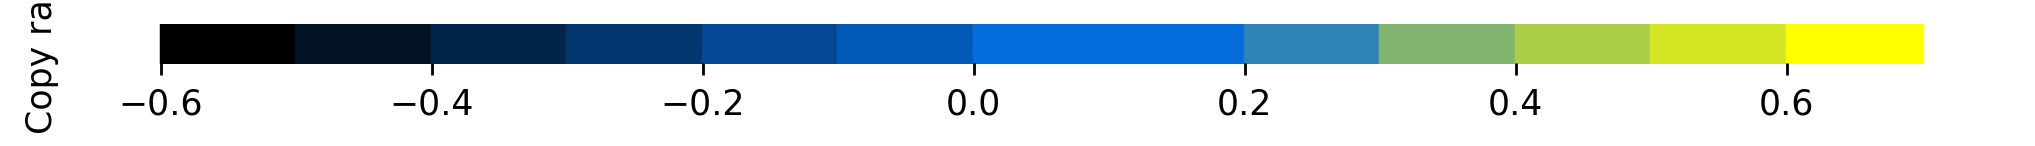

In [39]:
# Make colorbar for figure
fig, ax = plt.subplots(figsize=(10, 0.2))
CR = -0.6
while CR < 0.7:
    color = CR_to_color(CR)
    ax.fill_between([CR, CR+0.1], 0, 1, color=CR_to_color(CR))
    CR += 0.1
ax.set_ylim((0, 1))
ax.set_yticks([])
ax.set_ylabel("Copy ratio")
for key, spine in ax.spines.items():
    spine.set_visible(False)

plt.savefig("/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/MDR1_CNV_heatmap_colorbar.svg", format='svg')

100%|████████████████████████████████████████| 726/726 [00:04<00:00, 161.87it/s]


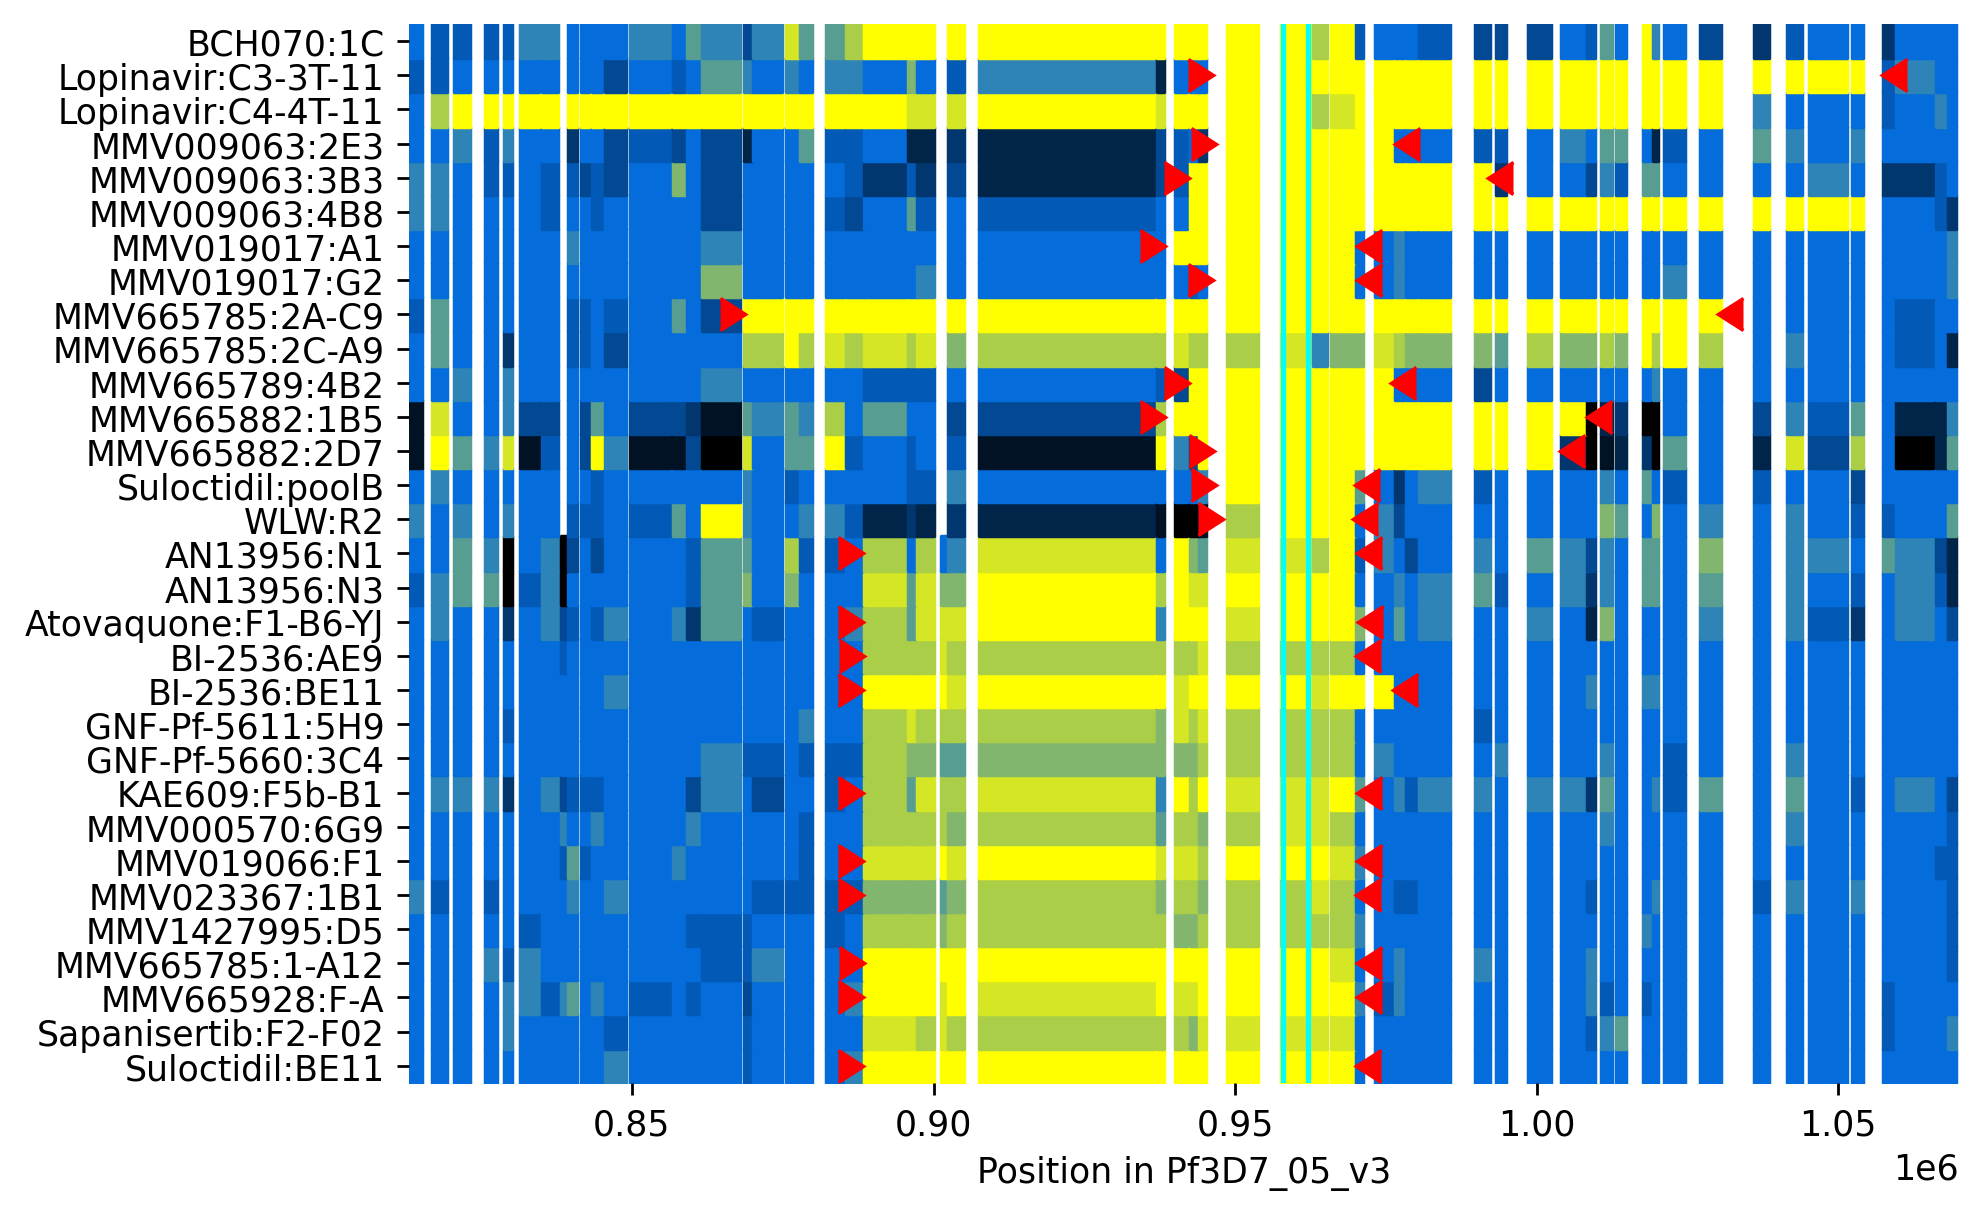

In [47]:
# Make a plot that is gene length accurate

exclude_clean_clones = ['MMV009063:2B10', 'Suloctidil:CD9', 'Suloctidil:CH7', 'Suloctidil:poolA', 'Suloctidil:poolC',
                        'Suloctidil:poolD', 'MMV665785:2CN-A7', 'Atovaquone:F2-E5-YJ', 'KAE609:F1-0404-B4',
                        'KAE609:F6-0404-F2', 'BI-2536:poolA', 'MMV009063:2D1', 'MMV009063:3C7', 'Sapanisertib:F2-D02']

fig, ax = plt.subplots(figsize=(8, 5.5))
xmin = 813000; xmax = 1070000
MDR1_start, MDR1_end, _ = chrom_gene_interval_dict['Pf3D7_05_v3']['PF3D7_0523000']
labels = []
y = 0
for clone in tqdm(sorted_clones_for_heatmap):
    
    compound = clone_compound_dict[clone]
    strain = clone_strain_dict[clone]
    
    for chrom in clone_master_CNV_dict[clone]:
        for CNV in clone_master_CNV_dict[clone][chrom]:
            start, end = CNV
            if clone_independent_CNV_validation_dict[clone][chrom][(start, end)] is True:
                
                if 'PF3D7_0523000' in interval_to_genes(chrom, start, end): # MDR1
                    clean_name = clean_figure_clone_name(clone)
                    if clean_name in exclude_clean_clones:
                        continue
                    labels.append(clean_name)
                    # labels.append(clone) #, compound)) # , newstart, newend))

                    sample_bam_name = clone_to_bam_name_dict[clone]                
                    chrom_interval_copyratio_dict = get_copyratio_dict(sample_bam_name, strain)
                    cr_list, gene_list, interval_list = get_copyratio_list(strain, chrom_interval_copyratio_dict, chrom, 
                                                                           xmin, xmax)
                    # test_chrom_interval_copyratio_dict = chrom_interval_copyratio_dict; test_strain = strain
                    for interval, CR in zip(interval_list, cr_list):
                        interval_start, interval_end = interval
                        ax.fill_between([interval_start, interval_end], y-0.5, y+0.5, color=CR_to_color(CR))
                    
                    if CNV in clone_tandemdup_revised_boundaries_dict[clone][chrom]: # Tandem duplication (uncombined)
                        TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][CNV]
                        newstart, newend = clone_tandemdup_revised_boundaries_dict[clone][chrom][CNV]  
                        ax.plot([newstart], [y], marker=5, linewidth=0, markersize=9.5, color='red')
                        ax.plot([newend], [y], marker=4, linewidth=0, markersize=9.5, color='red')
                    y += 1

ax.axvline(MDR1_start, color='cyan')
ax.axvline(MDR1_end, color='cyan')
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlim((xmin, xmax))
ax.set_ylim((-0.5, y-0.5))
ax.set_xlabel("Position in Pf3D7_05_v3")
for key, spine in ax.spines.items():
    spine.set_visible(False)

# plt.savefig("/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/MDR1_CNV_heatmap_figure_all.svg", format='svg')

In [48]:
MDR1_boundary_tuples = []
for clone in sorted(clone_master_CNV_dict):    
    compound = clone_compound_dict[clone]
    strain = clone_strain_dict[clone]    
    for chrom in clone_master_CNV_dict[clone]:
        for CNV in clone_master_CNV_dict[clone][chrom]:
            start, end = CNV
            if clone_independent_CNV_validation_dict[clone][chrom][(start, end)] is True:                
                if CNV in clone_tandemdup_revised_boundaries_dict[clone][chrom]: # Tandem duplication (uncombined)
                    newstart, newend = clone_tandemdup_revised_boundaries_dict[clone][chrom][CNV]  
                    if 'PF3D7_0523000' in interval_to_genes(chrom, start, end): # MDR1
                        MDR1_boundary_tuples.append([strain, newstart, newend, compound, clone])

for tup in sorted(MDR1_boundary_tuples, key=lambda x: (x[0], x[2])):
    print('\t'.join([str(item) for item in tup]))

3D7	947968	969634	WLW	Stokes-311-WT-3XWLW-R2
3D7	946804	969858	Suloctidil	Goldberg-Suloctidil-3D7-poolB
3D7	946803	969861	Suloctidil	Goldberg-Suloctidil-3D7-poolD
3D7	946796	969864	Suloctidil	Goldberg-Suloctidil-3D7-poolA
3D7	946332	970277	MMV019017	Fidock-Nina-019017-Bulk3-G2-SOFTCLIP
3D7	938415	970279	MMV019017	Fidock-Nina-019017-Bulk2-A1-SOFTCLIP
3D7	942333	975889	MMV665789	BMGF-Goldberg-789-4B2
3D7	946812	976454	MMV009063	BMGF-Goldberg-9063-2D1
3D7	946812	976492	MMV009063	BMGF-Goldberg-9063-2E3
3D7	946806	976506	MMV009063	BMGF-Goldberg-9063-2B10
3D7	942335	991933	MMV009063	BMGF-Goldberg-9063-3B3
3D7	946447	1003882	MMV665882	BMGF-Winzeler-882-2D7-SOFTCLIP
3D7	938323	1008314	MMV665882	BMGF-Winzeler-882-1B5-SOFTCLIP
3D7	868667	1030096	GNF-Pf-5310/MMV665785	Goldberg-MMV665785-3D7-2A-C9
3D7	868667	1030371	GNF-Pf-5310/MMV665785	Goldberg-MMV665785-3D7-2CN-A7
3D7	946346	1057296	Lopinavir	3D7-C3-3T-11
Dd2	888321	970083	MMV023367	BMGF-Fidock-023367-1B1
Dd2	888485	970105	BI-2536	Goldberg-BI-2

In [67]:
endmin = 970060; endmax = 970170
for tup in sorted(MDR1_boundary_tuples, key=lambda x: (x[0], x[2])):
    end = tup[2]; strain = tup[0]
    if strain == 'Dd2' and end >= endmin and end <= endmax:
        seq = chromosome_sequence_dict['Pf3D7_05_v3']
        annoseq = seq[:end] + '*' + seq[end:]; print(end, annoseq[endmin:endmax])
print('')
endmin = 970200; endmax = 970320
for tup in sorted(MDR1_boundary_tuples, key=lambda x: (x[0], x[2])):
    end = tup[2]; strain = tup[0]
    if strain == 'Dd2' and end >= endmin and end <= endmax:
        seq = chromosome_sequence_dict['Pf3D7_05_v3']
        annoseq = seq[:end] + '*' + seq[end:]; print(end, annoseq[endmin:endmax])

970083 ATAAGAAAATAAACAAATAAATA*GATAAATAAATATAAATATAAATATAAATAAATGTTTGTATATTCAAATGGATAATTGAAAACCAAATTTATTTATTAAGAAAAAT
970105 ATAAGAAAATAAACAAATAAATAGATAAATAAATATAAATATAAA*TATAAATAAATGTTTGTATATTCAAATGGATAATTGAAAACCAAATTTATTTATTAAGAAAAAT
970105 ATAAGAAAATAAACAAATAAATAGATAAATAAATATAAATATAAA*TATAAATAAATGTTTGTATATTCAAATGGATAATTGAAAACCAAATTTATTTATTAAGAAAAAT
970105 ATAAGAAAATAAACAAATAAATAGATAAATAAATATAAATATAAA*TATAAATAAATGTTTGTATATTCAAATGGATAATTGAAAACCAAATTTATTTATTAAGAAAAAT
970105 ATAAGAAAATAAACAAATAAATAGATAAATAAATATAAATATAAA*TATAAATAAATGTTTGTATATTCAAATGGATAATTGAAAACCAAATTTATTTATTAAGAAAAAT
970115 ATAAGAAAATAAACAAATAAATAGATAAATAAATATAAATATAAATATAAATAAA*TGTTTGTATATTCAAATGGATAATTGAAAACCAAATTTATTTATTAAGAAAAAT
970118 ATAAGAAAATAAACAAATAAATAGATAAATAAATATAAATATAAATATAAATAAATGT*TTGTATATTCAAATGGATAATTGAAAACCAAATTTATTTATTAAGAAAAAT
970120 ATAAGAAAATAAACAAATAAATAGATAAATAAATATAAATATAAATATAAATAAATGTTT*GTATATTCAAATGGATAATTGAAAACCAAATTTATTTATTAAGAAAAAT
970136 ATAAGAAAATAAACAAATAAATAGATAAATAAATATAAATATAAATATA

In [72]:
# Get subset of CNVs with confident breakpoints
for clone in clone_master_CNV_dict:
    for chrom in clone_master_CNV_dict[clone]:
        intervals = []
        for CNV in clone_master_CNV_dict[clone][chrom]:
            if clone_filtered_CNV_validation_dict[clone][chrom][CNV] is True: # Filtered CNV                
                if CNV in clone_tandemdup_revised_boundaries_dict[clone][chrom]: # Tandem duplication (uncombined)
                    TD_support = clone_tandemdup_heuristic_validation_dict[clone][chrom][CNV]
                    newstart, newend = clone_tandemdup_revised_boundaries_dict[clone][chrom][CNV]                    
                    if 'PF3D7_0523000' in interval_to_genes(chrom, newstart, newend): # MDR1
                        print(CNV[0]-newstart, CNV[1]-newend)

25 -122
2218 -3190
51701 -312
-2883 6316
51701 -312
93 -118
2275 -3144
185 243
-44 231
30 -133
-25 241
26 -128
2251 -3075
51701 -312
2355 -3133
70 -100
29 -149
-25 228
1905 123
2355 -290
146 -118
55731 -314
1889 -366
51701 -311
51701 -309
51702 -311
146 -166
51701 -311
51701 -315
51701 -310
51702 -310
1622 -294
49 -246
51701 -310
51701 -313
2369 -290
-1342 44
184 237
51701 -316
147 -132
59 -251
185 237
1584 -292
-25 178
1895 -380
1889 -328
60380 -96
60393 -213
54032 -118
124 -212
185 372
733 353
1898 126
90 -31946
51707 -313
-2418 -1508
60 -131
170 250
1897 129
-25 516
51701 -311
51701 -310
182 376
137 -118


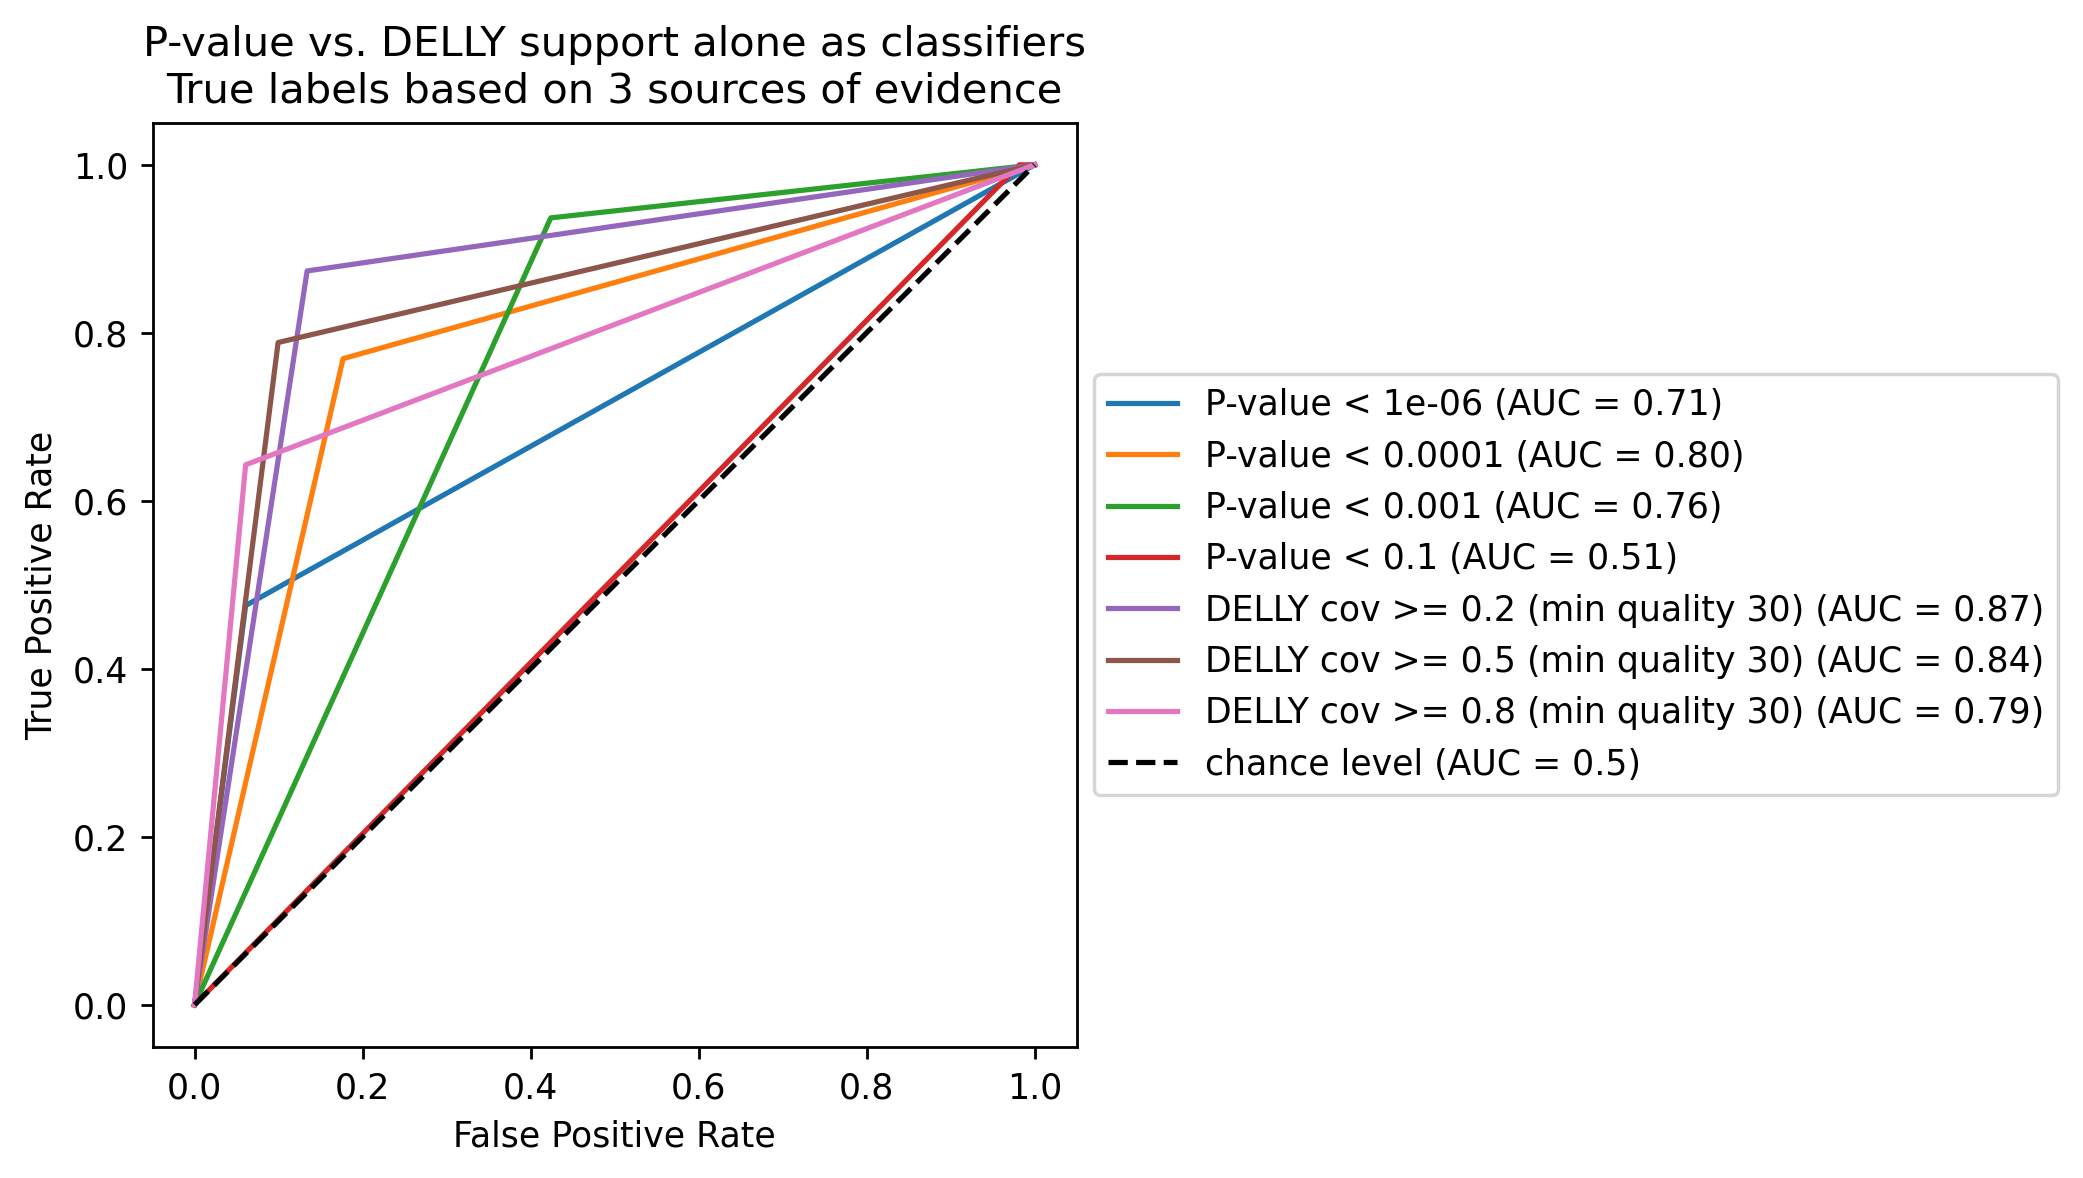

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()
for pval_threshold in [1e-6, 1e-4, 0.001, 0.1]:
    pred_label_list = np.array(pval_list) < pval_threshold
    RocCurveDisplay.from_predictions(
        true_label_list, pred_label_list,
        name=f"P-value < {pval_threshold}", ax=ax
    )

for delly_cov_threshold in [0.2, 0.5, 0.8]:
    pred_label_list = np.array(DELLY30_support_list) >= delly_cov_threshold
    RocCurveDisplay.from_predictions(
        true_label_list, pred_label_list,
        name=f"DELLY cov >= {delly_cov_threshold} (min quality {30})", ax=ax
    )

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.axis("square")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("P-value vs. DELLY support alone as classifiers\nTrue labels based on 3 sources of evidence")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Figure 2: Manhattan plot

In [109]:
chrom_pos_compounds_dict = {chrom: defaultdict(set) for chrom in chromosomes} # Position is binned
chrom_pos_num_CNVs_dict = {chrom: defaultdict(int) for chrom in chromosomes} # Position is binned

bin_size = 500

for clone in clone_CNV_full_validation_dict:
    compound = clone_compound_dict[clone]
    
    for chrom in clone_CNV_full_validation_dict[clone]:
        for CNV in clone_CNV_full_validation_dict[clone][chrom]:
            if clone_CNV_full_validation_dict[clone][chrom][CNV] is True:            
                CNV_type = clone_CNV_dict[clone][chrom][CNV]
                if CNV_type == 'amplification':
                    start, end = CNV
                    start_binned = start//bin_size
                    end_binned = end//bin_size
                    for pos_bin in range(start_binned, end_binned+1):
                        chrom_pos_compounds_dict[chrom][pos_bin].add(compound)
                        chrom_pos_num_CNVs_dict[chrom][pos_bin] += 1

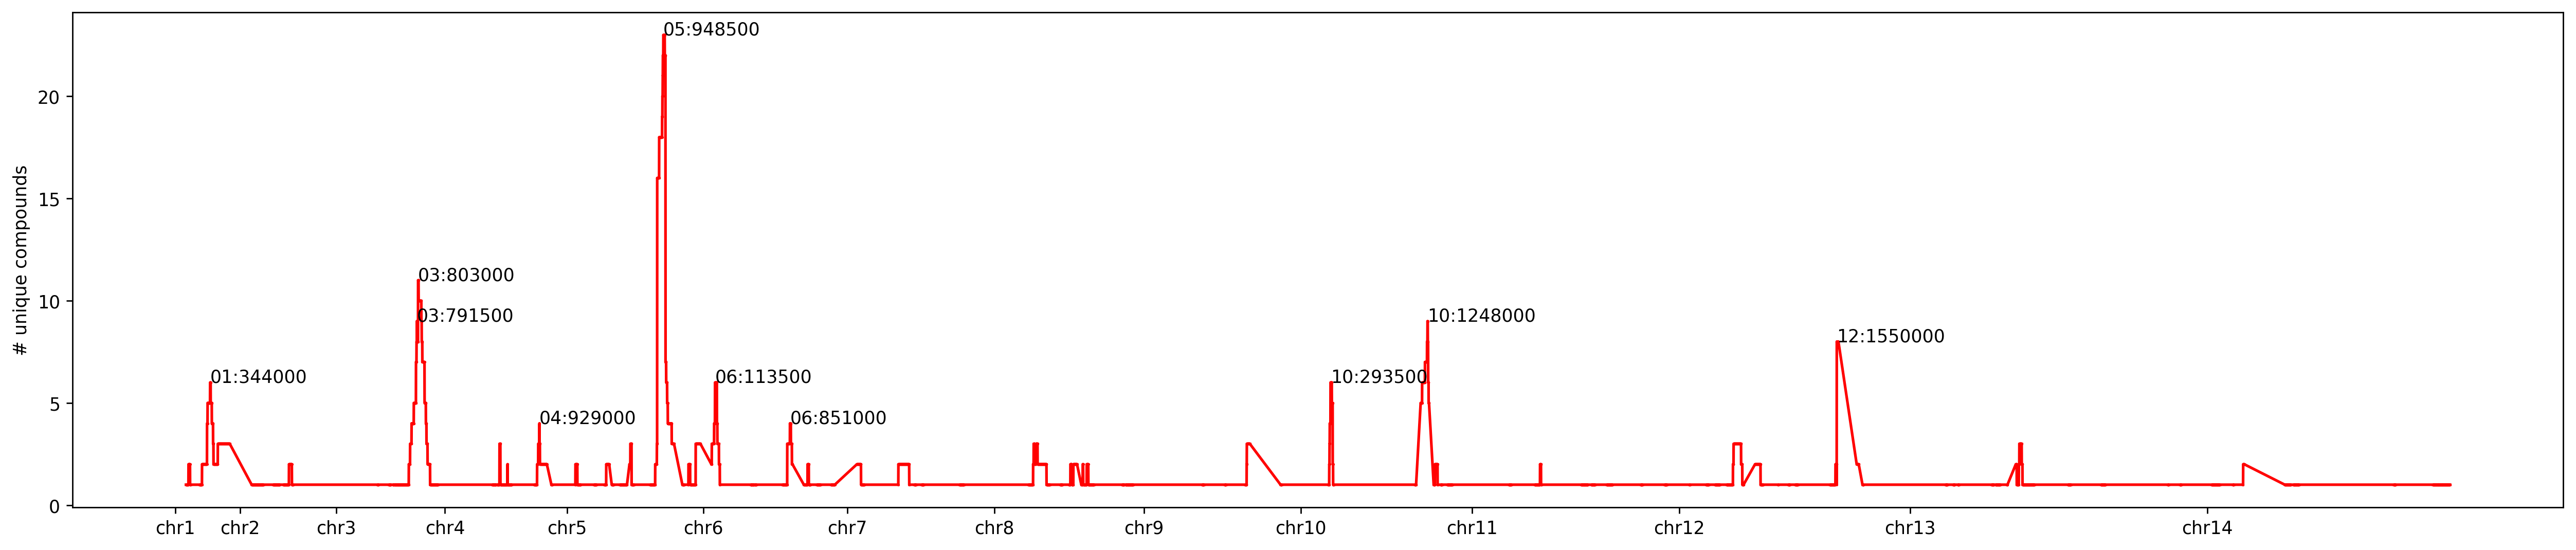

In [98]:
fig, ax = plt.subplots(figsize=(25,5))

xs = []; ys = []

for chrom in chromosomes14:
    chrom_ys = []; chrom_positions = []
    for pos_binned in sorted(chrom_pos_compounds_dict[chrom]):
        num_compounds = len(chrom_pos_compounds_dict[chrom][pos_binned])
        
        pos = bin_size*pos_binned
        manhattan_x = chrom_pos_to_manhattan_x(chrom, pos)
        
        xs.append(manhattan_x)
        ys.append(num_compounds)
        
        chrom_positions.append(pos)
        chrom_ys.append(num_compounds)

    # Label peaks
    start_idx = 0
    sequence = []
    for key, group in itertools.groupby(chrom_ys):
        sequence.append((key, chrom_positions[start_idx]))
        start_idx += sum(1 for _ in group) # Index in the list
    
    for i in range(1, len(sequence)-1):
        y, start_pos = sequence[i]
        if y > 3 and y > sequence[i-1][0] and y > sequence[i+1][0]:
            manhattan_x = chrom_pos_to_manhattan_x(chrom, start_pos)
            ax.text(manhattan_x, y, f"{chrom.split('_v3')[0].split('Pf3D7_')[1]}:{start_pos}",
                    horizontalalignment='left')

ax.plot(xs, ys, '.-', color='red', markersize=1)
ax.set_xticks([chrom_index_dict[chrom] for chrom in chromosomes14])
ax.set_xticklabels(["chr%i" % (i+1) for i, chrom in enumerate(chromosomes14)], horizontalalignment='center')
ax.set_ylabel("# unique compounds")
plt.show()

In [121]:
# Heatmap
# Compound vs regions amplified matrix

compound_amplified_regions_dict = defaultdict(list)
amplified_region_list = set()
compound_list = set()

for chrom in chrom_pos_compounds_dict:
    for pos_binned in chrom_pos_compounds_dict[chrom]:
        for compound in chrom_pos_compounds_dict[chrom][pos_binned]:
            compound_amplified_regions_dict[compound].append((chrom, pos_binned))
            amplified_region_list.add((chrom, pos_binned))
            compound_list.add(compound)

amplified_region_list = sorted(list(amplified_region_list))
compound_list = sorted(list(compound_list))

compound_amplified_region_matrix = np.zeros((len(compound_list), len(amplified_region_list)))

for c_idx, compound in tqdm(enumerate(compound_list)):
    for a_idx, amplified_region in enumerate(amplified_region_list):
        if tuple(amplified_region) in compound_amplified_regions_dict[compound]:
            compound_amplified_region_matrix[c_idx][a_idx] = 1

70it [00:05, 13.35it/s]


/home/dwc001/cenvs/jn/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


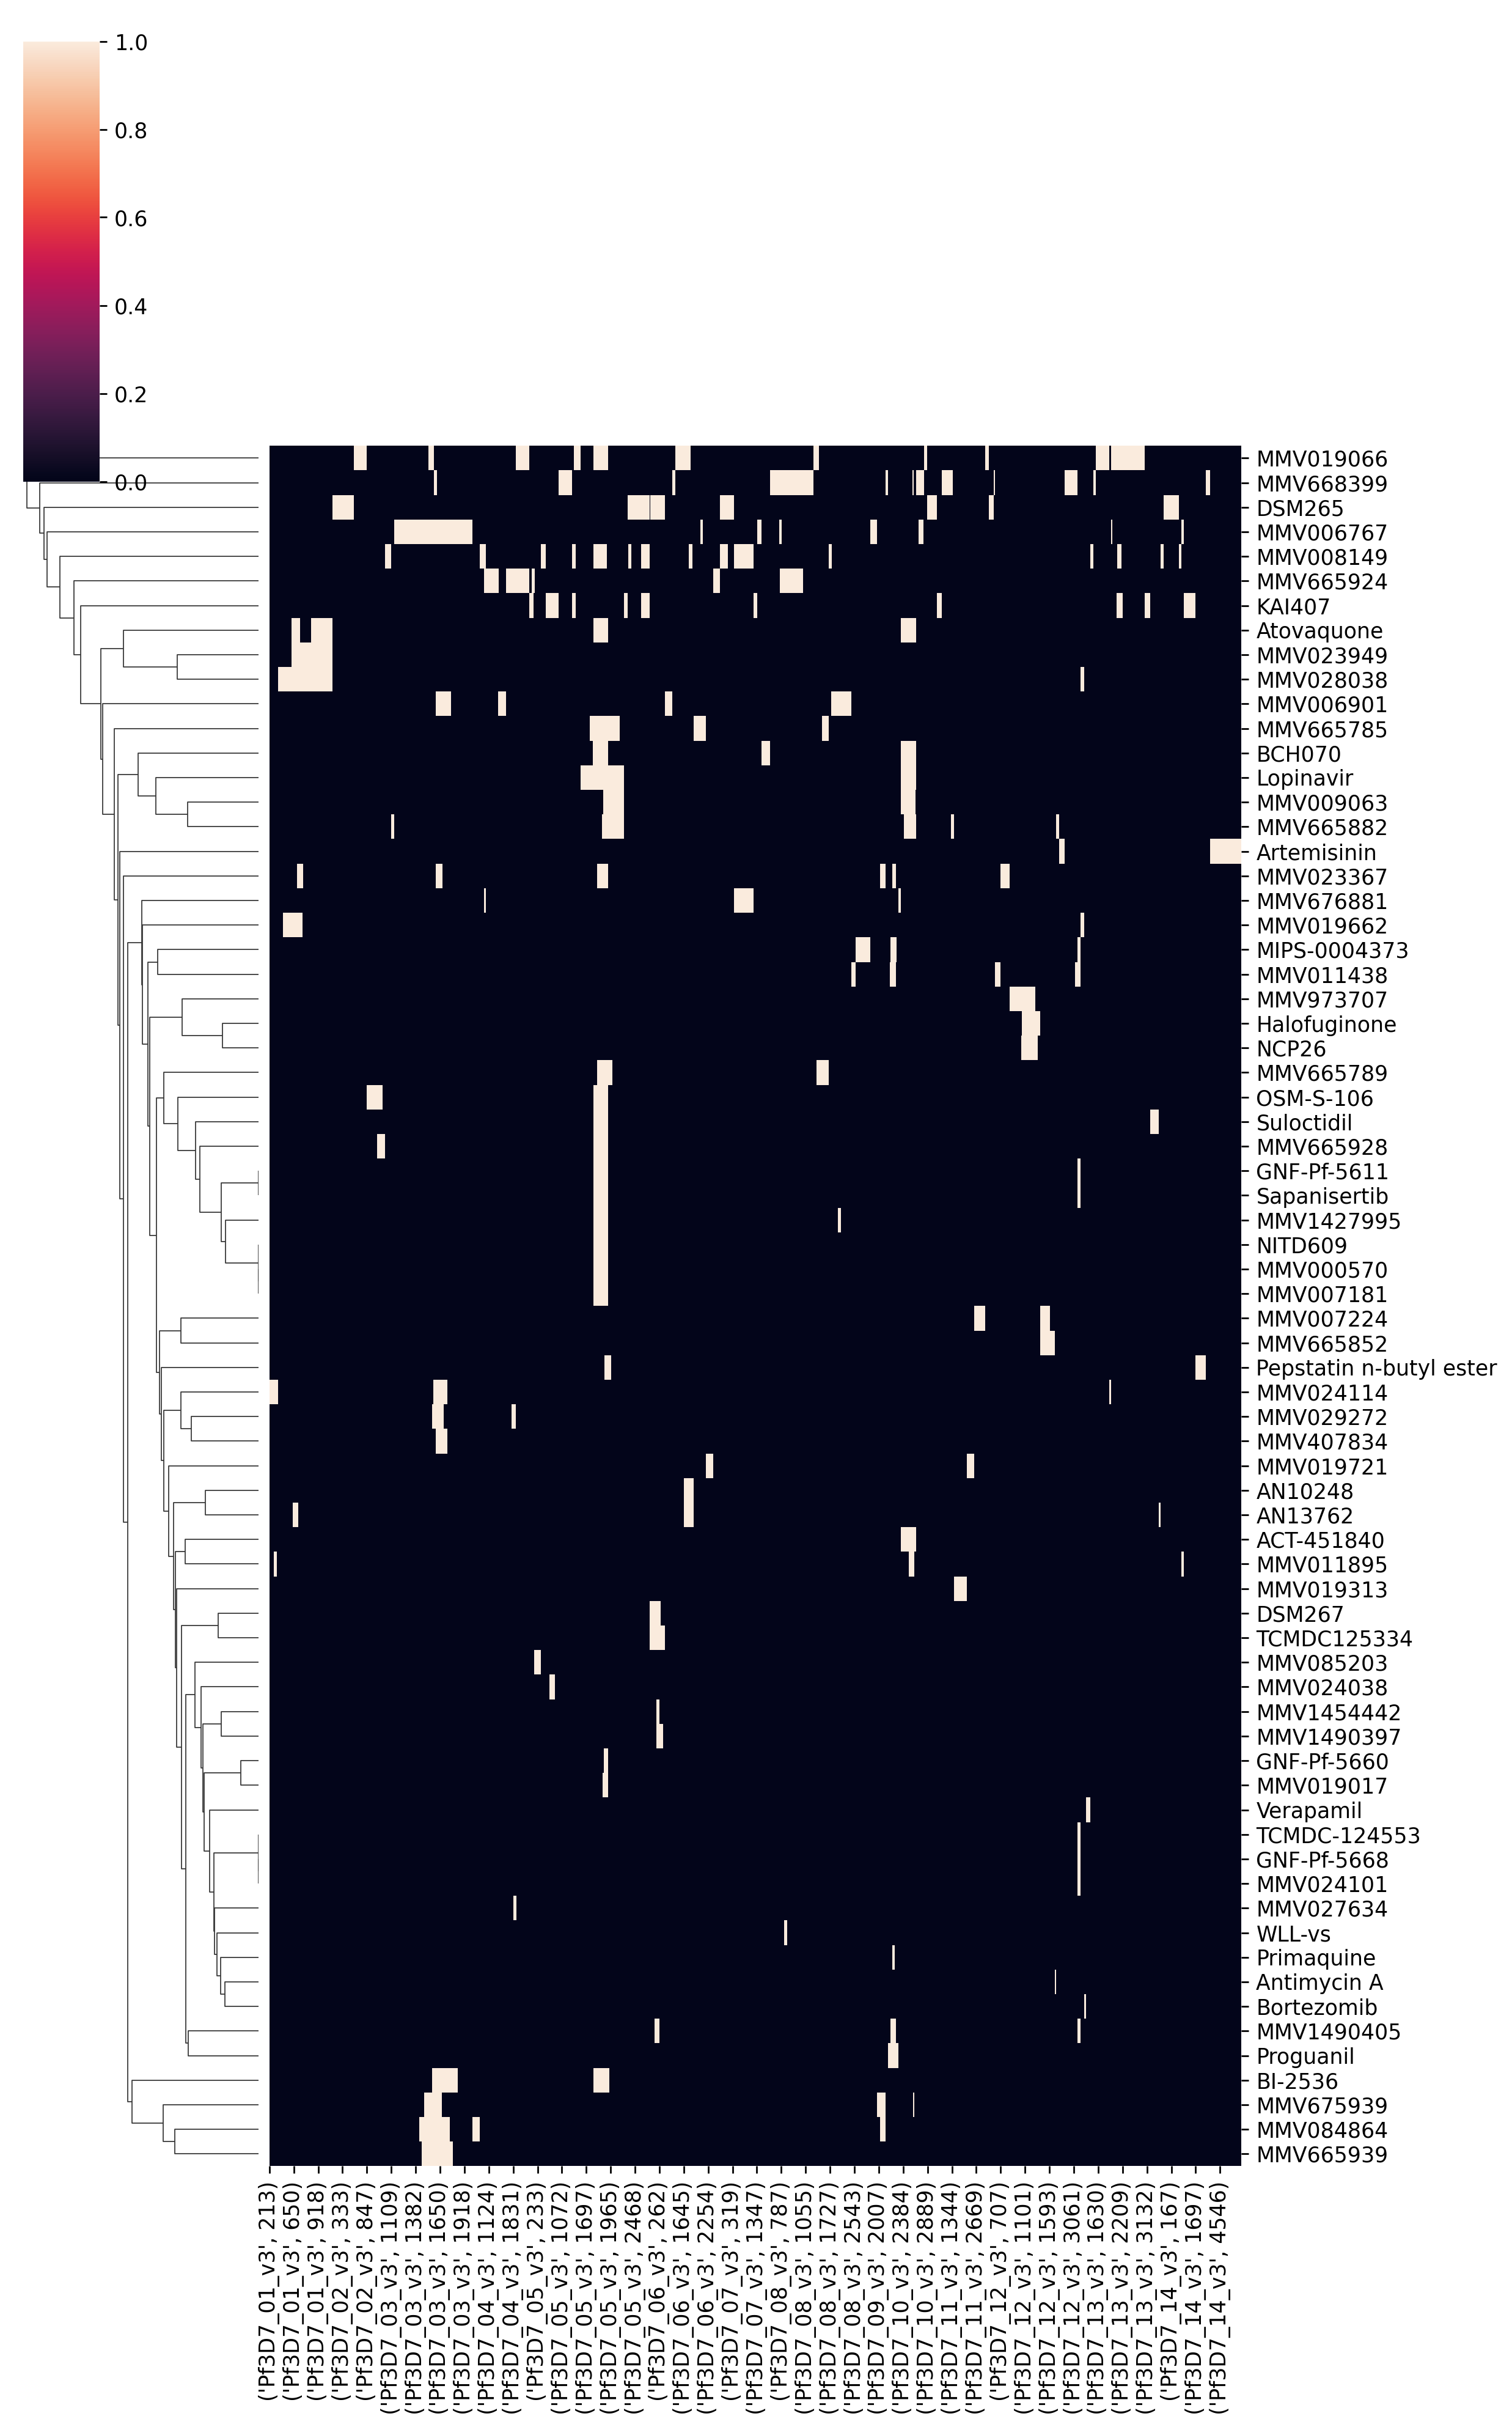

In [128]:
df = pd.DataFrame(compound_amplified_region_matrix, columns=amplified_region_list, index=compound_list)
sns.clustermap(df, row_cluster=True, col_cluster=False, yticklabels=True, figsize=(10, 16))

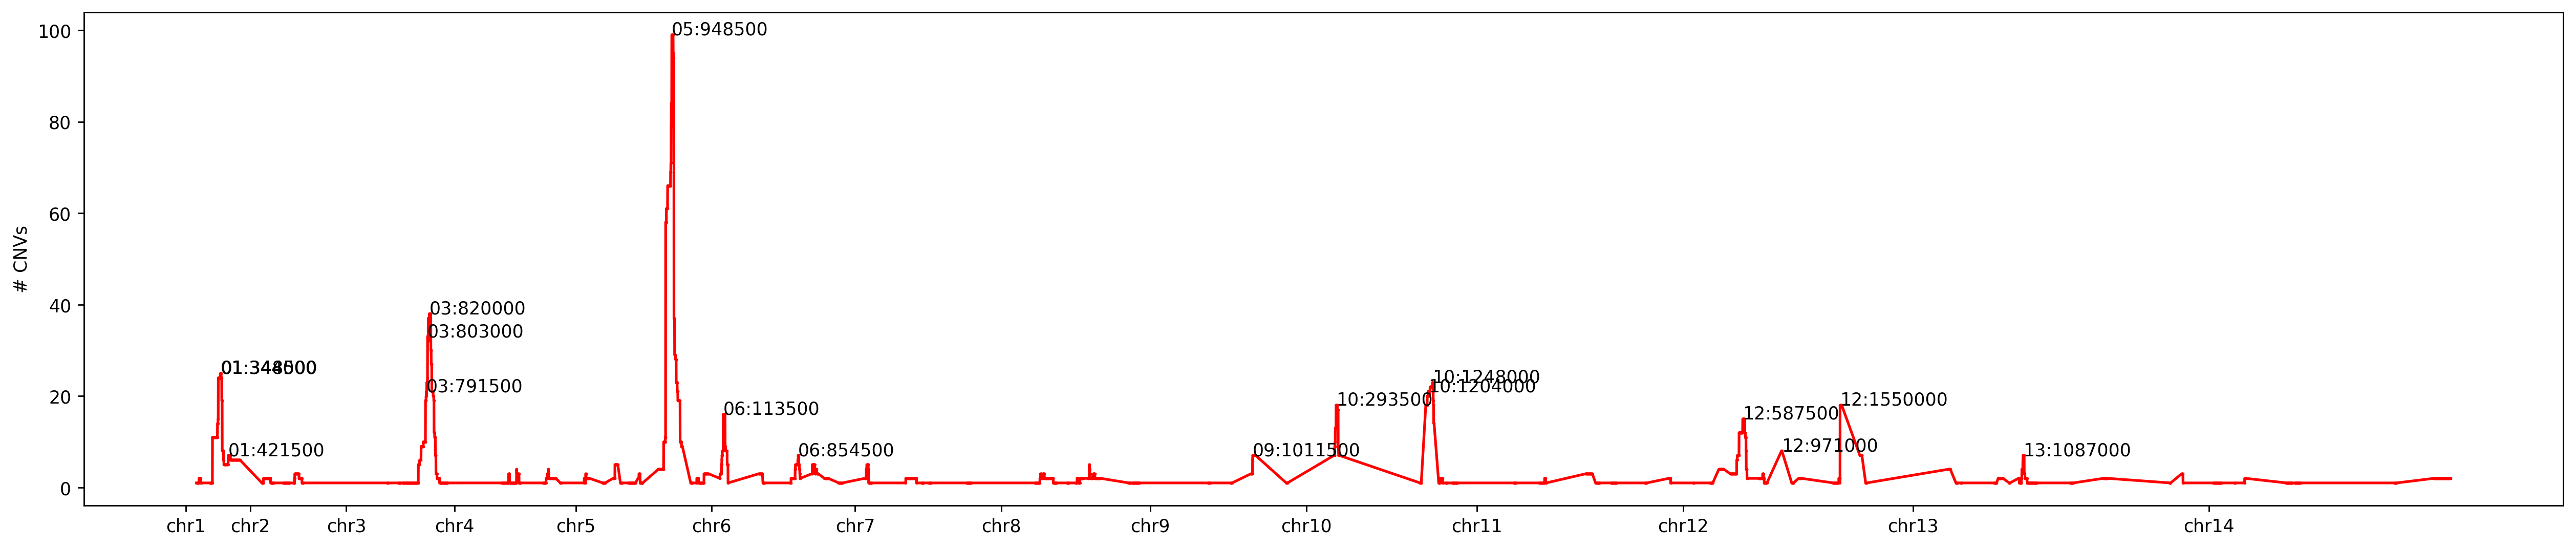

In [95]:
fig, ax = plt.subplots(figsize=(25,5))

xs = []; ys = []

for chrom in chromosomes14:
    chrom_ys = []; chrom_positions = []
    for pos_binned in sorted(chrom_pos_compounds_dict[chrom]):
        num_CNVs = chrom_pos_num_CNVs_dict[chrom][pos_binned]
        
        pos = bin_size*pos_binned
        manhattan_x = chrom_pos_to_manhattan_x(chrom, pos)
        
        xs.append(manhattan_x)
        ys.append(num_CNVs)
        
        chrom_positions.append(pos)
        chrom_ys.append(num_CNVs)
    
    # Label peaks
    start_idx = 0
    sequence = []
    for key, group in itertools.groupby(chrom_ys):
        sequence.append((key, chrom_positions[start_idx]))
        start_idx += sum(1 for _ in group) # Index in the list
    
    for i in range(1, len(sequence)-1):
        y, start_pos = sequence[i]
        if y > 5 and y > sequence[i-1][0] and y > sequence[i+1][0]:
            manhattan_x = chrom_pos_to_manhattan_x(chrom, start_pos)
            ax.text(manhattan_x, y, f"{chrom.split('_v3')[0].split('Pf3D7_')[1]}:{start_pos}",
                    horizontalalignment='left')

ax.plot(xs, ys, '.-', color='red', markersize=1)
ax.set_xticks([chrom_index_dict[chrom] for chrom in chromosomes14])
ax.set_xticklabels(["chr%i" % (i+1) for i, chrom in enumerate(chromosomes14)], horizontalalignment='center')
ax.set_ylabel("# CNVs")
plt.show()

# Manually inspect data

In [13]:
for clone in clone_CNV_validation_dict:
    print(clone)
    for chrom in clone_CNV_validation_dict[clone]:
        print(chrom)
        print(clone_CNV_validation_dict[clone][chrom])
    print('\n---------------\n')

BMGF-Winzeler-5391-2E3
Pf3D7_01_v3
{(238416, 538275): 0.9349961148406418}
Pf3D7_12_v3
{(1746194, 1766641): 0.999853279209664}

---------------

BMGF-Winzeler-5391-3E9
Pf3D7_01_v3
{(264958, 538275): 0.992832498527351}
Pf3D7_12_v3
{(1746194, 1766641): 0.999706558419328}

---------------

BMGF-Fidock-852-R2-A1-SOFTCLIP
Pf3D7_12_v3
{(745752, 827962): 0.9669748205814378}

---------------

BMGF-Winzeler-882-3D7-SOFTCLIP
Pf3D7_02_v3
{(127744, 141408): 0.0}
Pf3D7_03_v3
{(554829, 569079): 0.9200701754385965}
Pf3D7_04_v3
{(485582, 509920): 0.0}
Pf3D7_05_v3
{(604777, 618243): 0.0, (936981, 1054163): 0.18932088546022427}
Pf3D7_06_v3
{(181966, 214392): 0.0, (329287, 343016): 0.5605652268919805, (490608, 522119): 0.0, (554207, 588885): 0.12959224868792896}
Pf3D7_07_v3
{(664706, 675380): 0.0}
Pf3D7_08_v3
{(694965, 710850): 0.15404469625432798, (1047301, 1059124): 0.0}
Pf3D7_09_v3
{(792967, 802386): 0.17093109671939696, (1174953, 1198712): 0.591228587061745}
Pf3D7_10_v3
{(374614, 385043): 0.9343177677